# RNN, LSTM, GRU, Autoencoders & GAN applications

Authors: Kevin Lagos & Andrés Navarro

# 1. RNNs para series de tiempo

Las redes neuronales recurrentes (RNNs) son una red neuronal profunda que tiene, como su nombre indica, entradas recurrentes en la capa oculta, es decir, la salida de una capa oculta se retroalimenta a sí misma. La memoria neuronal es la capacidad impartida a un modelo para retener la entrada de los pasos de tiempo anteriores cuando la entrada es secuencial. En términos simples, cuando nuestro problema está asociado con una secuencia de datos como una oración o una serie temporal o la letra de una canción, el modelo tiene que recordar los estados previos de la entrada para funcionar.

<h1 align='center'> <img src="https://www.hobodataloggers.com.au/images/thumbs/0007371_hobo-weather-station-kits_510.jpeg" width="50%" height="100%" /> </h1>

En esta pregunta trabajaremos con datos obtenidos presumiblemente de una estación meteorológica, los cuales se obtienen desde el sitio https://www.kaggle.com/dronio/SolarEnergy, este dataset contiene mediciones de los últimos 4 meses. Nuestro objetivo será predecir el nivel de radiación solar para la próximas 24 horas.


## 1.a Carga de datos y preprocesamiento.

##### I) Iniciaremos cargando los datos. Para esto necesitará crear una cuenta en kaggle, dirigirse a su perfil, ir a Account, y en la sección API apretar _Create new API token_ , se descargará un archivo kaggle.json, ábralo como archivo de texto y obtenga su username y key. Luego ejecute el siguiente código (desconozco por qué pero a veces hay que ejecutar el código 2 veces para que funcione). Solución obtenida desde el hilo: https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27

In [ ]:
username="kevinalexanderlagos"
key=""
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d dronio/SolarEnergy
if not os.path.exists("/content/solar_prediction"):
    os.makedirs("/content/solar_prediction")
os.chdir('/content/solar_prediction')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

  0% 0.00/511k [00:00<?, ?B/s]
100% 511k/511k [00:00<00:00, 69.9MB/s]
SolarEnergy.zip  SolarPrediction.csv


Procederemos a ordenar la serie temporalmente a continuación.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu') # to convert unixtime
dataset = pd.read_csv('SolarPrediction.csv') # read data
dataset = dataset.sort_values(['UNIXTime'], ascending = [True]) #sort data
dataset.index =  pd.to_datetime(dataset['UNIXTime'], unit='s') # make unix pandas dataframe index
dataset.index = dataset.index.tz_localize(pytz.utc).tz_convert(hawaii) # convert unixtime to timestamp
dataset.drop(['Data','Time','TimeSunRise','TimeSunSet',"UNIXTime"], inplace=True, axis=1) # drop extra-time variables
dataset.tail()

Radiation  ...  Speed
UNIXTime                              ...       
2016-12-31 23:35:02-10:00       1.22  ...   6.75
2016-12-31 23:40:01-10:00       1.21  ...   5.62
2016-12-31 23:45:04-10:00       1.21  ...   7.87
2016-12-31 23:50:03-10:00       1.19  ...   7.87
2016-12-31 23:55:01-10:00       1.21  ...   9.00

[5 rows x 6 columns]

**Comentario:** Se puede observar inmediatamente que existen datos faltantes, los cuales no son declarados. Dado que de los 6 datos impresos se puede inferir que el timestep es de 5 minutos, y faltarían los datos del instante 2016-09-01 ~00:10:00 y 2016-09-01 ~00:15:00

A continuación se proveen comandos con los cuales se puede observar cómo a partir del timestamp generado se puede categorizar con comandos simples el dataset según minuto del día, hora del día, mes del año, y día del año. Los cuales se ocuparán durante la tarea. 

In [ ]:
dataset.index.minute,dataset.index.hour,dataset.index.month,dataset.index.dayofyear

##### II) Para poder idententificar los Missing Values, y poder contar de manera segura con días de 24 horas, ejecute el siguiente código. **Explique** la funcionalidad del código escrito, escribiendo en forma de comentario (#) sobre las líneas de este código.

In [ ]:
import time
t1=time.time() 
new_data=np.nan*np.zeros((24*12*(len(np.unique(dataset.index.dayofyear))),1+len(dataset.columns)), dtype=object)
days=np.unique(np.asarray([str(dataset.index[i]).split(" ")[0] for i in range(dataset.shape[0])]))

def min_to_str(min): #Funcion que transforma el minuto numérico a string de dos digitos
  if min==0: min="00"  
  elif min==5: min="0"+str(min)
  else: min=str(min)
  return(min)

for i in range(new_data.shape[0]): #Rellena un arreglo de timestamps cada 5 minutos
  hr=i//12-24*((i//12)//24)
  if hr==0: hr="00"
  elif 0<hr<10: hr="0"+str(hr)
  else: hr=str(hr)
  min=5*i-60*((5*i)//60)
  day=(i//12)//24
  new_data[i,0]=days[day]+" "+str(hr)+":"+min_to_str(min)+":00"


verbose,freq=True,12*24*5+12+1 # to see output
w_in=0

for i in range(dataset.shape[0]): #Arregla los tiempos de tal manera que todos los minutos son intervalos de 5 consecutivos
  ind=dataset.index[i]
  min=ind.minute
  if i>0: past_min=dataset.index[i-1].minute
  if i<dataset.shape[0]-1: next_min=dataset.index[i+1].minute
  if min%5!=0: 
    if (min+1)%5==0: min=min+1
    elif (min-1)%5==0: min=min-1
    elif past_min%5==0:
      if past_min!=55: min=past_min+5
      else: min=0
    elif next_min%5==0:
      if next_min!=0: min=past_min-5
      else: min=55
    elif (past_min-1)%5==0:
      if (past_min-1)!=55: min=past_min-1+5
      else: min=0
    else: print(past_min,min,next_min,"---keep expanding")
  ind=str(ind)[:-11]+min_to_str(min)+str(ind)[-9:]
  found=0
  for w in range(w_in,w_in+new_data.shape[0]):
    if new_data[w,0][:-2] in ind:
      w_in=w
      found=1
      new_data[w,1:]=dataset.values[i,:]
      if verbose and i%freq==0: print(str(dataset.index[i]),"---->",new_data[w,0])
      break
  if found==0:
    print("Error at ",ind)
    break

df=pd.DataFrame(new_data[:,1:].astype("float32"),index=new_data[:,0],columns=dataset.columns)
t2=time.time()
print("Time of computation (seconds): ", t2-t1)
print("N° Missing time steps data: ", np.isnan(new_data[:,1].astype("float")).sum())

2016-09-01 00:00:08-10:00 ----> 2016-09-01 00:00:00
2016-09-06 07:05:20-10:00 ----> 2016-09-06 07:05:00
2016-09-13 02:25:08-10:00 ----> 2016-09-13 02:25:00
2016-09-19 03:20:05-10:00 ----> 2016-09-19 03:20:00
2016-09-24 06:30:19-10:00 ----> 2016-09-24 06:30:00
2016-09-29 11:15:22-10:00 ----> 2016-09-29 11:15:00
2016-10-05 14:35:20-10:00 ----> 2016-10-05 14:35:00
2016-10-10 18:25:23-10:00 ----> 2016-10-10 18:25:00
2016-10-15 21:50:21-10:00 ----> 2016-10-15 21:50:00
2016-10-20 23:50:20-10:00 ----> 2016-10-20 23:50:00
2016-10-26 01:25:17-10:00 ----> 2016-10-26 01:25:00
2016-10-31 02:45:17-10:00 ----> 2016-10-31 02:45:00
2016-11-05 04:15:18-10:00 ----> 2016-11-05 04:15:00
2016-11-10 05:20:02-10:00 ----> 2016-11-10 05:20:00
2016-11-15 06:25:02-10:00 ----> 2016-11-15 06:25:00
2016-11-20 07:40:20-10:00 ----> 2016-11-20 07:40:00
2016-11-25 09:00:04-10:00 ----> 2016-11-25 09:00:00
2016-12-01 14:55:04-10:00 ----> 2016-12-01 14:55:00
2016-12-09 06:25:52-10:00 ----> 2016-12-09 06:25:00
2016-12-14 0

##### III) **Reemplace** TODOS los missing values (NaN) de cada columna del nuevo dataset (df) de la forma que estime conveniente. Para esto debe usar los valores respectivos de cada columna, ya sea en el pasado o futuro. <br><br> _Como ejemplo_: Si es que existen datos perdidos a las 23:15 hrs, puede reemplazar el valor NaN con el promedio entre las 23:10 y 23:20, teniendo cuidado que el valor en la columna a reemplazar p.ej Pressure sea efectivamente el promedio entre la variable Pressure a las 23:10 y 23:20 . Note que el promedio entre un valor númerico y NaN es igual a NaN, por lo que tendrá que encontrar cómo hacer frente a esta situación.  <br><br> **Comente y fundamente su elección.**

Primero se asume que no puede haber un valor NaN en la primera entrada.

Luego, para el resto de la secuencia, en el caso de que haya un solo NaN entre 2 registros, este tendrá el promedio de los valores de los mismos.

Respecto al caso en que se encuentre más de un valor NaN seguido se consideraron las siguientes posibilidades:

* Tomar el registro antes del primer NaN y después del último, para luego asignarle el promedio de estos valores a todos los NaN, lo que dejaría una sección de los registros con valores constantes.

 Un ejemplo suponiendo 2 NaN seguidos y considerando solo una columna:

| Antes | Después |
|---|---|
| 1 | 1 |
| x | 4 |
| x | 4 |
| 7 | 7 |

* Tomar el registro antes del primer NaN y después del último, para luego progresar de tal manera que los registros perdidos queden equidistantes entre ambos valores y ellos mismos, lo que dejaría una sección con un crecimiento o decrecimiento (según corresponda) constante entre los registros perdidos.

 Un ejemplo suponiendo 2 NaN seguidos y considerando solo una columna:

| Antes | Después |
|---|---|
| 1 | 1 |
| x | 3 |
| x | 5 |
| 7 | 7 |

* Tomar el registro antes del primer NaN y después del último, para luego al primer registro perdido asignarle el promedio entre estos, pero al siguiente registro asignarle el promedio entre el nuevo valor obtenido y el último registro, y así sucesivamente hasta terminar con los valores NaN. Con esto se obtiene una progresión que es más significativa al principio de los valores perdidos y se reduce a medida que avanza en los valores perdidos.

 Un ejemplo suponiendo 2 NaN seguidos y considerando solo una columna:

| Antes | Después |
|---|---|
| 1 | 1 |
| x | 4 |
| x | 5.5 |
| 7 | 7 |

Se consideró la última opción en primera instancia por ser más fácil de implementar. Además, no se tiene el conocimiento del dominio suficiente, ya que, en caso de tenerlo, se debería decidir según los comportamientos "esperados" de la variable de cada columna que se tiene, ya que podrían existir variables que crecen o decrecen rápidamente entre valores mientras que otras lo hacen de forma más constante o consistente, o incluso tal vez que cambien de forma errática.

También, según lo visto en los registros, se decidió redondear los datos a 2 decimales.

In [ ]:
time=pd.to_datetime(df.index)
var_names=df.columns.tolist()
data=df.copy().values
nan_row_loc=np.where((np.isnan((data[:,0]))==True))
np.isnan((data)).sum()



def replace_NaN(prev, next):
  new_array = []
  for i in range(len(var_names)):
    new_array.append(round((data[prev][i]+data[next][i])/2,2 ))
  new_array = np.array(new_array)
  return new_array
  


for loc_nan in nan_row_loc[0]:
  prev_row = loc_nan - 1
  for pos in range(loc_nan + 1, data.shape[0] ):
    if pos not in nan_row_loc[0]:
      next_row = pos
      break
  data[loc_nan] = replace_NaN(prev_row, next_row)


**Para disminuir los tiempos de entrenamiento reduciremos la resolución temporal de 5-min a 1-hr. Para esto calcularemos el promedio de cada hora.**

In [ ]:
data_hr=np.nan*np.zeros((int(data.shape[0]/12),data.shape[1]))
time_hr=np.nan*np.zeros((int(data.shape[0]/12)), dtype=object)
for i in range(data_hr.shape[0]):
  data_hr[i,:]=np.mean(data[12*i:12*(i+1),:],axis=0)
  time_hr[i]=time[12*i]
time_hr=pd.to_datetime(time_hr)

##### IV) **Separe** el dataset en conjuntos de entrenamiento, validación y test, para esto considere un 70% de los datos para entrenamiento, un 15% para validación y un 15% para test. Como se está trabajando con series de tiempo, proceda a crear los conjuntos de manera sucesiva. Guarde las fechas asociadas a cada dato puesto se utilizarán más adelante. 

In [ ]:
data_tr, time_tr = data_hr[:int(data_hr.shape[0]*0.7)],time_hr[:int(data_hr.shape[0]*0.7)]
data_val, time_val = data_hr[int(data_hr.shape[0]*0.7):int(data_hr.shape[0]*0.85)],time_hr[int(data_hr.shape[0]*0.7):int(data_hr.shape[0]*0.85)]
data_tst, time_tst = data_hr[int(data_hr.shape[0]*0.85):],time_hr[int(data_hr.shape[0]*0.85):]

##### V) **Comente y visualice** los valores promedios y desviación estándar de cada atributo del dataset de entrenamiento según la hora del día y mes del año. Apóyese en el siguiente código si lo desea.

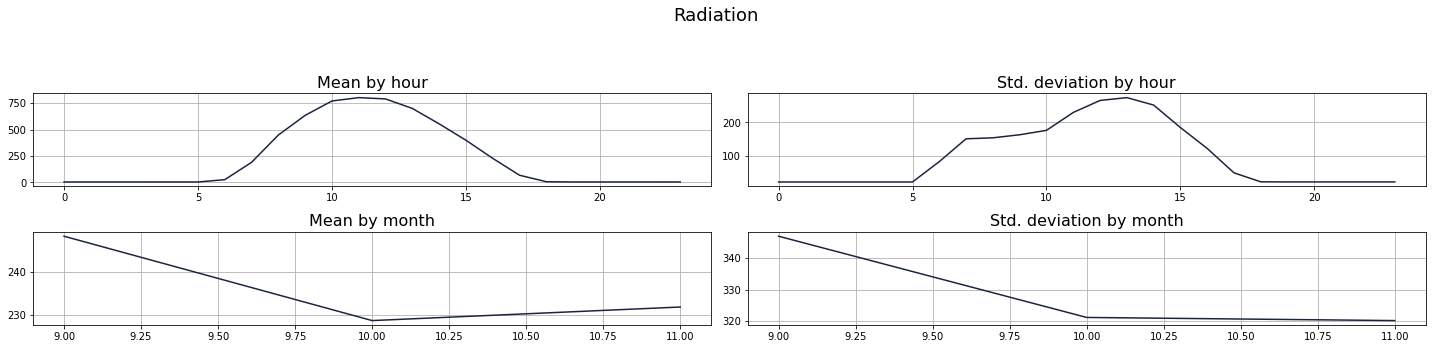

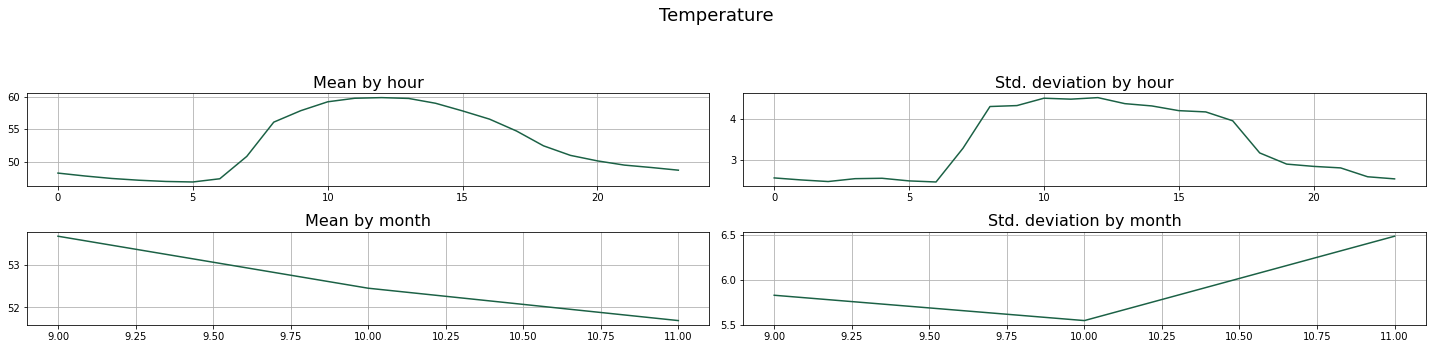

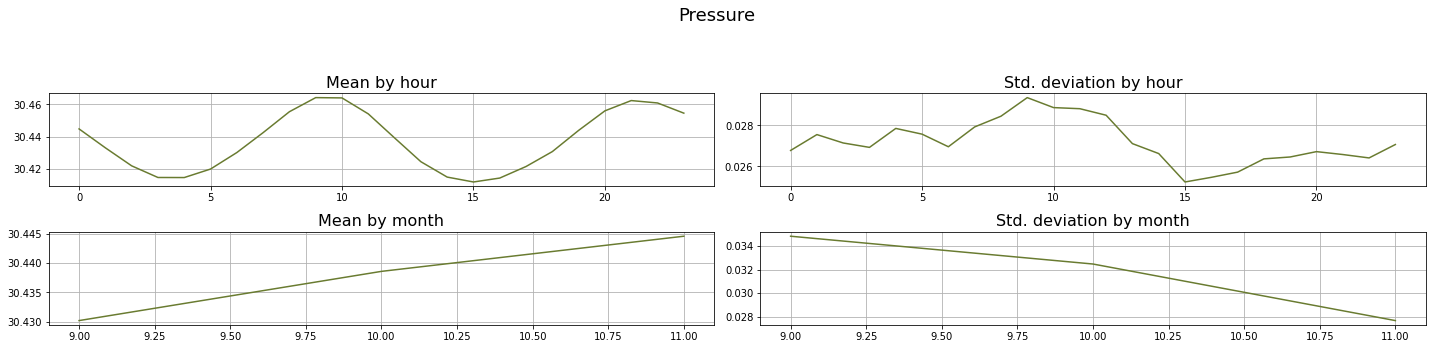

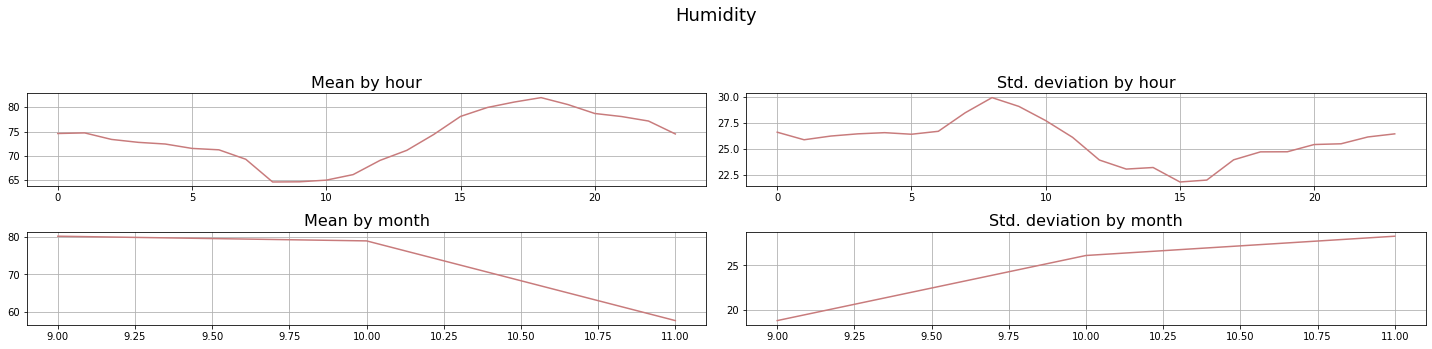

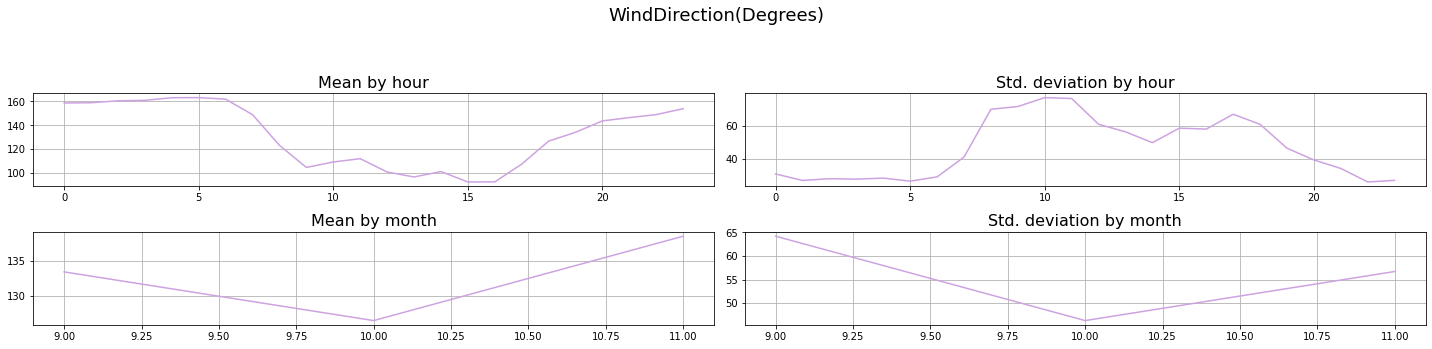

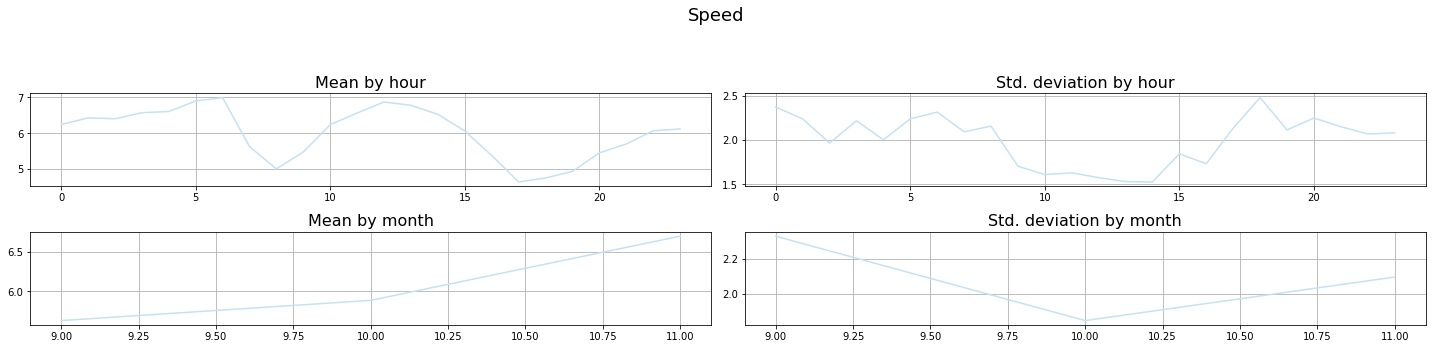

In [ ]:
import matplotlib.pyplot as plt
cols=sns.color_palette("cubehelix", len(var_names))

for J in range(len(var_names)):
  var_name=var_names[J]
  mean_per_hr=np.nan*np.zeros((24))
  std_per_hr=np.nan*np.zeros((24))
  for hr in range(24): #pasa a ser 24

    mean_per_hr[hr]=np.mean(data_tr[time_tr.hour==hr][:,J])
    std_per_hr[hr]=np.std(data_tr[time_tr.hour==hr][:,J])
  mean_per_mt = np.nan*np.zeros((13))
  std_per_mt = np.nan*np.zeros((13))
  #El training comprende los meses de septiembre a noviembre
  for mt in range(9,12):
    mean_per_mt[mt]=np.mean(data_tr[time_tr.month==mt][:,J])
    std_per_mt[mt]=np.std(data_tr[time_tr.month==mt][:,J])

  plt.rcParams["figure.figsize"]=[20,4]
  plt.suptitle(var_name,size=18,y=1.2)
  plt.subplot(2,2,1),plt.title("Mean by hour",size=16)
  plt.plot(mean_per_hr,color=cols[J]),plt.grid()
  plt.subplot(2,2,2),plt.title("Std. deviation by hour",size=16)
  plt.plot(std_per_hr,color=cols[J]),plt.grid()
  plt.subplot(2,2,3),plt.title("Mean by month",size=16)
  plt.plot(mean_per_mt,color=cols[J]),plt.grid()
  plt.subplot(2,2,4),plt.title("Std. deviation by month",size=16)
  plt.plot(std_per_mt,color=cols[J]),plt.grid()
  plt.tight_layout()
  plt.show()

Se debe tomar en consideración que el dataset de entrenamiento posee registros desde septiembre a noviembre. Además los registros son tomados en Hawái, que se encuentra en el hemisferio norte.

* Radiación:

 Este elemento presenta una distribución similar a la uniforme tanto en la media como en la desviación estándar por hora. Con el pasar de los meses tanto la media como la desviación estándar se reducen.

* Temperatura:

 Como es de esperarse, este elemento posee en promedio sus mayores valores a lo largo del día, presentando una distribución similar a la normal en la media y la desviación estándar por hora, además de reducir su media con el paso de los meses. También se puede ver que se presenta una mayor dispersión de día y en el mes de Noviembre.

* Presión:

 En los gráficos por hora se puede ver que la presión presenta un comportamiento similar a una sinusoidal, teniendo sus mayores valores a las 10 y 22 horas aproximadamente, mientras que los menores entre a las 4 y 15 horas aproximadamente. Su desviación estándar se presenta un comportamiento similar, pero más errático. También se puede ver que con el pasar de los meses la media aumenta y la variación disminuye.

* Humedad:

 Se presenta con un comportamiento similar a una sinusoidal en los gráficos por hora, pero mucho menos definida que la presión, además de cumplir un sólo "ciclo" en vez de dos. Con el pasar de los meses la humedad se reduce. También se puede ver que la desviación estándar tanto por mes como por hora presenta una disposición opuesta a la de los gráficos de la media.

* Dirección del viento:

 La media varía entre 160° y 100°, teniendo una tendencia a soplar en valores cercanos a 160° de noche y 100° de día y se presenta una mayor variación de día. En cuanto al comportamiento con el pasar de los meses, su desviación estándar es mayor en septiembre y noviembre y en estos mismos se presenta una tendencia a soplar en direcciones mayores a 130°.
 

* Velocidad del viento:

 En los gráficos por hora se puede ver que se presentan dos valles a las 8 y 17 horas aproximadamente y dos montes. Un monte se presenta en el día y es similar a medio ciclo de una función coseno o seno, mientras que el segundo crece lentamente y luego de llegar a su punto máximo, decrece de forma rápida. Además, se presenta una menor desviación estándar entre las 9 y 15 horas. Con el pasar de los meses la media de la velocidad del viento aumenta.

##### VI) **Estandarice** los conjuntos de entrenamiento, validación y test. Tienendo en mente que buscaremos predecir la radiación para las 24 horas futuras definiremos las variables de entrada y salida, realizando una transformación conveniente utilizando la función split_sequence entregada.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_tr)
xy_tr_sc = scaler.transform(data_tr)
xy_val_sc = scaler.transform(data_val)
xy_tst_sc = scaler.transform(data_tst)


In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out,time_seq):
    X, y , seq_t= list(), list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix,0]
        seq_t.append(time_seq[end_ix])
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y) , np.asarray(seq_t)

In [ ]:
len_inp=24
len_out=24
x_tr,y_tr,t_tr=split_sequence(xy_tr_sc,len_inp,len_out,time_tr)
x_val,y_val,t_val=split_sequence(xy_val_sc,len_inp,len_out,time_val)
x_tst,y_tst,t_tst=split_sequence(xy_tst_sc,len_inp,len_out,time_tst)

**Explique** a qué corresponde cada dimensión de las variables de entrada y salida.

In [ ]:
x_tr.shape,x_val.shape,x_tst.shape,y_tr.shape,y_val.shape,y_tst.shape

((1935, 24, 6), (378, 24, 6), (378, 24, 6), (1935, 24), (378, 24), (378, 24))

* Variables de entrada:
  * Primera dimensión: Cantidad de registros/ejemplos de cada conjunto.
  * Segunda dimensión: Largo de la secuencia o time steps.
  * Tercera dimensión: Número de features, es decir, las vistas anteriormente en los gráficos.

* Variables de salida:
  * Primera dimensión: Cantidad de registros de cada conjunto.
  * Segunda dimensión: Largo de la secuencia o time steps.

## 1.b) Primera  red recurrente.
Ahora entrenaremos una primera red recurrente LSTM. **Explique** la particularidad de estas redes y **por qué** podría comportarse bien para este tipo de problemas. <br> <br> Entrenaremos dos redes recurrentes similares, la primera tan solo utilizará la variable Radiation como entrada para predecir Radiation, caso que llamaremos **univariante**, mientras la segunda utilizará las variables [Radiation, Temperature, Pressure, Humidity, WindDirection(Degrees), Speed] como entrada para predecir Radiation, caso que llamaremos **multivariante**. <br> <br> **Recupere** las funciones utilizadas en la tarea anterior para graficar los errores de entrenamiento, validación y test, y así comparar el rendimiento de ambas redes RNN gráficamente. **Comente**

La particularidad que tienen las redes LSTM de que sus neuronas poseen compuertas que determinan si lo que reciben será considerado (compuerta de input), si será olvidado (compuerta de olvido), y que tanto del output finalmente será entregado (compuerta de output). Además esta red resuelve el problema del gradiente descendente presente en las RNNs.

Estas se pueden comportar bien para este tipo de problemas ya que tienen la capacidad de almacenar más memoria, lo que es útil para predecir secuencias de datos.

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import activations
from tensorflow.python.keras.engine import input_layer

input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm)
dens=layers.Dense(len_out, activation='sigmoid')(rnn)
model_1=models.Model(inputs=input_lstm, outputs=dens)
model_1.compile(loss='mse', optimizer='adam')

model_1.summary()
history_1 = model_1.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=10, batch_size=16,verbose=False)

input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm)
dens=layers.Dense(len_out, activation='sigmoid')(rnn)
model_2=models.Model(inputs=input_lstm, outputs=dens)
model_2.compile(loss='mse', optimizer='adam')

model_2.summary()
history_2 = model_2.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=False)

y_pred_1=model_1(x_tst[:,:,0:1])
tst_loss_1=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_1)).numpy()
y_pred_2=model_2(x_tst)
tst_loss_2=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_2)).numpy()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 56)                12992     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1368      
Total params: 14,360
Trainable params: 14,360
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 56)                14112     
______________________________________

In [ ]:
plt.rcParams["figure.figsize"]=[16,3]
def graph_results(hists,tsts,titles):
  fig, axes = plt.subplots(1, len(hists), sharey=True) # sharey to keep the same y lims for all subplots. 
                                            # En algunos casos esto puede jugar en contra para una buena visualización -> ver siguiente comentario
  for i,ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.plot(hists[i]["loss"],"b-",label="Train_loss")
    ax.plot(hists[i]["val_loss"],"g-",label="Val_loss")
    ax.axhline(y=tsts[i],color="k",linestyle="-.",label="Tst_loss")
    ax.set_xlabel("Epochs"),ax.set_ylabel("MSE Error")
    #ax.set_xlim([-20,520])
    #ax.set_ylim([y_min, y_max])  # <- Puede convenir insertar como entrada a la función límite inferiores y superiores para ajuste manual
    if i==len(axes)-1: ax.legend()
    ax.grid()
  plt.tight_layout()
  plt.show()

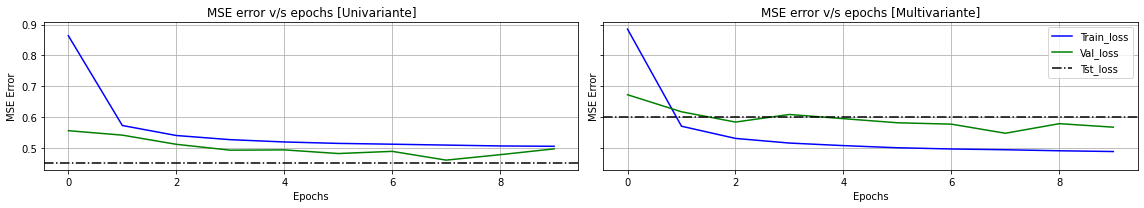

In [ ]:
hists=[history_1.history,history_2.history]
tsts=[tst_loss_1,tst_loss_2]
titles=["MSE error v/s epochs [Univariante]","MSE error v/s epochs [Multivariante]"]

graph_results(hists,tsts,titles) # llamado simple para graficar

A simple vista se puede dar cuenta de que el obtener la predicción de la radiación en base a sólo su columna presenta un mejor rendimiento para los todos los conjuntos, obteniendo un train_loss, val_loss más bajo en promedio que con multivariante, destacando el tst_loss que es mucho menor en univariante.

Se cree que esta diferencia de desempeño puede estar dada porque el considerar otras variables puede generar ruido y no aportar a mejorar la calidad de la predicción.

## 1.c) Exploración de profundidad y GRU.

##### I) Exploraremos aumentar la profundidad de la red neuronal. El modelo LSTM original se compone de una sola capa LSTM oculta seguida de una capa de salida estándar. Podríamos decir que nuestra red neuronal posee dos profundidades distintas. La Stacked LSTM es una extensión del modelo LSTM original, la cual tiene múltiples capas LSTM ocultas donde cada capa contiene múltiples celdas de memoria. A la vez, del mismo modo que en la Tarea 1, es posible aumentar la profundidad de la red densa de salida. 

Proceda a probar distintas combinaciones de profundidades de capas LSTM y de capas Densas (contando la capa de salida), para el caso univariado y multivariado. Para mantener un tiempo de ejecución produnte, considere una profunidad LSTM máxima de 2, y una profundidad densa máxima de 2. **Grafique y compare** los errores de entrenamiento, validación y test para los distintos casos.  **Comente**.

El siguiente código muestra el caso multivariado con profundidades máximas LSTM y Densas. Utilice el número de celdas de memoria y número de neuronas recomendado en el código para las distintas profundidades, al igual que el número de epochs.

**Pregunta:** ¿Por qué cuando una capa LSTM precede otra capa LSTM es necesario utilizar return_sequences=True? ¿Es necesario/recomendado utilizar return_sequences=False cuando una capa LSTM precede a una capa Densa?

Es necesario poner `return_sequences=True` ya que con esto el output es una secuencia del mismo largo que el input, coincidiendo así las dimensiones de input de ambas capas. En el caso de que la siguiente capa sea densa es recomendado utilizar `return_sequences=False` ya que de esta manera solo se entrega como output el último output de la secuencia.

In [ ]:
def prod_LSTM(multi, lstm2, densa2):
  print(multi, lstm2, densa2)
  if multi:
    input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
  else:
    input_lstm= input_layer.Input(shape=(x_tr.shape[1],1)) 
  if(lstm2):
    rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
    rnn=layers.LSTM(units=56,return_sequences=False)(rnn) # 2° lstm
  else:
    rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm) # 1° lstm
  if(densa2):
    dens=layers.Dense(32, activation='relu')(rnn) # 1° densa
    dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
  else:
    dens=layers.Dense(len_out, activation='sigmoid')(rnn)
  model=models.Model(inputs=input_lstm, outputs=dens)
  model.compile(loss='mse', optimizer='adam')
  model.summary()
  if multi:
    history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=True)
    y_pred=model(x_tst)
  else:
    history = model.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=10, batch_size=16,verbose=False)
    y_pred = model(x_tst[:,:,0:1])

  tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()
  return(history,tst_loss)

In [ ]:
result = []
booleanos = [False, True]
for v_type in booleanos:
  for n_lstm in booleanos:
    for n_densa in booleanos:
      result.append(prod_LSTM(v_type, n_lstm, n_densa))

False False False
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 24, 1)]           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 56)                12992     
_________________________________________________________________
dense_15 (Dense)             (None, 24)                1368      
Total params: 14,360
Trainable params: 14,360
Non-trainable params: 0
_________________________________________________________________
False False True
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 24, 1)]           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 56)                12992     
_

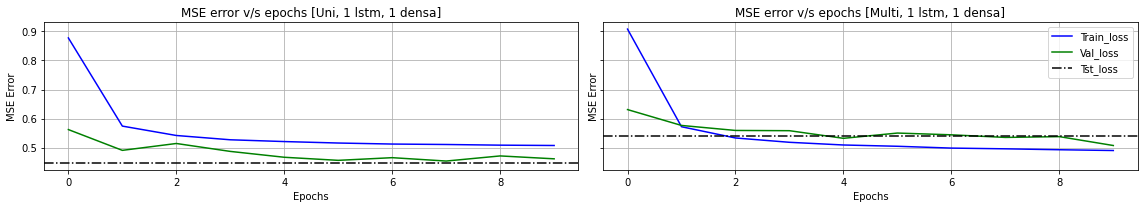

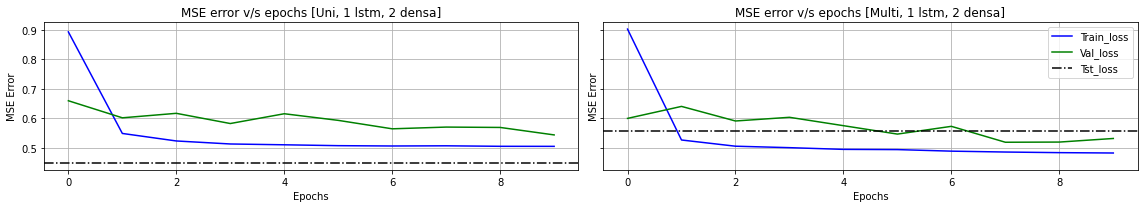

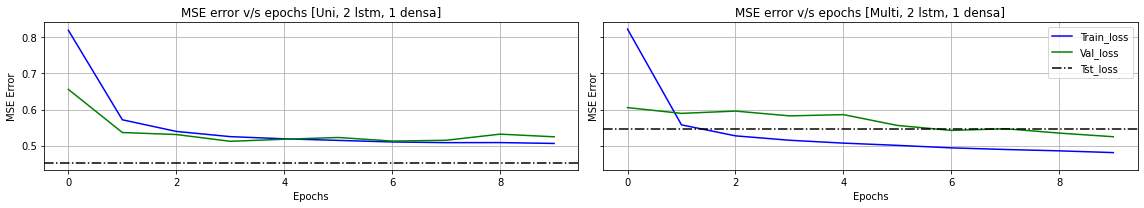

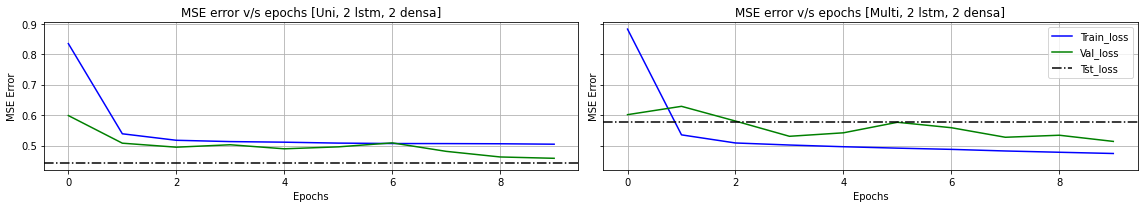

0.44664016 0.5386477
0.44819036 0.55707395
0.45167178 0.5474442
0.4424113 0.57893753


In [ ]:
titles=["MSE error v/s epochs [Uni, 1 lstm, 1 densa]","MSE error v/s epochs [Uni, 1 lstm, 2 densa]",
        "MSE error v/s epochs [Uni, 2 lstm, 1 densa]","MSE error v/s epochs [Uni, 2 lstm, 2 densa]",
        "MSE error v/s epochs [Multi, 1 lstm, 1 densa]","MSE error v/s epochs [Multi, 1 lstm, 2 densa]",
        "MSE error v/s epochs [Multi, 2 lstm, 1 densa]","MSE error v/s epochs [Multi, 2 lstm, 2 densa]"
        ]

for i in range(4):
  hists = [result[i][0].history, result[i+4][0].history]
  tsts = [result[i][1], result[i+4][1]]
  title = [titles[i], titles[i+4]]
  graph_results(hists, tsts, title)

for i in range(4):
  print(result[i][1], result[i+4][1])

Se puede observar que si se compara las redes con la misma cantidad de capas LSTM y densas, las univariantes presentan mejor rendimiento que sus contrapartes multivariantes.

Sin embargo todas las redes tienden a presentar valores similares con el pasar de las epochs, rondando valores cercanos a 0.5 para todos los conjuntos, presentando un buen desempeño a lo largo de su entrenamiento. 

Se destaca el hecho que la red univariante con 2 capas LSTM y 2 densas obtiene el mejor error de validación y de testing, seguida por la univariante con 1 capa LSTM y 1 densa.

##### II) Añadiremos entradas a la capa Densa que indiquen la hora del día de forma bi-dimensional, semejante a un reloj, y una variable dummy que indica si es de día o noche. Ejecute el siguiente código para generar las entradas adicionales, y **añada la entrada** a la arquitectura entregada. Esta forma de ingresar variables adicionales a la capa densa se asemeja a la arquitectura skip-connections vista en la Tarea 1. **La hora que se entrega para indicar si es de día o noche es intencionalmente erronea**. Utilizando los datos de radiación del conjunto de entrenamiento **deberá definir las horas de día y noche de manera justificada**. 

**Comente** sobre los resultados obtenidos.

**Pregunta:** ¿Por qué puede resultar beneficioso representar la hora del día de manera bidimensional en lugar de unidimensional? 

Se elige el rango de horas del día entre las 6 de la mañana y las 6 de la tarde. Esto debido a que la radiación presente en el conjunto de observaciones de entrenamiento incrementa en este rango horario, lo que tiene sentido ya que la radiación solar llega principalmente de día. 

Puede resultar beneficioso representar la hora de manera bidimensional ya que en primera instancia, al trabajarla con senos y cosenos las manejamos de una forma "cíclica" lo que puede llegar a ser mucho más útil que simplemente tener un número ascendente entre una columna y otra. Esto también se puede ver en los gráficos de las variables, en donde se presenta un comportamiento recurrente en los graficos de la media de las variables. 

In [ ]:
daytimehrs=[6,18]

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import activations
from tensorflow.python.keras.engine import input_layer

from math import *
hour_1_tr=np.asarray(np.sin(2*pi*pd.to_datetime(t_tr).hour/24)).reshape(-1,1)
hour_2_tr=np.asarray(np.cos(2*pi*pd.to_datetime(t_tr).hour/24)).reshape(-1,1)
dummy_tr=(1*(pd.to_datetime(t_tr).hour<daytimehrs[1])*(pd.to_datetime(t_tr).hour>daytimehrs[0])).reshape(-1,1)
hour_1_val=np.asarray(np.sin(2*pi*pd.to_datetime(t_val).hour/24)).reshape(-1,1)
hour_2_val=np.asarray(np.cos(2*pi*pd.to_datetime(t_val).hour/24)).reshape(-1,1)
dummy_val=(1*(pd.to_datetime(t_val).hour<daytimehrs[1])*(pd.to_datetime(t_val).hour>daytimehrs[0])).reshape(-1,1)
hour_1_tst=np.asarray(np.sin(2*pi*pd.to_datetime(t_tst).hour/24)).reshape(-1,1)
hour_2_tst=np.asarray(np.cos(2*pi*pd.to_datetime(t_tst).hour/24)).reshape(-1,1)
dummy_tst=(1*(pd.to_datetime(t_tst).hour<daytimehrs[1])*(pd.to_datetime(t_tst).hour>daytimehrs[0])).reshape(-1,1)

ext_tr=np.concatenate((hour_1_tr,hour_2_tr,dummy_tr),axis=1)
ext_val=np.concatenate((hour_1_val,hour_2_val,dummy_val),axis=1)
ext_tst=np.concatenate((hour_1_tst,hour_2_tst,dummy_tst),axis=1)

In [ ]:
from keras.layers import concatenate

input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.LSTM(units=56,return_sequences=False)(rnn) # 2° lstm
input_clock= input_layer.Input(shape=(3))
input_dense=concatenate([rnn, input_clock])
dens=layers.Dense(32, activation='relu')(input_dense) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=[input_lstm,input_clock], outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
hist = model.fit([x_tr,ext_tr],y_tr, validation_data=([x_val,ext_val],y_val), epochs=10, batch_size=16,verbose=True)
y_pred=model([x_tst,ext_tst])
tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 24, 56)       14112       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 56)           25312       lstm_2[0][0]                     
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 3)]          0                                            
____________________________________________________________________________________________

In [ ]:
plt.rcParams["figure.figsize"]=[16,3]
def graph_results_alone(hist,tst,title):
  plt.title(title)
  plt.plot(hist.history["loss"],"b-",label="Train_loss")
  plt.plot(hist.history["val_loss"],"g-",label="Val_loss")
  plt.axhline(y=tst,color="k",linestyle="-.",label="Tst_loss")
  plt.xlabel("Epochs"),plt.ylabel("MSE Error")
  plt.legend(),plt.grid()
  plt.show()
  plt.tight_layout()
  plt.show()

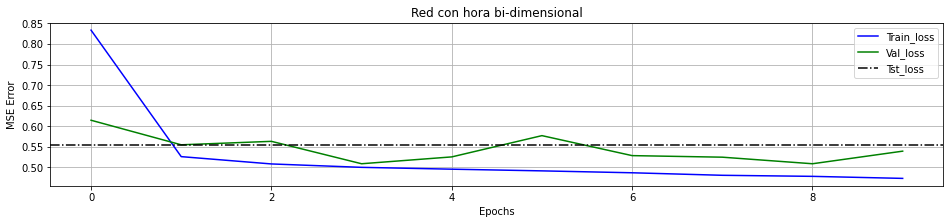

<Figure size 1152x216 with 0 Axes>

In [ ]:
graph_results_alone(hist, tst_loss, "Red con hora bi-dimensional")

Respecto a los resultados obtenidos, estos son buenos ya que se obtienen errores que rondan los valores [0.45,0.55]. Sin embargo, si se comparan con los obtenidos con anterioridad, esta red presenta un peor desempeño, aunque son cercanos respecto a la red con la misma arquitectura (multivariante, 2 lstm, 2 capas densas).

Por otro lado, si nos fijamos en el error de test, este posee un valor cercano a 0.55, el cual es un error cercano a los obtenidos anteriormente con las redes multivariantes.

##### III) Entrene la misma arquitectura que en la pregunta anterior utilizando unidades GRU en lugar de LSTM. **Explique la diferencia entre GRU y LSTM**. **Compare** los resultados con los obtenidos en el punto anterior.

In [ ]:
input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.GRU(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.GRU(units=56,return_sequences=False)(rnn) # 2° lstm
input_clock= input_layer.Input(shape=(3))
input_dense=concatenate([rnn, input_clock])
dens=layers.Dense(32, activation='relu')(input_dense) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=[input_lstm,input_clock], outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
hist = model.fit([x_tr,ext_tr],y_tr, validation_data=([x_val,ext_val],y_val), epochs=10, batch_size=16,verbose=True)
y_pred=model([x_tst,ext_tst])
tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 24, 56)       10584       input_5[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 56)           18984       gru[0][0]                        
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 3)]          0                                            
____________________________________________________________________________________________

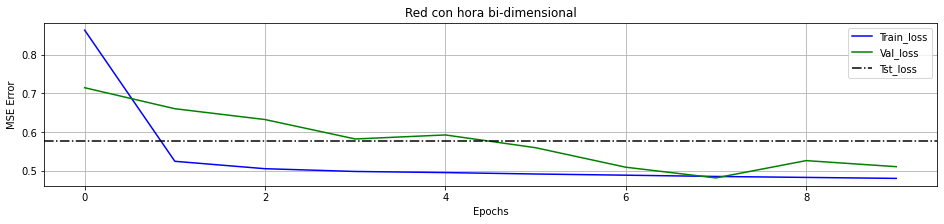

<Figure size 1152x216 with 0 Axes>

In [ ]:
graph_results_alone(hist, tst_loss, "Red con hora bi-dimensional")

La diferencia radica en que GRU posee solo 2 compuertas, una de reset, que determina cómo combinar el input con la memoria previa y una de update para saber qué tanto de la memoria anterior mantener u olvidar.

El objetivo que persigue es entrenar más rápido la red con menos datos para generalizar, ya que hace uso de todos los estados ocultos directamente. Las LSTM son mejores para procesar dependencias a largo plazo.

Esta nueva arquitectura se comportó similar a la anterior pero posee un menor error de validación, llegando a 0.4820. Por otro lado, esta presenta un mayor error del conjunto de testing, con una diferencia de aproximadamente 0.04.

##### IV) Con la red con mejor rendimiento, respecto al error de validación, en este punto 1.c) ejecute el siguiente código y saque conclusiones del violin plot.

**Pregunta:** ¿Qué hace un violin plot?

Es similar a un boxplot, pero este muestra la probabilidad de densidad de los datos en diferentes valores. Esto puede ser util en el caso de que la data posea dos o más modas, lo que se vería reflejado en el área coloreada.

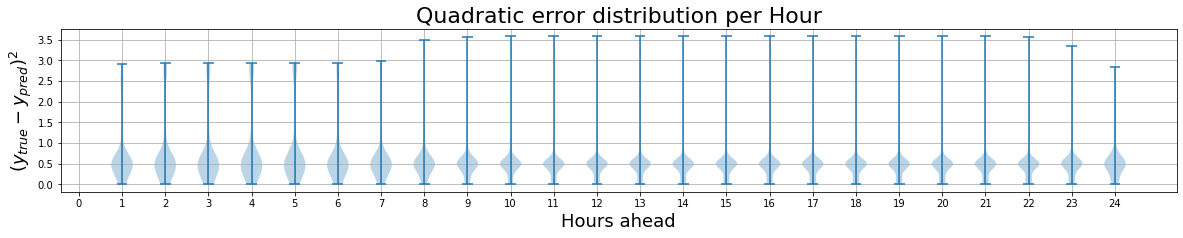

In [ ]:
y_pred=model([x_tst,ext_tst])
tst_loss=((y_tst- y_pred)**2).numpy()
plt.rcParams["figure.figsize"]=[20,3]
plt.title("Error distribution per Hour",size=22)
plt.violinplot(tst_loss)
plt.xlabel("Hours ahead",size=18)
plt.ylabel("$(y_{true}-y_{pred})^2$",size=18)
plt.xticks(np.arange(25))
plt.grid()
plt.show()

Con este gráfico se puede evidenciar que existe una mayor dispersión del error entre las 24:00 y las 7:00, lo que se puede ver en la región que se presenta entre el 0.0 y el 1.0. Sin embargo, a pesar de que en el resto de horas se tiene una menor dispersión, el cuarto cuartil alcanza valores más altos.

## 1.d) Parameters & hyperparameters tunning. 

##### I) Como se habrá percatado, existe una **inmensa** cantidad de hiperparámetros que uno puede ajustar en las arquitecturas de redes neuronales (learning rate, profundidad de red, n° de neuronas en cada capa, optimizador, cantidad de epochs), también se puede considerar como hiperparámetro si es que incluir o no métodos tales como batch normalization, regularización L1/L2 o dropout en la red neuronal, a la vez habrá qué decidir dónde situar estos métodos, y cómo ajustar sus propios hiperparámetros. Aún más, también es posible experimentar con la manipulación del dataset, p.ej decidir si usar una entrada univariada, multivariada, o un punto intermedio (y si es un punto intermedio qué variables ocupar), también es posible variar el largo de las series de tiempo de entrada.

Prepare un código para hacer **Random Search**, dado que los tiempos de entrenamiento serán desproporcionados, **NO ENTRENE** las redes neuronales, pero evalúe en el conjunto de validación como si las hubiese entrenado para escoger los ""mejores"" parámetros & hiperparámetros de la red neuronal. Mantenga el objetivo de predecir la radiación para las siguientes 24 horas. **Imprima** (print) los valores de los parámetros & hiperparámetros de la red que se esté evaluando, indicando a qué corresponde, y recolecte el error de validación. Realice un Random Search de largo 100, apóyese en el código entregado, **expándalo** desde la búsqueda de 3 hiperparámetros/parámetros hasta una búsqueda de al menos **12** hiperparámetros/parámetros, puede escoger de los ejemplos dados en el primer párrafo de este ítem, o bien escoger por su propia cuenta. El código debe ser funcional, es decir, las _arquitecturas/manipulaciones del dataset_ indicadas por los hiperparámetros/parámetros deben ser efectivamente aplicadas en la construcción de la red neuronal y/o manipulación de datos. Note que en el código dado, un hiperparámetro a ajustar es recurrent dropout. **Indique** cuál fue la mejor arquitectura encontrada según el error de validación.

**Preguntas:** 

i) ¿Qué alternativas al Random Search existen? Nombre al menos una. 

ii) ¿Qué hace el método recurrent dropout?

i) Una alternativa que existe es Grid Search, en el que se define un espacio de búsqueda como una grilla de valores de hiperparámetros y evalúa cada posición en la grilla.

ii) El método recurrent dropout es un metodo de regularización para las RNNs. Este aplica el dropout a las compuertas de entrada o update en LSTM o GRU.

In [ ]:
from keras.regularizers import l1,l2
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta

val_h=[]
for random_search in range(100):
  prof_rnn=np.random.randint(1,4)
  neu_rnn=[np.random.randint(20,40) for t in range(prof_rnn)]
  rec_drop=np.random.uniform(0,0.7)
  #4
  dense_drop=np.random.uniform(0, 0.7)
  #5
  regs = np.random.choice([l1, l2])
  lamb = np.random.choice([0.0, 0.1])
  #6
  opti = np.random.choice([SGD, Adam, RMSprop, Adagrad, Adadelta])
  #7
  learning_r = np.random.choice([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
  #8
  prof_dense = np.random.randint(1,4)
  #9
  act_fun = np.random.choice(['sigmoid', 'relu', 'tanh'])
  #10
  kernel_init = np.random.choice(['uniform','he_uniform','glorot_normal','glorot_uniform'])
  #11
  neu_dense = [np.random.randint(24,100) for t in range(prof_dense)]
  #12
  l_decay = np.logspace(-6,0,6)
  l_decay=np.around(l_decay,decimals=6)
  l_decay=np.random.choice(l_decay)
  
  input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
  for i,neu in enumerate(neu_rnn):
    if(len(neu_rnn) > 1):
      if i==0: rnn=layers.LSTM(units=neu_rnn[0],return_sequences=True,recurrent_dropout=rec_drop)(input_lstm)
      else: rnn=layers.LSTM(units=neu_rnn[i],return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop)(rnn)
    else:
      rnn=layers.LSTM(units=neu_rnn[0],return_sequences=False,recurrent_dropout=rec_drop)(input_lstm)
  for i, neu in enumerate(neu_dense[:-1]):
    if(len(neu_dense) > 1):
      if i==0:
        dens=layers.Dense(neu_dense[i], activation='sigmoid', activity_regularizer= regs(lamb), kernel_initializer=kernel_init)(rnn)
      else:
        dens=layers.Dense(neu_dense[i], activation='sigmoid', activity_regularizer= regs(lamb), kernel_initializer= kernel_init)(dens)
      dens=layers.Dropout(dense_drop)(dens)
  if(len(neu_dense)>1):
    dens=layers.Dense(len_out, activation='sigmoid', activity_regularizer= regs(lamb), kernel_initializer= kernel_init)(dens)
  else:
    dens=layers.Dense(len_out, activation='sigmoid', activity_regularizer= regs(lamb), kernel_initializer= kernel_init)(rnn)


    

  model=models.Model(inputs=input_lstm, outputs=dens)
  if(opti == SGD):
    model.compile(optimizer=opti(learning_rate=learning_r,decay= l_decay),loss='mean_squared_error')
  else:
    model.compile(optimizer=opti(learning_rate=learning_r),loss='mean_squared_error')
    l_decay = "No aplica"
  y_pred=model(x_val)
  val_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_val, y_pred)).numpy()
  val_h.append(val_loss)
  print(random_search+1,"° --->  Profundidad rnn: ",prof_rnn, " | N° neuronas(rnn): ", neu_rnn, " | Recurrent dropout: ", rec_drop, 
        " | Dropout capas densas: ", dense_drop,
        " | Regularizador y lambda ", regs.__name__, lamb,
        " | Optimizador: ", opti.__name__,
        " | Learning rate: ", learning_r,
        " | N° de capas densas: ", prof_dense,
        " | Función de activación: ", act_fun,
        " | Inicialización: ", kernel_init,
        " | N° neuronas(capas densas): ", neu_dense,
        " | Learning decay ", l_decay
        )
  print("Validation error: ",val_loss)
  print("-"*120)

print("N° Arquitectura con mejor error de validación: ", val_h.index(np.min(val_h))+1)
print("Error de validación: ", np.min(val_h))

1 ° --->  Profundidad rnn:  3  | N° neuronas(rnn):  [39, 33, 29]  | Recurrent dropout:  0.2156502801254337  | Dropout capas densas:  0.33419274413477396  | Regularizador y lambda  L2 0.0  | Optimizador:  SGD  | Learning rate:  0.1  | N° de capas densas:  1  | Función de activación:  sigmoid  | Inicialización:  uniform  | N° neuronas(capas densas):  [43]  | Learning decay  0.000251
Validation error:  1.1123123
------------------------------------------------------------------------------------------------------------------------
2 ° --->  Profundidad rnn:  2  | N° neuronas(rnn):  [32, 36]  | Recurrent dropout:  0.0716057465788133  | Dropout capas densas:  0.2236192086344026  | Regularizador y lambda  L2 0.1  | Optimizador:  Adadelta  | Learning rate:  0.0001  | N° de capas densas:  1  | Función de activación:  tanh  | Inicialización:  uniform  | N° neuronas(capas densas):  [66]  | Learning decay  No aplica
Validation error:  1.1117973
----------------------------------------------------

La mejor arquitectura fue la N° 78, con un error de validación de 1.014272 y con la siguiente configuración:

* Profundidad rnn:  1  
* N° neuronas(rnn):  [29]  *
* Recurrent dropout:  0.11636360580425366 
* Dropout capas densas:  0.34682548109297123  
* Regularizador y lambda  L2 0.1  
* Optimizador:  Adadelta  
* Learning rate:  1e-05  
* N° de capas densas:  2  
* Función de activación:  sigmoid  
* Inicialización:  he_uniform  
* N° neuronas(capas densas):  [74, 57]  
* Learning decay  No aplica



##### II) Implemente sobre el código de Random Search la funcionalidad de realizar Cross-Validation con 5 Folds para cada red neuronal creada en el proceso de Random Search. Dado que se está trabajando con series de tiempo ocupe la función TimeSeriesSplit. Nuevamente **NO ENTRENE** las redes neuronales. El conjunto de entrenamiento y validación deben ser uno inicialmente para luego ser divididos en cada Fold, el conjunto de test se debiese mantener hasta el final. Calcule el error en el conjunto de validación de cada Fold y use el promedio de los 5 Folds para evaluar el rendimiento de cada red neuronal, encuentre los ""mejores"" parámetros/hiperparámetros basado en estos promedios.

**Preguntas:**

i) Visite la página https://scikit-learn.org/stable/modules/cross_validation.html . **Nombre y explique** el método TimeSeriesSplit y al menos otros 3 métodos de cross-validation. ¿Por qué time series split es adecuado para nuestro caso?

ii) ¿Cuáles son los fundamentos de Cross Validation en general (como herramienta de selección de hiperparámetros)?

i) 
* TimeSeriesSplit: Es una variación de K-Fold donde se retornan los primeros $k$ folds como train set y el $(k+1)$ésimo como test set.

* K-Fold: Divide todos los samples en $k$ grupos de samples, en lo posible de tamaños iguales. A partir de esta partición de folds, se deja un fold para entrenamiento y el otro para test.

* LeaveOneOut: Es un método de cross-validation en el cual se crea un conjunto de entrenamiento con todos los samples excepto uno, y este restante se deja para el conjunto de test. Por lo tanto, se tienen dinstintos training sets y test sets para entrenar la red. A partir de lo anterior, si se aplica KFold con $k=n$ el método es igual a este mencionado.

Utilizar TimeSeriesSplit  es adecuado debido a que la data que tenemos corresponde a series de tiempo y no corresponde a una relación lineal o categórica.

ii) Se basa en el fundamento de evitar overfitting en los modelos y garantizar la independencia de las particiones entre datos de training y set. Respecto a lo anterior podemos predecir el ajuste de un modelo con conjuntos de prueba hipotéticos cuando no se dispone de un conjunto de datos de prueba real.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

ts5 = TimeSeriesSplit(n_splits=5)


data_tst, time_tst = data_hr[int(data_hr.shape[0]*0.85):],time_hr[int(data_hr.shape[0]*0.85):] # KEEP IT UNTIL THE END

val_h=[]
for random_search in range(100):
  prof_rnn=np.random.randint(1,4)
  neu_rnn=[np.random.randint(20,40) for t in range(prof_rnn)]
  rec_drop=np.random.uniform(0,0.7)
  #4
  dense_drop=np.random.uniform(0, 0.7)
  #5
  regs = np.random.choice([l1, l2])
  lamb = np.random.choice([0.0, 0.1])
  #6
  opti = np.random.choice([SGD, Adam, RMSprop, Adagrad, Adadelta])
  #7
  learning_r = np.random.choice([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
  #8
  prof_dense = np.random.randint(1,4)
  #9
  act_fun = np.random.choice(['sigmoid', 'relu', 'tanh'])
  #10
  kernel_init = np.random.choice(['uniform','he_uniform','glorot_normal','glorot_uniform'])
  #11
  neu_dense = [np.random.randint(24,100) for t in range(prof_dense)]
  #12
  l_decay = np.logspace(-6,0,6)
  l_decay=np.around(l_decay,decimals=6)
  l_decay=np.random.choice(l_decay)
  
  input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
  for i,neu in enumerate(neu_rnn):
    if(len(neu_rnn) > 1):
      if i==0: rnn=layers.LSTM(units=neu_rnn[0],return_sequences=True,recurrent_dropout=rec_drop)(input_lstm)
      else: rnn=layers.LSTM(units=neu_rnn[i],return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop)(rnn)
    else:
      rnn=layers.LSTM(units=neu_rnn[0],return_sequences=False,recurrent_dropout=rec_drop)(input_lstm)
  for i, neu in enumerate(neu_dense[:-1]):
    if(len(neu_dense) > 1):
      if i==0:
        dens=layers.Dense(neu_dense[i], activation='sigmoid', activity_regularizer= regs(lamb), kernel_initializer=kernel_init)(rnn)
      else:
        dens=layers.Dense(neu_dense[i], activation='sigmoid', activity_regularizer= regs(lamb), kernel_initializer= kernel_init)(dens)
      dens=layers.Dropout(dense_drop)(dens)
  if(len(neu_dense)>1):
    dens=layers.Dense(len_out, activation='sigmoid', activity_regularizer= regs(lamb), kernel_initializer= kernel_init)(dens)
  else:
    dens=layers.Dense(len_out, activation='sigmoid', activity_regularizer= regs(lamb), kernel_initializer= kernel_init)(rnn)


    

  model=models.Model(inputs=input_lstm, outputs=dens)
  if(opti == SGD):
    model.compile(optimizer=opti(learning_rate=learning_r,decay= l_decay),loss='mean_squared_error')
  else:
    model.compile(optimizer=opti(learning_rate=learning_r),loss='mean_squared_error')
    l_decay = "No aplica"
  
  val_prom = 0
  for train_index, test_index in ts5.split(data_tr):

    X_train, X_val = data_tr[train_index], data_tr[test_index]
    Time_train, Time_val = time_tr[train_index], time_tr[test_index]

    data_tr_val, time_tr_val = X_val[:int(X_val.shape[0]*0.85)],Time_val[:int(X_val.shape[0]*0.85)] # DIVIDE IN EACH FOLD
    data_tr_, time_tr_ = X_train[:int(X_train.shape[0]*0.85)],Time_train[:int(X_train.shape[0]*0.85)] 
    scaler = StandardScaler()
    scaler.fit(data_tr_)
    x_val_sc = scaler.transform(data_tr_val)

    x_val,y_val,t_tr=split_sequence(x_val_sc,len_inp,len_out,time_tr_val)    



    y_pred=model(x_val)
    val_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_val, y_pred)).numpy()
    val_prom+=val_loss
  
  val_h.append(val_prom/5)
  print(random_search+1,"° --->  Profundidad rnn: ",prof_rnn, " | N° neuronas(rnn): ", neu_rnn, " | Recurrent dropout: ", rec_drop, 
        " | Dropout capas densas: ", dense_drop,
        " | Regularizador y lambda ", regs.__name__, lamb,
        " | Optimizador: ", opti.__name__,
        " | Learning rate: ", learning_r,
        " | N° de capas densas: ", prof_dense,
        " | Función de activación: ", act_fun,
        " | Inicialización: ", kernel_init,
        " | N° neuronas(capas densas): ", neu_dense,
        " | Learning decay ", l_decay
        )
  print("Validation error: ",val_prom/5)
  print("-"*120)

print("N° Arquitectura con mejor error de validación: ", val_h.index(np.min(val_h))+1)
print("Error de validación: ", np.min(val_h))


1 ° --->  Profundidad rnn:  3  | N° neuronas(rnn):  [31, 33, 22]  | Recurrent dropout:  0.17654678096274923  | Dropout capas densas:  0.1343622478354755  | Regularizador y lambda  L2 0.1  | Optimizador:  Adam  | Learning rate:  0.01  | N° de capas densas:  1  | Función de activación:  tanh  | Inicialización:  uniform  | N° neuronas(capas densas):  [71]  | Learning decay  No aplica
Validation error:  1.1733706951141358
------------------------------------------------------------------------------------------------------------------------
2 ° --->  Profundidad rnn:  2  | N° neuronas(rnn):  [33, 26]  | Recurrent dropout:  0.04071469310882215  | Dropout capas densas:  0.10370967790425073  | Regularizador y lambda  L1 0.0  | Optimizador:  Adam  | Learning rate:  0.001  | N° de capas densas:  1  | Función de activación:  tanh  | Inicialización:  he_uniform  | N° neuronas(capas densas):  [63]  | Learning decay  No aplica
Validation error:  1.1792942047119142
----------------------------------

La mejor arquitectura fue la N° 85, con un error de validación de 1.14058 y con la siguiente configuración:

* Profundidad rnn:  1  
* N° neuronas(rnn):  [26]  *
* Recurrent dropout:  0.4265106361550522
* Dropout capas densas:  0. 
* Regularizador y lambda  L2 0.1  
* Optimizador:  SDG  
* Learning rate:  0.001  
* N° de capas densas:  3  
* Función de activación:  relu  
* Inicialización:  glorot_uniform  
* N° neuronas(capas densas):  [38, 38, 95]  
* Learning decay  1.0

# 2. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />


## 2.a Carga de datos y preprocesamientos


##### I) Investigue en la documentación del dataset cual es la tarea original para el cual fue propuesto, en particular cuál es la variable que buscamos predecir, a qué se refiere esta misma y por qué es necesario utilizar técnicas avanzadas para resolver esta tarea (¿no bastaría con un diccionario?).

Cargue el conjunto de datos. Este conjunto de datos es bastante grande, por lo que como ven en el código propuesto, nos contentaremos con no considerar las lineas corruptas del registro.

En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?**


I) Se requiere predecir la variable "tag" y corresponde a la asignación de una categoría a una palabra. Es necesario utilizar técnicas avanzadas ya que, por lo menos la creación de este dataset busca contribuir al *Feature Engineering*, que es un proceso en el que se usa el conocimiento del dominio para poder extraer características relevantes de la data, por lo que una misma palabra podría tener más de una categoría dependiendo del contexto (es decir, la frase) en la que se encuentra, necesitando de algo o alguien capaz de discernir a que categoría corresponde.

II) Es conveniente utilizar *lemma* ya que este establece ciertas restricciones y da más consistencia a la data con la que trabajar, ya que por ejemplo, establece un límite de 8 caracteres por *lemma* además de estar todos en minúsculas. Por otro lado hace que variaciones de una palabra pasen a ser el mismo *lemma*, como pasar un sustantivo de plural a singular o un verbo de pasado a presente simple, logrando que estas variaciones no se tomen como una palabra distinta.

In [ ]:
username="kevinalexanderlagos"
key="96b5054427cbbcc6be8945b792ba129f"
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus
if not os.path.exists("/content/NER"):
    os.makedirs("/content/NER")
os.chdir('/content/NER')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

 95% 25.0M/26.4M [00:00<00:00, 66.6MB/s]
100% 26.4M/26.4M [00:00<00:00, 76.0MB/s]
entity-annotated-corpus.zip  ner.csv  ner_dataset.csv


In [ ]:
import numpy as np
import pandas as pd

df_ner = pd.read_csv("ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
dataset = df_ner.loc[:,['lemma','tag','word','sentence_idx']]
dataset[0:22]

b'Skipping line 281837: expected 25 fields, saw 34\n'


lemma    tag           word  sentence_idx
0   thousand      O      Thousands           1.0
1         of      O             of           1.0
2   demonstr      O  demonstrators           1.0
3       have      O           have           1.0
4      march      O        marched           1.0
5    through      O        through           1.0
6     london  B-geo         London           1.0
7         to      O             to           1.0
8    protest      O        protest           1.0
9        the      O            the           1.0
10       war      O            war           1.0
11        in      O             in           1.0
12      iraq  B-geo           Iraq           1.0
13       and      O            and           1.0
14    demand      O         demand           1.0
15       the      O            the           1.0
16  withdraw      O     withdrawal           1.0
17        of      O             of           1.0
18   british  B-gpe        British           1.0
19     troop      O         troops           1.0
20      from      O           from           1.0
21      that      O           that           1.0

##### II) Para poder utilizar este conjunto de datos, debemos transformar nuestra tabla de palabras y sentencias, a una tabla donde cada entrada sea una sentencia, ademas codificando los distintos lemmas y tags como valores numéricos. Esto pueden realizarlo con alguna de las utilidades de keras o sklearn, sin embargo en el código siguiente se propone un metodo solo usando python y pandas. Pueden utilizar el método que deseen. Note eso si que independiente la aproximación que utilice debe comenzar desde 1 para la codificación, pues el valor 0 lo reservaremos para representar la ausencia de palabras más adelante.

**Explique qué realiza cada linea del código.**

In [ ]:
import numpy as np

lemma_to_code = {lemma:code+1 for code, lemma in enumerate(dataset.lemma.unique())} #Crea un diccionario, donde la llave es un lemma único y su valor es un valor numérico único también comenzando desde 1.
tag_to_code = {tag:code+1 for code, tag in enumerate(dataset.tag.unique())} #Lo mismo que la línea anterior, pero con los tags
n_lemmas = len(lemma_to_code) #Asigna la cantidad total existentes de lemmas

dataset['lemma'] = dataset.lemma.apply(lambda x: lemma_to_code[x])
dataset['tag'] = dataset.tag.apply(lambda x: tag_to_code[x])

dff = dataset.groupby("sentence_idx")[['lemma','tag']].agg(list).applymap(np.asarray) #Explicado en palabras más abajo
dff[0:20]

lemma                                                tag
sentence_idx                                                                                                      
1.0           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, ...
2.0           [23, 2, 24, 25, 12, 10, 26, 27, 10, 9, 28, 29,...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
3.0           [42, 5, 19, 10, 43, 2, 44, 8, 45, 46, 12, 47, ...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 1, 1, ...
4.0           [49, 50, 10, 37, 2, 51, 52, 53, 54, 55, 56, 57...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
5.0           [10, 9, 60, 61, 10, 62, 2, 10, 63, 64, 2, 65, ...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 6, ...
6.0           [10, 69, 75, 76, 77, 65, 66, 78, 12, 10, 13, 2...  [1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...
7.0           [10, 7, 5, 82, 83, 2, 84, 9, 85, 12, 86, 87, 8...  [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...
8.0           [10, 93, 94, 95, 96, 75, 8, 97, 98, 99, 2, 100...  [1, 6, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 2, 8, ...
9.0           [105, 110, 111, 112, 113, 2, 10, 109, 114, 52,...  [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...
10.0          [118, 119, 120, 42, 121, 8, 122, 123, 8, 124, ...  [3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
11.0          [10, 133, 134, 135, 10, 136, 8, 137, 52, 138, ...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
12.0          [10, 140, 141, 88, 31, 142, 143, 88, 144, 145,...  [1, 6, 7, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, ...
13.0          [105, 66, 160, 161, 162, 163, 164, 165, 20, 14...  [3, 1, 1, 4, 11, 11, 1, 8, 1, 3, 1, 1, 1, 1, 3...
14.0          [175, 176, 14, 177, 178, 179, 180, 181, 182, 1...  [1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
15.0          [127, 119, 31, 10, 176, 193, 194, 195, 88, 196...  [1, 1, 1, 1, 3, 1, 6, 7, 1, 4, 11, 1, 1, 1, 1,...
16.0          [10, 176, 193, 209, 34, 45, 210, 211, 208, 22,...  [1, 3, 1, 1, 1, 1, 1, 1, 6, 1, 1, 3, 1, 1, 1, ...
17.0          [185, 212, 213, 214, 179, 137, 12, 10, 215, 19...  [1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 1, 1, 1, 1, 1, ...
18.0          [223, 224, 225, 226, 42, 4, 227, 228, 229, 2, ...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
19.0          [245, 246, 247, 4, 248, 249, 208, 52, 10, 250,...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, ...
20.0          [57, 58, 257, 258, 259, 154, 10, 161, 58, 12, ...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, ...

## Variable dff

La creación de la variable "dff" lo que realiza es, agrupa todos los lemmas en una sola fila, es decir, crea una sentencia. La columna "lemma" es una lista que contiene la secuencia de todos los lemmas transformados a código, y también otra columna llamada "tag" la cual contiene una lista con todos los tags en formato código asociado a cada lemma de la secuencia.

## 2.b) Distribuciones.

Ahora que ya tenemos las sentencias codificadas y agrupadas, explore el tamaño de estas, en número de lemmas: ¿Son todas las sentencias de igual tamaño? ¿Le hace sentido esto? ¿Las redes que conoce pueden manajar ejemplos de distintos tamaños, y si pueden qué problemas podría traer? ¿Están las clases repartidas de manera equitativa?

Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?** (https://es.wikipedia.org/wiki/Ley_de_Zipf). Realice un gráfico de la cantidad de datos por clase. Comente.

A partir de los gráficos se puede establecer que:
* Las sentencias poseen distintos tamaños, teniendo en su mayoria de 10 a 40 palabras, siendo la más larga de 140. Esto es consistente ya que en un contexto real uno no puede esperar analizar frases u oraciones con un largo fijo, si no que estas variarán dependiendo que quien hable o escriba y el contexto.

* Las redes que conocemos no pueden manejar ejemplos de distintos tamaños, pero se pueden aplicar distintas técnicas como por ejemplo padding para estandarizar los datos. El problema que conlleva es entrenar con datos que poseen ruido y no serían representativos con lo real.

* Las clases no se encuentran repartidas de manera equitativa, lo que también tiene sentido ya que la mayoría de las palabras no corresponde a una de las categorías que se desea identificar. Entre las que categorías a clasificar la con más palabras tiene 37525 y 76 la con menos palabras.

* Se puede dar cuenta de la ley Zipf en los gráficos.

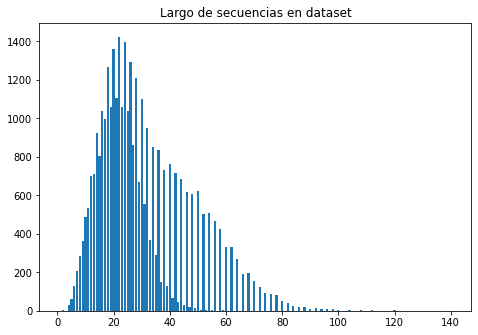

In [ ]:
import matplotlib.pyplot as plt

dicc = dict()
newValues = list()
for index, row in dff.iterrows():
    lenLemma = len(row["lemma"])
    newValues.append(lenLemma)
    if lenLemma not in dicc:
      dicc[lenLemma] = 0
    dicc[lenLemma] += 1

X = list()
Y = list()
for key,value in dicc.items():
  X.append(key)
  Y.append(value)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X,Y)
plt.title("Largo de secuencias en dataset")
plt.show()

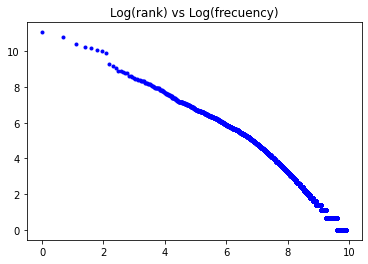

In [ ]:
dicc = dict()
for index, row in dff.iterrows():
    lemmas = row["lemma"]
    for lemma in lemmas:
      if lemma not in dicc:
        dicc[lemma] = 0
      dicc[lemma] += 1

newList = list()
for key,value in dicc.items():
    newList.append((value,key))

newList.sort(reverse=True)
X = list()
Y = list()
i = 1
for y,x in newList:
  X.append(np.log(i))
  Y.append(np.log(y))
  i+=1

plt.title("Log(rank) vs Log(frecuency)")
plt.plot(X,Y, "b.")
plt.show()


{1: 889973, 2: 37525, 3: 16392, 4: 17011, 5: 7409, 6: 20184, 7: 16537, 8: 20193, 9: 434, 10: 280, 11: 17382, 12: 229, 13: 6298, 14: 226, 15: 348, 16: 297, 17: 76}


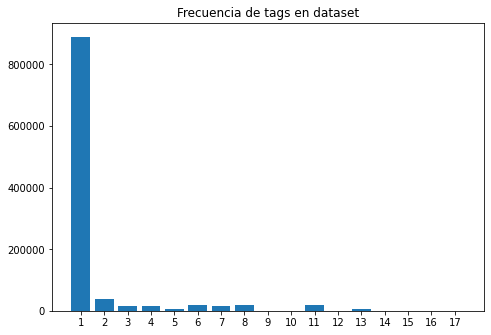

In [ ]:
dicc = dict()
for index, row in dff.iterrows():
    tags = row["tag"]
    for tag in tags:
      if tag not in dicc:
        dicc[tag] = 0
      dicc[tag] += 1

X = list()
Y = list()
print(dicc)
for key,value in dicc.items():
  X.append(key)
  Y.append(value)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(X)
ax.set_xticklabels(X)
ax.bar(X,Y)
plt.title("Frecuencia de tags en dataset")
plt.show()


## 2.c) Padding y one hot vectors


##### I) En esta parte de la tarea, deben lograr que todas las secuencias de lemmas (y los tags correspondientes) queden del mismo largo, es decir realizar padding. El padding debe realizarse con el valor 0, pueden escoger si realizarlo al comienzo de la secuencia o al final, expliquen su elección. Pueden utilizar la función keras.preprocessing.sequence.pad_sequences o escribir sus propios códigos. Elija un valor de maxlen que le parezca adecuado.

¿Opinan que es deseable utilizar el valor 0 como codificación de palabras que "no existen", o creen que es irrelevante por ejemplo que su valor sea 1?

Se eligió añadir el padding al final de la secuencia, debido a que estos representan "vacío", y dado que las secuencias poseen distinto largo, sería demasiado irregular que la red deba esperar una cantidad arbitraria de valores 0 antes de comenzar la secuencia como tal, además el padding al final se puede considerar como simplemente guardar silencio después de una oración.

El maxlen corresponde al largo de la secuencia más larga. También se pensó en reducirlo dado que son pocas las sentencias que llegan a esa cantidad de palabras, añadiendo así menos padding también, pero esto trae problemas relacionados a cortar frases, lo que podría hacer que pierdan el sentido.

Respecto a utilizar 0 o 1 para palabras que no existen, se cree que podrían asignarse a ambas categorías, ya que de todas maneras corresponden a elementos que no es prioridad que la red los aprenda a identificar, además de corresponder todos al mismo *lemma*, por lo que sería agregar una palabra más al *tag 'O'*, donde se encuentra una gran cantidad de palabrar que podrían ser añadidas a categorías nuevas, pero que se encuentran todas juntas debido a que no son el objetivo del dataset. 

In [ ]:
from keras.preprocessing.sequence import pad_sequences
dff['lemma'] = pad_sequences(dff.lemma, maxlen=140, padding='post', value=0).tolist()
dff['tag'] = pad_sequences(dff.tag, maxlen=140, padding='post', value=0).tolist()
print(dff[0:20])


                                                          lemma                                                tag
sentence_idx                                                                                                      
1.0           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, ...
2.0           [23, 2, 24, 25, 12, 10, 26, 27, 10, 9, 28, 29,...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
3.0           [42, 5, 19, 10, 43, 2, 44, 8, 45, 46, 12, 47, ...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 5, 1, 1, ...
4.0           [49, 50, 10, 37, 2, 51, 52, 53, 54, 55, 56, 57...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
5.0           [10, 9, 60, 61, 10, 62, 2, 10, 63, 64, 2, 65, ...  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 6, ...
6.0           [10, 69, 75, 76, 77, 65, 66, 78, 12, 10, 13, 2...  [1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...
7.0           [10, 7, 5, 82, 83, 2, 84, 9, 85, 12, 86, 87, 8...  [1, 2, 1, 1, 1,

##### II) Para poder entregar una clasificación sobre los distintos *tags* es necesario transformarlos a *one hot vectors*, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

y = np.asarray([to_categorical(i, num_classes=18) for i in dff.tag.to_numpy()])
X = np.asarray([np.asarray(i) for i in dff.lemma])
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
x_tr.shape,y_tr.shape,x_val.shape,y_val.shape

((26382, 140), (26382, 140, 18), (8795, 140), (8795, 140, 18))

Las dimensiones de entrada de cada conjunto corresponden a:

* Primera dimensión: Cantidad de registros del conjunto.
* Segunda dimensión: Largo de la secuencia (140 *lemmas*).

Las dimensiones de salida de cada conjunto corresponden a:
* Primera dimensión: Cantidad de registros del conjunto.
* Segunda dimensión: Largo de la secuencia (140 *lemmas*).
* Tercera dimensión: One-hot vector para cada *lemma* de la secuencia que establece a que categoría corresponde.

## 2.d) RNN many to many



##### I) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable des]de el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

#¿problemas con el embedding al ejecutar? chequear que el n_lemas, n_tags, y max_len correspondan a los datos modificados con padding
n_lemmas = 20244
n_tags = 18
max_len = 140
m = Sequential()
embedding_dim = 32
m.add(Embedding(input_dim=n_lemmas, output_dim=embedding_dim, input_length=max_len))
m.add(LSTM(units=128,return_sequences=True))
m.add(Dense(n_tags, activation='softmax'))
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
m.summary()
history = m.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 32)           647808    
_________________________________________________________________
lstm (LSTM)                  (None, 140, 128)          82432     
_________________________________________________________________
dense (Dense)                (None, 140, 18)           2322      
Total params: 732,562
Trainable params: 732,562
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
207/207 [==============================] - 13s 23ms/step - loss: 0.9336 - acc: 0.8347 - val_loss: 0.1917 - val_acc: 0.9658
Epoch 2/3
207/207 [==============================] - 4s 20ms/step - loss: 0.1771 - acc: 0.9665 - val_loss: 0.1220 - val_acc: 0.9680
Epoch 3/3
207/207 [==============================] - 4s 20ms/step - loss: 0.1099 - acc: 0.9698 - val_loss: 0.0869 -

In [ ]:
x_tr.shape

(26382, 140)

El input posee como dimensión 140 lemmas, que corresponde al largo de la secuencia. Una vez que pasa por la red, su dimensión pasa a ser de (140,32), donde 140 corresponden al largo de la secuencia mencionado anteriormente y 32 corresponde al *embedding_dim*.

El número de parámetros en la capa de embedding se obtiene a partir del cálculo:
\begin{align*}
 \text{n_lemmas} \cdot \text{embedding_dim} &= \text{N° parametros} \\
 32 \cdot 20244 &= 647808
\end{align*}
Por otro lado, el número de parámetros de una capa LSTM se calcula como:
\begin{align*}
 4 * ((\text{size_of_input} + 1) * \text{size_of_output} + \text{size_of_output}^2) &= \text{N° Parametros} \\
 4 \cdot ((32+1) \cdot 128+128^2) &= 82432
\end{align*}

El cálculo para la capa densa sería:
\begin{equation*}
  (128+1)*18 = 2322
\end{equation*}

Para evaluar su modelo utilice una métrica adecauda para el desbalance presente entre las clases.

In [ ]:
!pip install sklearn-crfsuite

     |████████████████████████████████| 747kB 6.2MB/s 


In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report
y_pred=m(x_val)
y_pred= np.argmax(y_pred, axis=2)
y_val2 = np.argmax(y_val, axis=2)
print(flat_classification_report(y_val2, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    970677
           1       0.95      1.00      0.97    220977
           2       0.38      0.76      0.51      9380
           3       0.00      0.00      0.00      4145
           4       0.71      0.00      0.00      4058
           5       0.41      0.08      0.13      1828
           6       0.00      0.00      0.00      5020
           7       0.10      0.00      0.01      4104
           8       0.73      0.02      0.03      5000
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.48      0.51      0.50      4134
          12       0.00      0.00      0.00        48
          13       0.00      0.00      0.00      1494
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        96
          16       0.00      0.00      0.00        83
          17       0.00    

##### II) Varı́e la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente.

In [ ]:
n_lemmas = 20244
n_tags = 18
max_len = 140
m = Sequential()
embedding_dim = 64
m.add(Embedding(input_dim=n_lemmas, output_dim=embedding_dim, input_length=max_len))
m.add(LSTM(units=128,return_sequences=True))
m.add(Dense(n_tags, activation='softmax'))
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = m.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

y_pred=m(x_val)
y_pred= np.argmax(y_pred, axis=2)
y_val2 = np.argmax(y_val, axis=2)
print(flat_classification_report(y_val2, y_pred))

Epoch 1/3
207/207 [==============================] - 122s 579ms/step - loss: 0.8396 - acc: 0.8466 - val_loss: 0.1770 - val_acc: 0.9673
Epoch 2/3
207/207 [==============================] - 122s 588ms/step - loss: 0.1585 - acc: 0.9673 - val_loss: 0.0995 - val_acc: 0.9723
Epoch 3/3
207/207 [==============================] - 123s 596ms/step - loss: 0.0924 - acc: 0.9735 - val_loss: 0.0768 - val_acc: 0.9778


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    970677
           1       0.95      1.00      0.97    220977
           2       0.45      0.82      0.59      9380
           3       0.85      0.25      0.38      4145
           4       0.59      0.03      0.06      4058
           5       0.62      0.05      0.08      1828
           6       0.79      0.01      0.03      5020
           7       0.36      0.21      0.26      4104
           8       0.89      0.23      0.37      5000
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.56      0.56      0.56      4134
          12       0.00      0.00      0.00        48
          13       0.00      0.00      0.00      1494
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        96
          16       0.00      0.00      0.00        83
          17       0.00    

In [ ]:
n_lemmas = 20244
n_tags = 18
max_len = 140
m = Sequential()
embedding_dim = 16
m.add(Embedding(input_dim=n_lemmas, output_dim=embedding_dim, input_length=max_len))
m.add(LSTM(units=128,return_sequences=True))
m.add(Dense(n_tags, activation='softmax'))
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = m.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

y_pred=m(x_val)
y_pred= np.argmax(y_pred, axis=2)
y_val2 = np.argmax(y_val, axis=2)
print(flat_classification_report(y_val2, y_pred))

Epoch 1/3
207/207 [==============================] - 114s 539ms/step - loss: 0.9864 - acc: 0.8237 - val_loss: 0.2160 - val_acc: 0.9612
Epoch 2/3
207/207 [==============================] - 110s 534ms/step - loss: 0.2019 - acc: 0.9643 - val_loss: 0.1642 - val_acc: 0.9674
Epoch 3/3
207/207 [==============================] - 112s 541ms/step - loss: 0.1535 - acc: 0.9668 - val_loss: 0.1087 - val_acc: 0.9693


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    970677
           1       0.89      1.00      0.94    220977
           2       0.31      0.23      0.27      9380
           3       0.00      0.00      0.00      4145
           4       0.38      0.00      0.00      4058
           5       0.00      0.00      0.00      1828
           6       0.00      0.00      0.00      5020
           7       0.00      0.00      0.00      4104
           8       0.43      0.01      0.02      5000
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.45      0.01      0.03      4134
          12       0.00      0.00      0.00        48
          13       0.00      0.00      0.00      1494
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        96
          16       0.00      0.00      0.00        83
          17       0.00    

Se probó con embeddings iguales a 64 y 16, teniendo como embedding original 32. Si bien no se puede notar mucha diferencia respecto a las tres redes si se ve el *weighted avg*, el *macro avg* mejora considerablementa al aumentar la dimensión del embedding. De todas maneras se destaca que la red con dimensión de embedding igual a 64 obtiene la mayor *accuracy* y el mayor *weighted avg* para la métrica *precision* y *recall*.

## 2.e) RNN Bidireccional y masking


##### I) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen.**Mejore la red definida en 2.d.I) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro *merge_mode*** (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. **¿Mejora o empeora el desempeño?** Analice.

El parámetro `merge_mode` debería ser concatenar, ya que con este se concatena el output de ambas LSTM de forma *element wise*, considerando así el output de las palabras tanto anteriores como posteriores. 

Los resultados mejoraron respecto a la red implementada en 2.d.I), esto se puede ver evidenciado especialmente en el `macro avg` el cual mejora sustancialmente, teniendo desempeños similares, pero peores a una red con un `embedding_dim` igual a 64.

In [ ]:
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

embedding_dim = 32
n_lemmas = 20244
max_len = 140
n_labels = 18

model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_dim, input_length=max_len))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode="concat"))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 140, 32)           647808    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 200)          106400    
_________________________________________________________________
dense (Dense)                (None, 140, 18)           3618      
Total params: 757,826
Trainable params: 757,826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
207/207 [==============================] - 124s 585ms/step - loss: 0.8237 - acc: 0.8625 - val_loss: 0.1679 - val_acc: 0.9661
Epoch 2/3
207/207 [==============================] - 122s 591ms/step - loss: 0.1649 - acc: 0.9660 - val_loss: 0.1177 - val_acc: 0.9681
Epoch 3/3
207/207 [==============================] - 124s 597ms/step - loss: 0.1020 - acc: 0.9712 - val_loss

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report
y_pred=model(x_val)
y_pred= np.argmax(y_pred, axis=2)
y_val2 = np.argmax(y_val, axis=2)
print(flat_classification_report(y_val2, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    970677
           1       0.95      1.00      0.97    220977
           2       0.41      0.77      0.54      9380
           3       0.79      0.03      0.06      4145
           4       0.43      0.51      0.47      4058
           5       0.52      0.02      0.04      1828
           6       0.36      0.03      0.05      5020
           7       0.34      0.04      0.07      4104
           8       0.32      0.01      0.03      5000
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.59      0.69      0.64      4134
          12       0.00      0.00      0.00        48
          13       0.00      0.00      0.00      1494
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        96
          16       0.00      0.00      0.00        83
          17       0.00    

Respecto a las transformaciones, para la capa de embedding, ocurre lo mismo que en el ejercicio anterior, la cual se calcula como:

\begin{align*}
 \text{n_lemmas} \cdot \text{embedding_dim} &= \text{N° parametros} \\
 32 \cdot 20244 &= 647808
\end{align*}

Para el cálculo de la capa densa es:
El cálculo para la capa densa sería:
\begin{equation*}
  (200+1)*18 = 3618
\end{equation*}

##### II) Recientemente se ha implementado la capa de *Masking* en las redes recurrentes en *keras*, lo cual podría traer gran ayuda gracias al *padding* que se realiza con el símbolo especial definido. Entrene la red definida en 2.d.I) y compare al utilizar esta funcionalidad de enmascarar el valor 0  en este caso para el default de la capa embedding.


In [ ]:

n_lemmas = 20244
n_tags = 18
max_len = 140
m = Sequential()
embedding_dim = 32
m.add(Embedding(input_dim=n_lemmas, output_dim=embedding_dim, input_length=max_len, mask_zero=True))
m.add(LSTM(units=128,return_sequences=True))
m.add(Dense(n_tags, activation='softmax'))
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = m.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Epoch 1/3
207/207 [==============================] - 125s 584ms/step - loss: 0.2843 - acc: 0.8225 - val_loss: 0.1017 - val_acc: 0.8595
Epoch 2/3
207/207 [==============================] - 119s 574ms/step - loss: 0.0929 - acc: 0.8745 - val_loss: 0.0779 - val_acc: 0.8966
Epoch 3/3
207/207 [==============================] - 122s 588ms/step - loss: 0.0744 - acc: 0.9008 - val_loss: 0.0667 - val_acc: 0.9111


In [ ]:
y_pred=m(x_val)
y_pred= np.argmax(y_pred, axis=2)
y_val2 = np.argmax(y_val, axis=2)
print(flat_classification_report(y_val2, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    970677
           1       0.18      1.00      0.31    220977
           2       0.49      0.80      0.61      9380
           3       0.76      0.16      0.26      4145
           4       0.73      0.23      0.35      4058
           5       0.47      0.51      0.49      1828
           6       0.46      0.01      0.03      5020
           7       0.38      0.05      0.10      4104
           8       0.86      0.68      0.76      5000
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.51      0.82      0.63      4134
          12       0.00      0.00      0.00        48
          13       0.81      0.30      0.43      1494
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        96
          16       0.00      0.00      0.00        83
          17       0.00    

Como se puede ver con las métricas obtenidas, estas presentan un desempeño mucho menor que cualquiera de las obtenidas con anterioridad si miramos el resultado general, lo que dejaría en evidencia que en nuestro caso, enmascarar el valor 0 no mejoría el desempeño de la red. Sin embargo esto se debe a que las métricas no consideran que se enmascaró el *tag 0*, por lo que *precision*, *recall* y *f1-score* son 0, afectando negativamente el reporte. Pero si se mira el *macro avg* o bien las métricas por cada categoría de forma individual, presenta buenos resultados comparables con la red bidireccional o la red con `embedding_dim` igual a 64.

## 2.f) Mejora libre

En base a lo experimentado, **intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras. Utilice la red entrenada, **se espera que sea la mejor de esta sección**, y **muestre las predicciones**, el *NER tager*, sobre algún ejemplo de pruebas, comente.

In [ ]:
embedding_dim = 64
n_lemmas = 20244
max_len = 140
n_labels = 18

model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_dim, input_length=max_len))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode="concat"))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 140, 64)           1295616   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 140, 200)          132000    
_________________________________________________________________
dense_12 (Dense)             (None, 140, 18)           3618      
Total params: 1,431,234
Trainable params: 1,431,234
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
207/207 [==============================] - 159s 753ms/step - loss: 0.7592 - acc: 0.8523 - val_loss: 0.1569 - val_acc: 0.9667
Epoch 2/3
207/207 [==============================] - 155s 751ms/step - loss: 0.1394 - acc: 0.9672 - val_loss: 0.0843 - val_acc: 0.9754
Epoch 3/3
207/207 [==============================] - 155s 749ms/step - loss: 0.0745 - acc: 0.9780 - val

In [ ]:
y_pred=model(x_val)
y_pred= np.argmax(y_pred, axis=2)
y_val2 = np.argmax(y_val, axis=2)
print(flat_classification_report(y_val2, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    970677
           1       0.96      0.99      0.98    220977
           2       0.73      0.82      0.78      9380
           3       0.86      0.79      0.82      4145
           4       0.64      0.52      0.57      4058
           5       0.69      0.34      0.45      1828
           6       0.62      0.32      0.42      5020
           7       0.57      0.16      0.25      4104
           8       0.86      0.74      0.80      5000
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.72      0.76      0.74      4134
          12       0.00      0.00      0.00        48
          13       0.79      0.06      0.11      1494
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        96
          16       0.00      0.00      0.00        83
          17       0.00    

In [ ]:
tags = list(set(dataset["tag"].values))
Reverse_lemmas = {value : key for (key, value) in lemma_to_code.items()}
Reverse_tags = {value : key for (key, value) in tag_to_code.items()}
p = y_pred
print("{:15} {:5}: ({})".format("Lemma", "Pred", "True"))
print("="*30)
for w, pred, true in zip(x_val[3], p[3], y_val[3]):
  true = np.argmax(true)
  if w != 0:
    print("{:15}:{:5} ({})".format(Reverse_lemmas[w], Reverse_tags[tags[pred-1]], Reverse_tags[tags[true-1]]))

Lemma           Pred : (True)
sajida         :O     (B-org)
mubarak        :B-per (B-per)
al-rishawi     :O     (B-org)
was            :O     (O)
captur         :O     (O)
when           :O     (O)
her            :O     (O)
explos         :O     (O)
belt           :O     (O)
fail           :O     (O)
to             :O     (O)
deton          :O     (O)
dure           :O     (O)
the            :O     (O)
suicid         :O     (O)
attack         :O     (O)
at             :O     (O)
three          :O     (O)
hotel          :O     (O)
on             :O     (O)
novemb         :B-tim (B-tim)
9              :I-tim (I-tim)
.              :O     (O)


Se decidió usar una red bidireccional ya que dió buenos resultados pero aumentando el `embedding_dim` a 64 debido a su mejor desempeño en el caso de las redes de la pregunta 2.d), pero se decidió omitir el *Masking* por la menor claridad de las métricas entregadas. Con esto se ha obtenido un `accuracy` mejor que el resto de las redes, mientras que el `magro avg` obtienendo el mayor rendimiento en las tres métricas (precision, recall y accuracy). Por último, respecto a las métricas de `weighted avg`, estas presentan valores mayores o iguales a las redes anteriores.

Se puede ver en un ejemplo de *NER Tager* con el cuarto ejemplo que clasifica sin problemas los lemas cuya clase es "O", lo que es de esperar ya que la mayoría de palabras es clasificada en este tag. Respecto a los demás tags que aparecen con menor frecuencia, acierta mucho menos, lo que se puede deber justamente a que las clases no están balanceadas.

## 2.g) Escribamos palabras


##### I) Ahora buscaremos otra aplicación a las redes recurrentes, predecir el caracter siguiente. Si logramos entrenar una red que sea buena en esta tarea, podremos escribir texto automáticamente, pues podemos, a partir de una frase, predecir el caracter siguiente, y luego introducir la nueva frase sin el primer caracter en la red nuevamente, e iterando así escribir automáticamente. Si bien las redes recurrentes son adecuadas para esta tarea, no pretendemos entrenar un Shakespeare en esta tarea, sin embargo es interesante investigar qué tan verosimil o no puede lograr ser el texto generado.

Para esto, primero crearmos nuestro nuevo dataset. Para esta tarea preferiremos unir todas las frases en un solo gran corpus y luego crear nuevas secuencias semi redundantes. Esto nos evita primero el problema de tener que hacer padding, pues crearemos todas las entradas iguales, pero también nos permite aprovechar mejor el dataset, de cierta forma aumentando el número de datos. El target en este caso será solo el caracter siguiente correspondiente a cada secuencia.

En este item debe cargar el dataset. **Explique lo que hace el código entregado**

In [ ]:
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical

# Elimina las filas que poseen "NaN"
df_w = pd.read_csv(os.path.join("ner.csv"), engine='python', error_bad_lines=False)
df_w = df_w.dropna()[['word']]

# Realiza un cuerpo de texto, con la union de las palabras del dataset
corpus = ' '.join(list(df_w.word.values)).lower()
sentence_length = 40
steps = 5

# Crea un arreglo de sentencias, las cuales corresponden a cadena de palabras de largo sentence_length
# Por otro lado, crea un arreglo de next_char el cual corresponde al siguiente caracter de la sentencia asociada
sentences = []
next_char = []
for i in range(0,len(corpus) - sentence_length - 1 , steps):
  sentences.append(corpus[i:sentence_length+i])
  next_char.append(corpus[sentence_length+i])

# Crea un diccionario chars_to_code, donde la llave es un caracter y el valor un indice único
# Crea un diccionario code_to_chars, donde es el mismo diccionario anterior con las llaves y valor invertidas
chars_to_code = {char:code for code, char in enumerate(set(corpus))}
code_to_chars = {code:char for char,code in chars_to_code.items()}
x = np.array([[chars_to_code[char] for char in sentence] for sentence in sentences]) # Crea un arreglo donde se mapean los caracteres de una sentencia a número
y = np.array([chars_to_code[char] for char in next_char]) #Crea un arreglo donde se mapean cada siguiente caracter de la secuencia a numero
y = to_categorical(y)

Skipping line 281837: Expected 25 fields in line 281837, saw 34


['thousands of demonstrators have marched ', 'ands of demonstrators have marched throu', 'of demonstrators have marched through lo', 'monstrators have marched through london ', 'rators have marched through london to pr']
['t', 'g', 'n', 't', 'o']


##### II) Entrene ahora una red con estos datos utilizando GRU. El resto de la estructura queda a su elección. Evalúe el desempeño de su red evaluando qué tan bien genera texto, puede utilizar las funciones propuestas como callback para ver como progresa su red. Pruebe a lo menos 2 estructuras distintas.

Una vez esté satisfecho de su red, hágala escribir algunos textos a partir de textos semilla elegidos por usted. Describa sus observaciones. ¿Qué cree ocurriría si entrenamos la red con otro dataset?

In [ ]:
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.callbacks import LambdaCallback
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
import sys

def predict_char(model, sentence):
    x = [chars_to_code[char] for char in sentence]
    x = pad_sequences([x], maxlen=sentence_length, padding='pre', value=0)
    probas = model.predict(x)[0]
    next_index = np.random.choice(len(chars_to_code), p=probas)
    return code_to_chars[next_index]

def on_epoch_end(epoch, logs):
    print(f'\n Generating random text for epoch: {epoch}')
    start_index = random.randint(0,x.shape[0]-1)
    sentence = ''.join([code_to_chars[code] for code in x[start_index]])
    print('\n Generating with seed: ' + sentence)
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_char(character, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

print_text_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
#Primera
character = Sequential()
embedding_dim = 100
character.add(Embedding(input_dim=y.shape[1], output_dim=embedding_dim, input_length=x.shape[1]))
character.add(GRU(128,return_sequences=False))
character.add(Dense(y.shape[1],activation='softmax'))
optimizer = RMSprop(lr = 0.01)
character.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["acc"])
character.fit(x,y, epochs=4, batch_size = 512,callbacks=[print_text_callback])
character.summary()

Epoch 1/4
2371/2371 [==============================] - 829s 349ms/step - loss: 1.8631 - acc: 0.4546

 Generating random text for epoch: 0

 Generating with seed: l nadal of spain has withdrawn from the 
l nadal of spain has withdrawn from the saugnarytony . supplim or peris sign sunning . later soliducion fall . nitermateim . downing chain coinations . host passing outatish 2003 withs clashed thb charge chinates , brai offvicogabim . his years sunge tra has morth chinabe day riblart african curninue gilitary after counted thisura , nations since down colbs coining usices south counts disrappices righting quartrael . sunday thrad caspleEpoch 2/4
2371/2371 [==============================] - 838s 353ms/step - loss: 1.6152 - acc: 0.5217

 Generating random text for epoch: 1

 Generating with seed:  , including a sunni cleric . police say
 , including a sunni cleric . police says the ministed alajuse , ach pasted . the state have cupan by make hommyary that coomitains . the copanistry . the

In [ ]:
#Segunda
character = Sequential()
embedding_dim = 100
character.add(Embedding(input_dim=y.shape[1], output_dim=embedding_dim, input_length=x.shape[1]))
character.add(GRU(128,return_sequences=True))
character.add(GRU(128,return_sequences=False))
character.add(Dense(100,activation='sigmoid'))
character.add(Dense(y.shape[1],activation='softmax'))
optimizer = RMSprop(lr = 0.01)
character.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["acc"])
character.fit(x,y, epochs=4, batch_size = 512,callbacks=[print_text_callback])
character.summary()

Epoch 1/4
2371/2371 [==============================] - 1741s 733ms/step - loss: 2.0959 - acc: 0.3860

 Generating random text for epoch: 0

 Generating with seed: egroponte has singled out venezuelan pre
egroponte has singled out venezuelan previciled togral government canued as top aulvang and satnger pounth . the coclome has bore 25 1949d palled trigncenced kugper 1,,000000.000 . and wisits tilging abgatia in and womants an and stateves balying to cuilding from the was secrecicilly finans cond train maddelans have crocts officials aundaillu mankreed byinated palricate of the united bitalia . hend mr. teadelly wittion guutt suspeania aEpoch 2/4
2371/2371 [==============================] - 1731s 730ms/step - loss: 1.6738 - acc: 0.4984

 Generating random text for epoch: 1

 Generating with seed: that the workers party paid $ 12,000 a m
that the workers party paid $ 12,000 a mirdting killed afaplos annit outsing outby duman the esfoh militinitaliness in ittan by that . its in the blans 

In [ ]:
sentence = "turrones"
for i in range(400):
        next_char = predict_char(character, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()

pours and norks ours on reant duspinist thit have several out tribus in near of the north for and hit outs while 's provinciand-ormed dure . the isny jont plannect for the tragio orating caurt or mistans cuths next . me chingation symfed this oumer orbank out nearly 156 mani anduction arrihsarges orded not new orsing stationslant of thounal . an okn los of necates of they country or into and hours

Se decidió generar dos arquitecturas. La primera posee una capa GRU y una densa, mientras que la segunda dos de cada una. Cada una se entreno por 4 epochs debido al tiempo que consume entrenarlas. Es difícil evidenciar si la red progresa de una epoch a otra ya que la mayoría de los resultados carece de sentido. Sin embargo, la segunda red parece más capaz de generar palabras (o conjuntos de letras similares a palabras) y frases cortas.

El ejemplo con la sentencia "turrones" de la segunda arquitectura parece ser capaz de generar varias palabras y pequeñas frases con sentido gramatical.

Al entrenar la red con otro dataset probablemente se generarían textos diferentes, conjugando de forma distinta las palabras, e incluso generando otro tipo de pequeñas frases, dependiendo del tipo de textos que contenga el nuevo dataset.

# 3. Autoencoders en Fashion MNIST

Si bien las redes neuronales han tenido desempeños sorprendentes en muchas áreas donde antes solo un ser humano podía alcanzar buenos desempeños, uno de sus desventajas suele serla alta dimensionalidad de los espacios de hipótesis. En la práctica, esto implica que para aprender una tarea predictiva con alguna capacidad de generalización, se requieren grandes bases de datos etiquetadas. Esto implica un problema, considerando que al momento de buscar la base de datos, no se tiene a priori una manera de automatizar esta etiquetación. Esta necesidad de gran cantidad de trabajo de clasificación realizado por humanos, ha engendrado soluciones ingeniosas, como la aproximación de _Facebook_ hace algunos años de pedirle a los mismos usuarios que etiquetaran a las personas en sus fotos, o la solución de _Amazon_, _Mechanical Turk_, donde cualquier usuario puede realizar tareas repetitivas de clasificación a cambio de dinero real, o por otro lado cualquier persona puede comprar la etiquetación de una base de datos la cual realizan varias personas en cualquier parte del mundo. 

Otra aproximación, quizás aún más ingeniosa, para solucionar el problema de las etiquetas, es utilizar las bases de datos sin preocuparse de sus etiquetas. Esta aproximación de aprendizaje no supervisado tiene su representante en redes neuronales en los _Autoencoders_, redes que utilizan el mismo input como target y buscan representaciones de menor dimensionalidad al interior de la red. Estas redes han permitido el uso de cantidades masivas de datos para aprender de ellos sin necesidad de tener etiquetas. Durante esta pregunta veremos algunos de los aspectos y posibilidades básicas que nos presentan los _autoencoders_, utilizando una base de datos de imágenes de articulos de vestimenta, el Fashion MNIST. 

## 3.a) Carga de datos y visualizaciones
Cargue los datos. Puede user las funciones de `keras.datasets` como muestra el código o descargarlo manualmente. 

Luego, visualice algunas imagenes de cada una de las catégorias junto con sus nombres (investigue un poco para encontrar la codificación de `y`). Note que las imagenes deben representarse en blanco y negro, puede usar `cmap='Greys'`. ¿Qué pares de categorías cree podrían ocasionar problemas al momento de clasificación? ¿Qué tan bien cree que se desempeñaría un humano en esta tarea?

La codificación es la siguiente:

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot

Las categorías que podrían causar problemas serían:

* T-shirt/top y Dress 
* Pullover, Shirt y Coat
* Ankle Boot y Sneaker

Un humano que conozca de antemano estos tipos de prenda no tendría ningún problema en clasificarlas, ya que, por nuestra parte estamos inseguros al momento de distinguir entre Shirt y T-shirt/Top, pero luego de ver algunos ejemplos seríamos capaces de identificarlas sin problemas.

In [ ]:
from keras.datasets import fashion_mnist
(x_tr,y_tr),(x_val,y_val) = fashion_mnist.load_data()



4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
x_tr.shape, y_tr.shape, x_val.shape, y_val.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

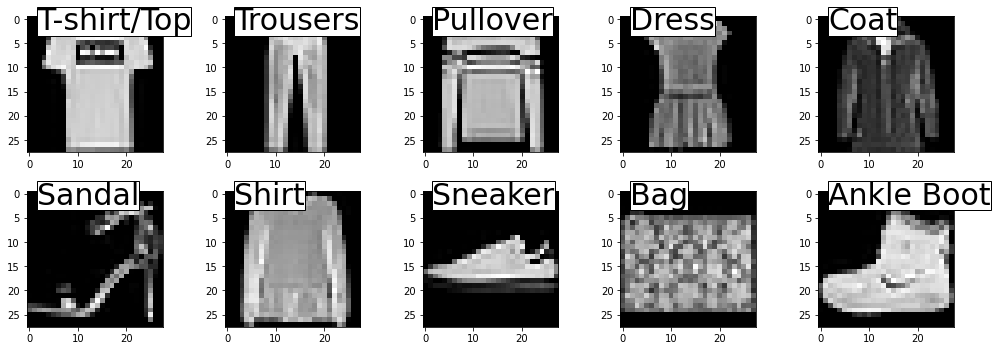

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
plt.rcParams["figure.figsize"]=[14,5]
clothes=["T-shirt/Top","Trousers","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle Boot"]
fig, axs = plt.subplots(2,5)
axs = axs.flatten()

for i,ax in enumerate(axs):
  clothes_index = i
  ax.imshow(x_tr[np.where(y_tr==clothes_index)[0][0],:,:], cmap = "gray") # arreglar error 
  ax.text(1.5, 2.2, clothes[i], bbox={'facecolor': 'white', 'pad': 0},fontsize=30)

plt.tight_layout()
plt.show()

## 3.b Posibilidades de preprocesamiento y pequeños análisis. 

Las primeras redes que entrenaremos utilizarán arquitecturas _fully connected_, por lo cual también es necesario transformar nuestras imagenes 2-dimensionales a vectores, como muestra el ejemplo de código.

**Preguntas:**

i) ¿Cuáles son los rangos de valores de `x`? ¿Por qué?

ii) ¿Las distintas clases de ejemplos están balanceadas?

iii) ¿Considera necesario realizar un preprocesamiento? Escale los valores de `x` al intervalo $[0,1]$, y guarde el conjunto de datos original de igual manera que el escalado. ¿Se pierde información al realizar este preprocesamiento? 


i) Los valores de `x` se encuentran en el rango $[0, 255]$ debido a que corresponden a píxeles de una imagen que se encuentra en escala de grises.

ii) Las clases se encuentran perfectamente balanceadas, tanto para el conjunto de validación como de entrenamiento.

iii) Puede ser necesario para normalizar la data, lo que, como se ha visto con anterioridad, mejora los resultados producidos por las redes. Si se pierde información al realizar este preprocesamiento ya que la mínima fracción $\frac{1}{255}$ es un número con infinitos decimales.


{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


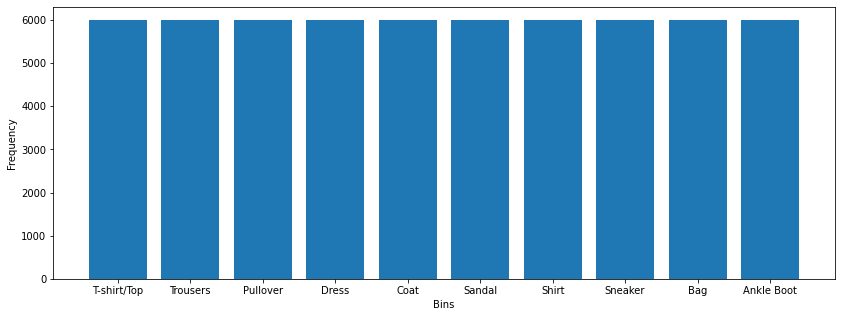

{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


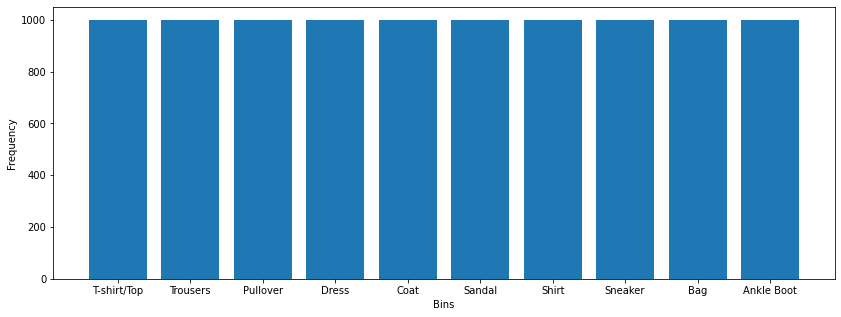

In [ ]:
x_tr_vector = x_tr.reshape(-1,28*28)
x_val_vector = x_val.reshape(-1,28*28)
x_train_vector_scaled = x_tr_vector/255
x_val_vector_scaled = x_val_vector/255

def print_frecuency(y_set):
  unique, counts = np.unique(y_set, return_counts=True)
  d = dict(zip(unique, counts))
  print(d)
  y = list()
  for key, valor in d.items():
    y.append(valor)

  plt.bar(clothes,y,align='center')
  plt.xlabel('Bins')
  plt.ylabel('Frequency')
  plt.show()

print_frecuency(y_tr)
print_frecuency(y_val)

## 3.c) Primer Autoencoder

Entrenaremos un primer autoencoder de una capa oculta, usando arquitectura densa. Para esto, utilize como guía los códigos presentados abajo. 

Utilice en primera instancia su conjunto de datos escalados. Considerando el intervalo de los datos escalados.

Entrene esta primera red utilizando pérdida _binary cross entropy_. Compare luego las imagenes originales con las imagenes reconstruidas, como muestra el código. **Grafique** como varia la pérdida a lo largo del entrenamiento y visualice algunas imagenes reconstruidas. 

**Preguntas:**

i) ¿Qué función de activación correspondería a la capa de salida de la red? ¿Debería afectar la elección de la función de activación de la capa oculta? 

ii) ¿Qué le parece el desempeño de la red, logra aprender la tarea en su opinion?

i) Según la investigación realizada, la mayoría de autoencoders utiliza función de activación sigmoidal para la salida de la red, además esta tiene como output el rango $[0, 1]$, que es el que estamos buscando. La función de activación de la capa de salida no debería afectar a las funciones de la capa oculta y se encontró que ReLU daba buenos resultados, por lo que se ocupa esta para la capa oculta.

**Fuente principal**: https://www.researchgate.net/post/Should-the-output-function-for-outer-layer-and-activation-function-of-hidden-layer-in-auto-encoder-be-same

ii) Según el error, el desempeño de la red es decente, ya que en ambos conjuntos al final del entrenamiento presenta errores menores a 0.5. Si ahora nos fijamos en las imágenes mostradas, se puede ver como las imagenes producidas intentan presentar siluetas similares a la imagen real, pero se siguien presentando como manchas y la mayoría de casos parecieran ser pantalones. 

Epoch 1/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6952 - val_loss: 0.6929
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6923 - val_loss: 0.6906
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6901 - val_loss: 0.6883
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6875 - val_loss: 0.6851
Epoch 5/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6840 - val_loss: 0.6805
Epoch 6/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6789 - val_loss: 0.6737
Epoch 7/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6715 - val_loss: 0.6640
Epoch 8/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6609 - val_loss: 0.6506
Epoch 9/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6465 - val_loss: 0.6335
Epoch 10/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.628

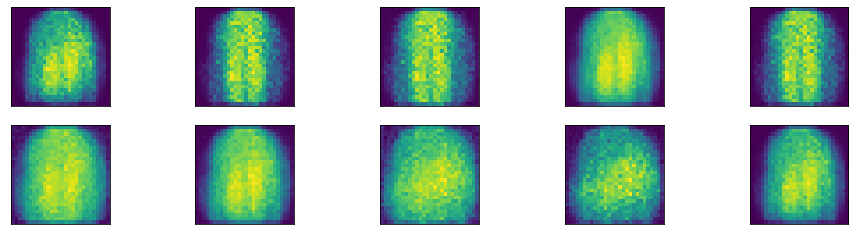

In [ ]:
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import Sequential

autoencoder = Sequential()

autoencoder.add(Dense(32,activation='relu')) # encoder
 
autoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder

autoencoder.compile(optimizer=SGD(lr=0.002),loss='binary_crossentropy')
history = autoencoder.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled))

plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(5):
  for v in range(2):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(autoencoder.predict(x_val_vector_scaled)[ix].reshape(28,28))
    ix += 1
plt.show()

In [ ]:
plt.rcParams["figure.figsize"]=[16,3]
def graph_results_alone_notest(hist,title):
  plt.title(title)
  plt.plot(hist.history["loss"],"b-",label="Train_loss")
  plt.plot(hist.history["val_loss"],"g-",label="Val_loss")
  plt.xlabel("Epochs"),plt.ylabel("Error")
  plt.legend(),plt.grid()
  plt.show()
  plt.tight_layout()
  plt.show()

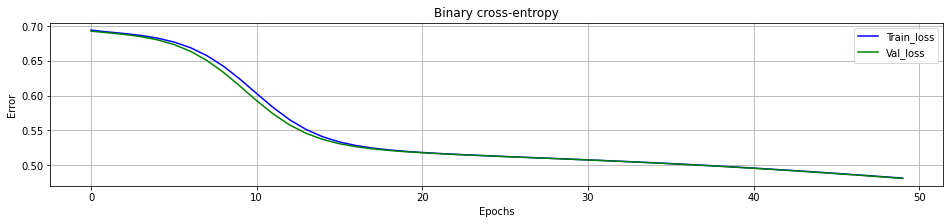

<Figure size 1152x216 with 0 Axes>

In [ ]:
graph_results_alone_notest(history, "Binary cross-entropy")

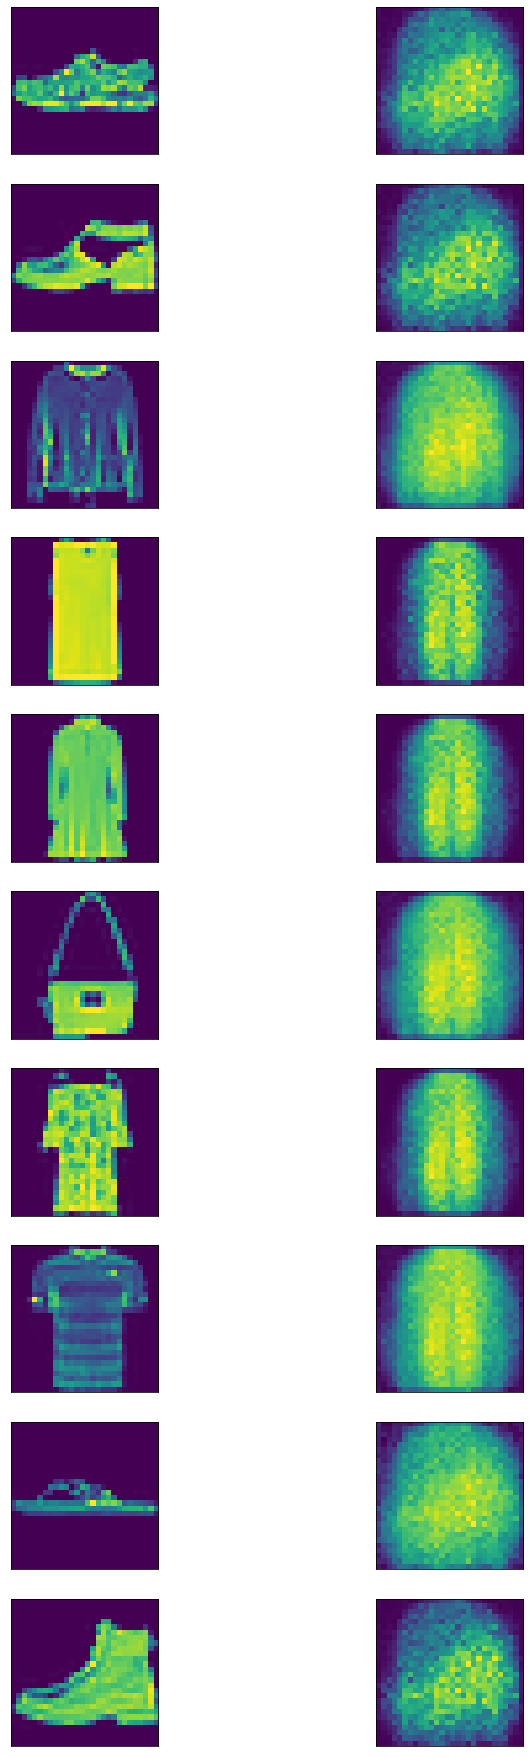

In [ ]:
plt.rcParams["figure.figsize"]=[12,32]
ix = 1
for u in range(10):
  ax = plt.subplot(10,2,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(x_val_vector_scaled[ix+20].reshape(28,28))
  ax = plt.subplot(10,2,ix+1)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(autoencoder.predict(x_val_vector_scaled)[ix+20].reshape(28,28))
  ix += 2
plt.show()


## 3.d) Dimensionalidad

Una forma de interpretar lo que realiza el autoencoder, es considerar que si el autoencoder hace bien su tarea, la información necesaria para reconstruir la imagen original se encuentra en la capa oculta, la cual tiene menor dimensionalidad que la imagen original. Uno puede considerar por lo tanto que la capa de _encoding_ esta comprimiendo la información contenida en la imagen, mientras la capa de _decoding_ hace el proceso contrario, descomprimiendola a su estado original lo mejor posible. 

Explore como cambia el desempeño de la red en cuestión frente a cambios en la dimensión de la capa oculta. Pruebe a lo menos 5 niveles de compresión distintos, incluyendo uno donde la capa oculta tenga $50\%$ de ratio de compresión y otro donde la capa oculta tenga tan solo 2 neuronas. ¿Qué observa?

A medida que el ratio de compresión disminuye se puede observar que se forman siluetas mucho más definidas en las imágenes. Por otro lado, se ve que no existe mucha diferencia de desempeño en las imágenes desde 392 hacia arriba, por lo que no es necesario manejar imágenes con un ratio de compresión menor.

Cantidad neuronas: 2
N° Epochs:50, Loss: 0.5039321184158325, Val Loss: 0.5039137005805969


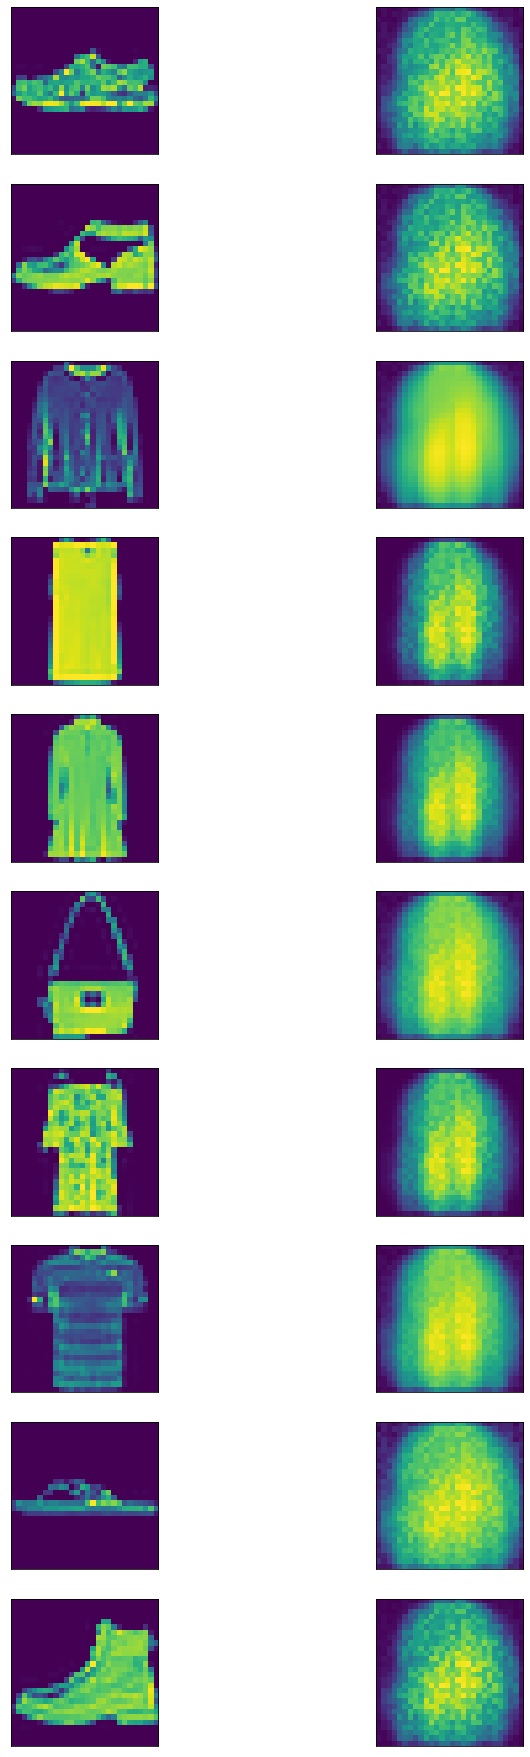

-------------------------------------
Cantidad neuronas: 32
N° Epochs:50, Loss: 0.48972180485725403, Val Loss: 0.48949095606803894


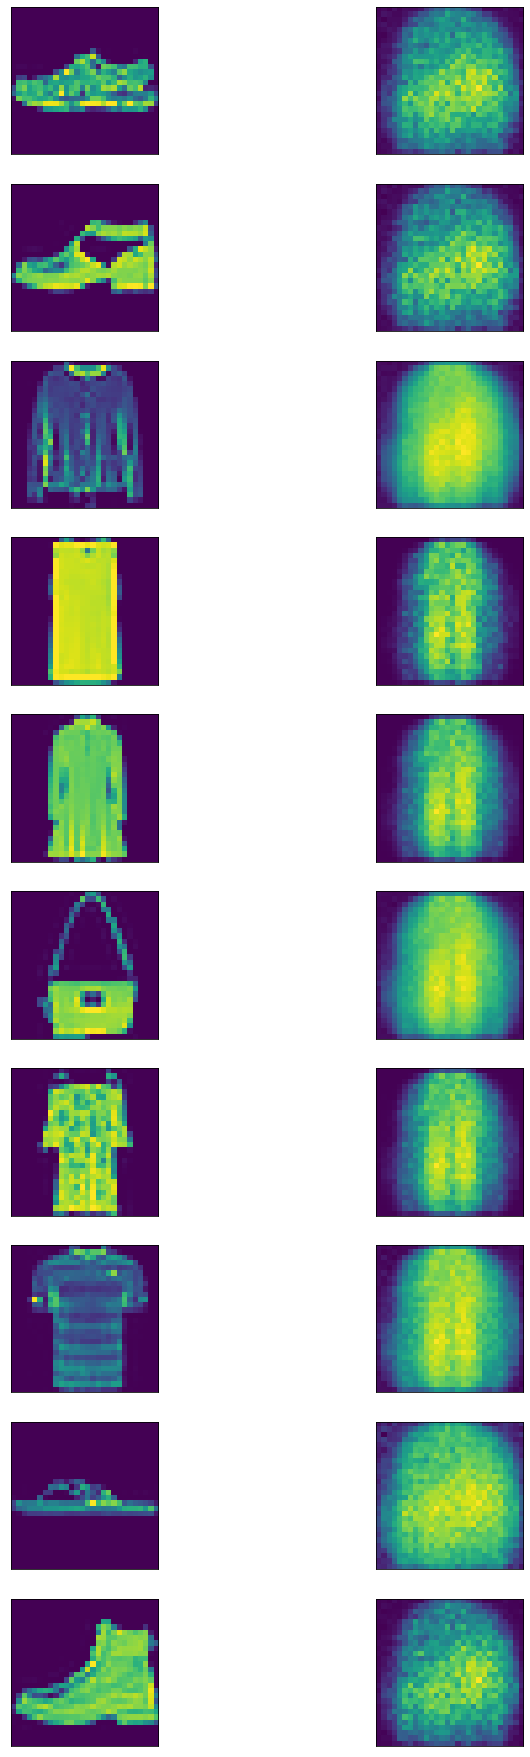

-------------------------------------
Cantidad neuronas: 392
N° Epochs:50, Loss: 0.4303402006626129, Val Loss: 0.4303770363330841


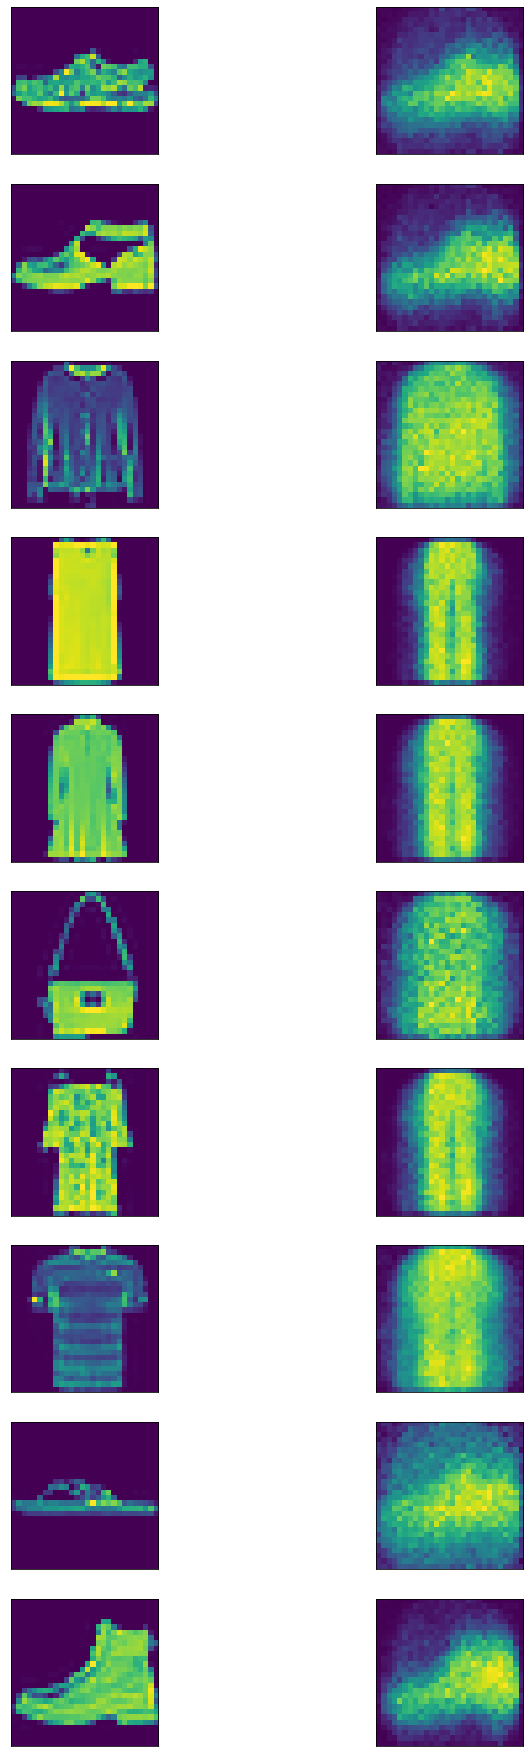

-------------------------------------
Cantidad neuronas: 588
N° Epochs:50, Loss: 0.42793089151382446, Val Loss: 0.42797765135765076


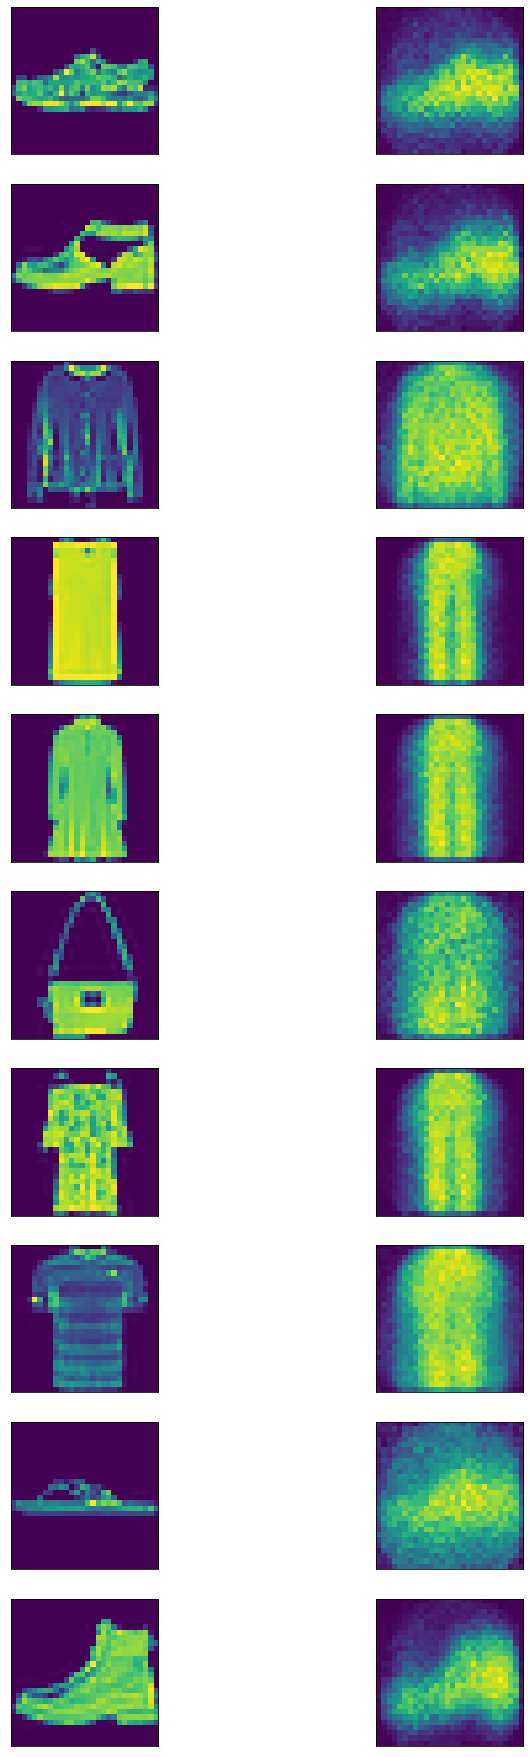

-------------------------------------
Cantidad neuronas: 784
N° Epochs:50, Loss: 0.4209856390953064, Val Loss: 0.4211882948875427


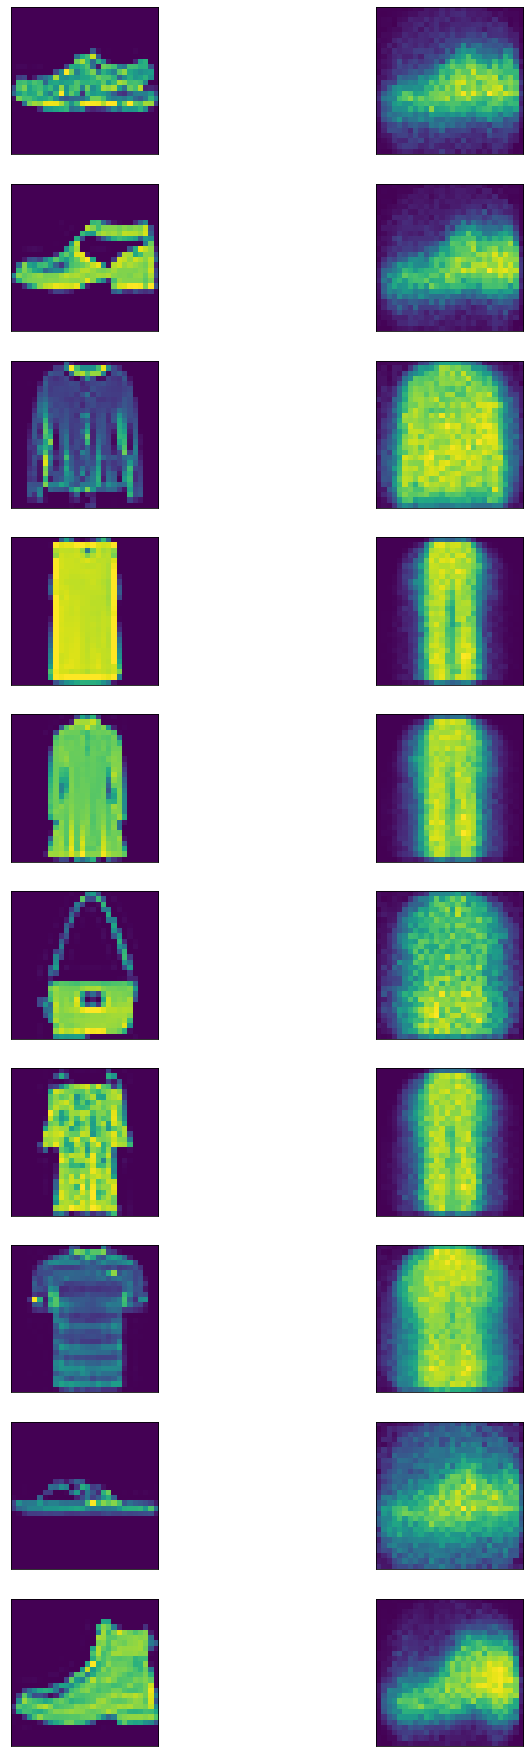

-------------------------------------


In [ ]:
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import Sequential

compression = [2, 32, 392, 588, 784] #2,  96%, 50%, 25%, 0%

for i in compression:
  autoencoder = Sequential()

  autoencoder.add(Dense(i,activation='relu')) # encoder
  
  autoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder

  autoencoder.compile(optimizer=SGD(lr=0.002),loss='binary_crossentropy')
  history = autoencoder.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled), verbose=False)

  plt.rcParams["figure.figsize"]=[12,32]
  ix = 1
  print("Cantidad neuronas: " + str(i))
  print("N° Epochs:{0}, Loss: {1}, Val Loss: {2}".format(len(history.history["loss"]), history.history["loss"][-1], history.history["val_loss"][-1]))
  for u in range(10):
    ax = plt.subplot(10,2,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(x_val_vector_scaled[ix+20].reshape(28,28))
    ax = plt.subplot(10,2,ix+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(autoencoder.predict(x_val_vector_scaled)[ix+20].reshape(28,28))
    ix += 2
  plt.show()
  print("-------------------------------------")

## 3.e) Deep autoencoder

Pruebe ahora con una arquitectura ligeramente más profunda. Para esto utilice a lo menos 3 capas de encoding, es decir, 3 capas que progresivamente reduzcan la dimensionalidad de la representación hasta una dimensión objetivo inicialmente igual a la mejor obtenida en la pregunta anterior. Utilice igualmente a lo menos 2 capas de decoding, que se encarguen de aumentar la dimensionaliad de la representación hasta alcanzar la dimensión de la imagen original. Note que las primeras capas no necesariamente deben tener menor dimensionalidad que la imagen, la dimensión relevante es aquella de la última capa de encoding. 

Una vez esté satisfecho con su arquitectura profunda, varíe la dimensión objetivo de la última capa de encoding, realizando una exploración similar a la pregunta anterior. Utilice gráficos y muestre algunas imágenes reconstruidas para complementar sus comentarios. 

**Preguntas:**

i) ¿Cómo aumenta el número de parámetros entrenables? ¿Aumenta el tamaño de la representación "comprimida"?

ii) ¿Puede obtener una representación de menor dimensionalidad que la encontrada en el item anterior sin perder calidad en las imagenes obtenidas?

i) Al aumentar la dimensión de la capa de encoding el número de parámetros aumenta aproximadamente en 200.000 entre las dimensiones probadas. El tamaño de la representación comprimida aumenta según la cantidad de neuronas de la última capa de encoding, por lo que si aumenta.

ii) Se cree que si se puede obtener imágenes de buena calidad reduciendo la dimensionalidad de la representación, ya que en términos del *loss* este no se ve afectado drásticamente a partir de 32 neuronas y por otro lado, visualmente las formas de las prendas mantienen una calidad aceptable para los ejemplos ploteados con todas las cantidades de neuronas en la última capa.

Epoch 1/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6919 - val_loss: 0.6877
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6859 - val_loss: 0.6789
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6750 - val_loss: 0.6586
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6489 - val_loss: 0.6115
Epoch 5/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5965 - val_loss: 0.5555
Epoch 6/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5459 - val_loss: 0.5257
Epoch 7/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5218 - val_loss: 0.5156
Epoch 8/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5150 - val_loss: 0.5111
Epoch 9/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5095 - val_loss: 0.5081
Epoch 10/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.507

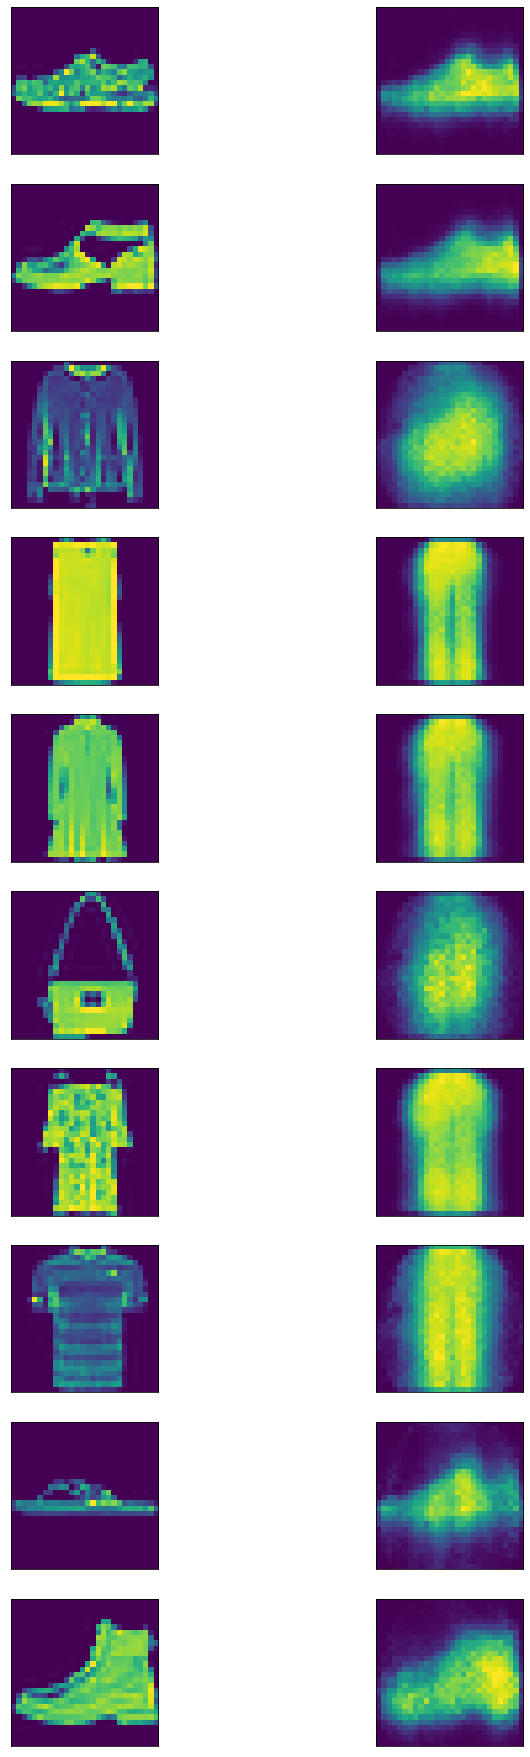

-------------------------------------


In [ ]:
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import Sequential

code_size = 392
hidden_size1 = 584
hidden_size2 = 650

autoencoder = Sequential()

autoencoder.add(Dense(hidden_size1,activation='relu')) # encoder
autoencoder.add(Dense(hidden_size2,activation='relu')) # encoder

autoencoder.add(Dense(code_size,activation='relu')) # encoder

autoencoder.add(Dense(hidden_size2,activation= 'relu')) #decoder
autoencoder.add(Dense(hidden_size1,activation= 'relu')) #decoder
autoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder

autoencoder.compile(optimizer=SGD(lr=0.002),loss='binary_crossentropy')
history = autoencoder.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled), verbose=True)
autoencoder.summary()

plt.rcParams["figure.figsize"]=[12,32]
ix = 1
for u in range(10):
  ax = plt.subplot(10,2,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(x_val_vector_scaled[ix+20].reshape(28,28))
  ax = plt.subplot(10,2,ix+1)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(autoencoder.predict(x_val_vector_scaled)[ix+20].reshape(28,28))
  ix += 2
plt.show()
print("-------------------------------------")

Cantidad neuronas: 128
N° Epochs:50, Loss: 0.37757086753845215, Val Loss: 0.3784780204296112
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 584)               458440    
_________________________________________________________________
dense_28 (Dense)             (None, 650)               380250    
_________________________________________________________________
dense_29 (Dense)             (None, 128)               83328     
_________________________________________________________________
dense_30 (Dense)             (None, 650)               83850     
_________________________________________________________________
dense_31 (Dense)             (None, 584)               380184    
_________________________________________________________________
dense_32 (Dense)             (None, 784)               458640    
Total params: 1,844,692
Tra

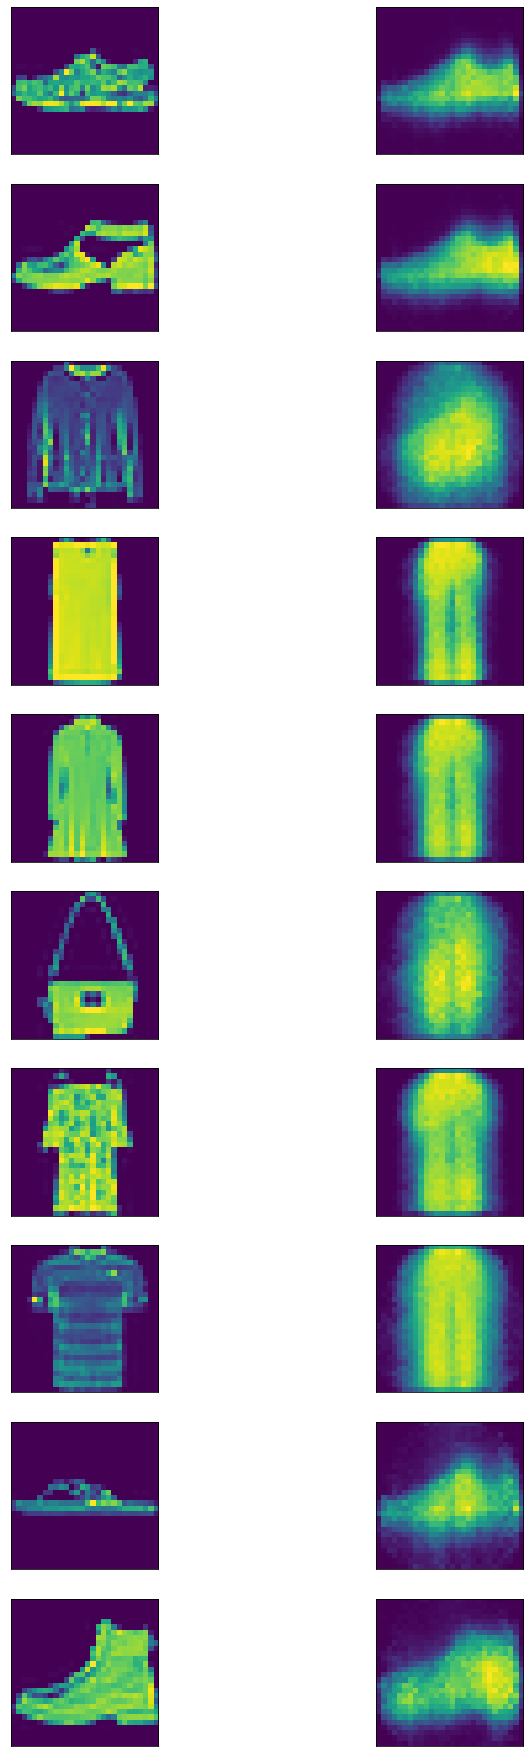

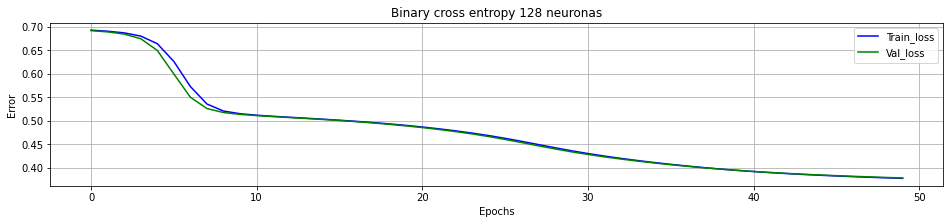

<Figure size 1152x216 with 0 Axes>

-------------------------------------
Cantidad neuronas: 256
N° Epochs:50, Loss: 0.37359535694122314, Val Loss: 0.3746489882469177
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 584)               458440    
_________________________________________________________________
dense_34 (Dense)             (None, 650)               380250    
_________________________________________________________________
dense_35 (Dense)             (None, 256)               166656    
_________________________________________________________________
dense_36 (Dense)             (None, 650)               167050    
_________________________________________________________________
dense_37 (Dense)             (None, 584)               380184    
_________________________________________________________________
dense_38 (Dense)             (None, 784)               

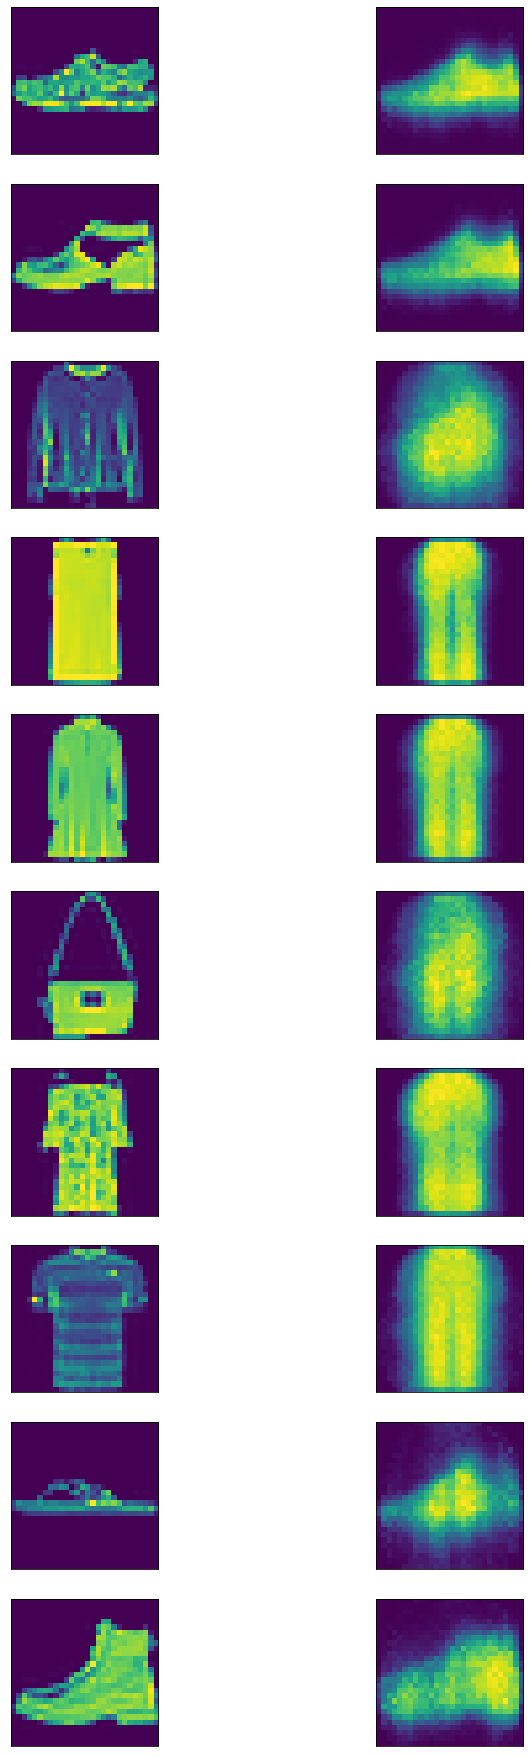

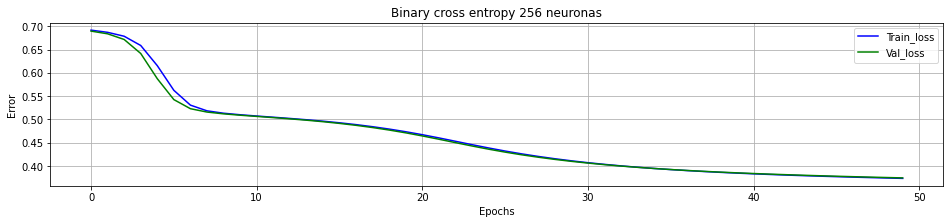

<Figure size 1152x216 with 0 Axes>

-------------------------------------
Cantidad neuronas: 450
N° Epochs:50, Loss: 0.3730649948120117, Val Loss: 0.3741218149662018
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 584)               458440    
_________________________________________________________________
dense_40 (Dense)             (None, 650)               380250    
_________________________________________________________________
dense_41 (Dense)             (None, 450)               292950    
_________________________________________________________________
dense_42 (Dense)             (None, 650)               293150    
_________________________________________________________________
dense_43 (Dense)             (None, 584)               380184    
_________________________________________________________________
dense_44 (Dense)             (None, 784)               4

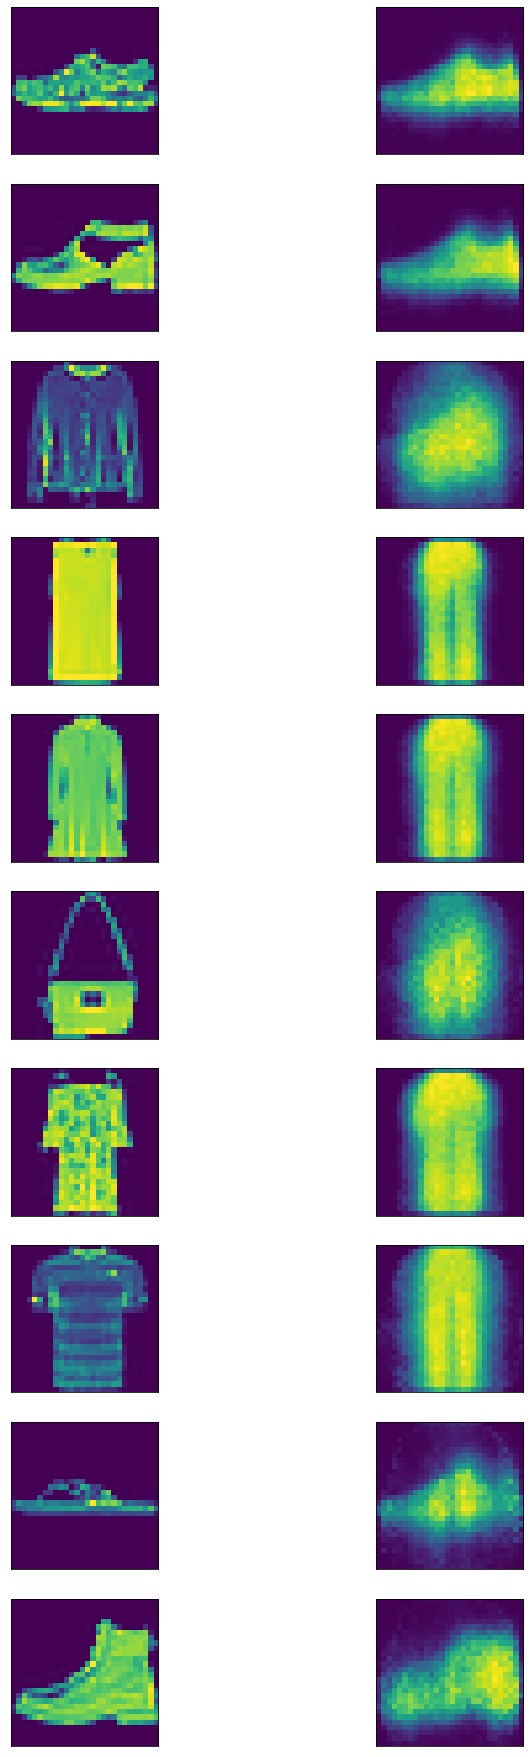

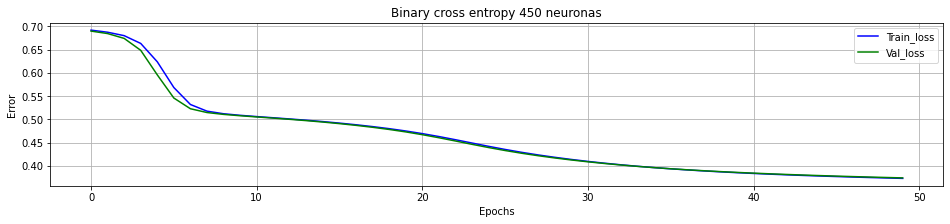

<Figure size 1152x216 with 0 Axes>

-------------------------------------


In [ ]:
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import Sequential

code_size = 392
hidden_size1 = 584
hidden_size2 = 650

new_sizes = [128, 256, 450]

for i in new_sizes:
  autoencoder = Sequential()

  autoencoder.add(Dense(hidden_size1,activation='relu')) # encoder
  autoencoder.add(Dense(hidden_size2,activation='relu')) # encoder

  autoencoder.add(Dense(i,activation='relu')) # encoder

  autoencoder.add(Dense(hidden_size2,activation= 'relu')) #decoder
  autoencoder.add(Dense(hidden_size1,activation= 'relu')) #decoder
  autoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder

  autoencoder.compile(optimizer=SGD(lr=0.002),loss='binary_crossentropy')
  history = autoencoder.fit(x_train_vector_scaled,x_train_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled), verbose=False)
  print("Cantidad neuronas: " + str(i))
  print("N° Epochs:{0}, Loss: {1}, Val Loss: {2}".format(len(history.history["loss"]), history.history["loss"][-1], history.history["val_loss"][-1]))
  autoencoder.summary()

  plt.rcParams["figure.figsize"]=[12,32]
  ix = 1
  print("Cantidad neuronas: " + str(i))
  print("N° Epochs:{0}, Loss: {1}, Val Loss: {2}".format(len(history.history["loss"]), history.history["loss"][-1], history.history["val_loss"][-1]))
  for u in range(10):
    ax = plt.subplot(10,2,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(x_val_vector_scaled[ix+20].reshape(28,28))
    ax = plt.subplot(10,2,ix+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(autoencoder.predict(x_val_vector_scaled)[ix+20].reshape(28,28))
    ix += 2
  plt.show()
  plt.rcParams["figure.figsize"]=[16,3]
  graph_results_alone_notest(history,"Binary cross entropy {0} neuronas".format(i))
  print("-------------------------------------")

## 3.f) Convolutional Autoencoder

Como hemos hasta ahora  utilizado una arquitectura fully connected, nuestra red no toma en cuenta la infomación local contenida en la proximidad de un pixel en la imagen. Como vimos en la tarea anterior, esta información podría ser crucial al momento de procesar imágenes. 

En este item deberá implementar un autoencoder convolucional. La sección de encoding de la red se creará de igual manera que las redes convolucionales creadas en la tarea 1. Puede utilizar capas de Max Pooling o Strides mayores a 1 para reducir la dimensionalidad en esta etapa. Tenga en mente como varía la dimensión de la imagen a lo largo del proceso. 

Para luego recuperar la dimensionalidad de la imagen original debemos utilizar una capa llamada usualmente como "Deconvolution Layer". Esta capa realiza el proceso inverso que aquel realizado por una capa convolucional, por lo cual utilizando por ejemplo `stride=2` puede duplicar la dimensionalidad de su input. 

Puede realizar la profundidad que desee, pero tome en cuenta que una mayor profundidad de la sección convolucional permite a la red reducir dimensionalidad más lentamente, sin "forzar" la compresión de las características. Note que para reconstruir la dimensión original puede usar `output_padding` para corregir problemas de paridad, entre otros. 

Puede igualmente optar por usar algun número de capas densas en el cuello de botella del autoencoder, usando al comienzo de esta una capa `Flatten` y al final de ella una capa `Reshape` (`keras.layers.Reshape(target_shape)`) para recuperar la bidimensionalidad.

¡No olvide que para entrenar esta red debe usar la versión bidimensional de los datos escalados!

Visualice que tan bien se comporta la convolución, en terminos de la función de pérdida y visualizando las imagenes reconstruidas. Compárese con la red densa. 

(60000, 28, 28)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 4, 4, 8

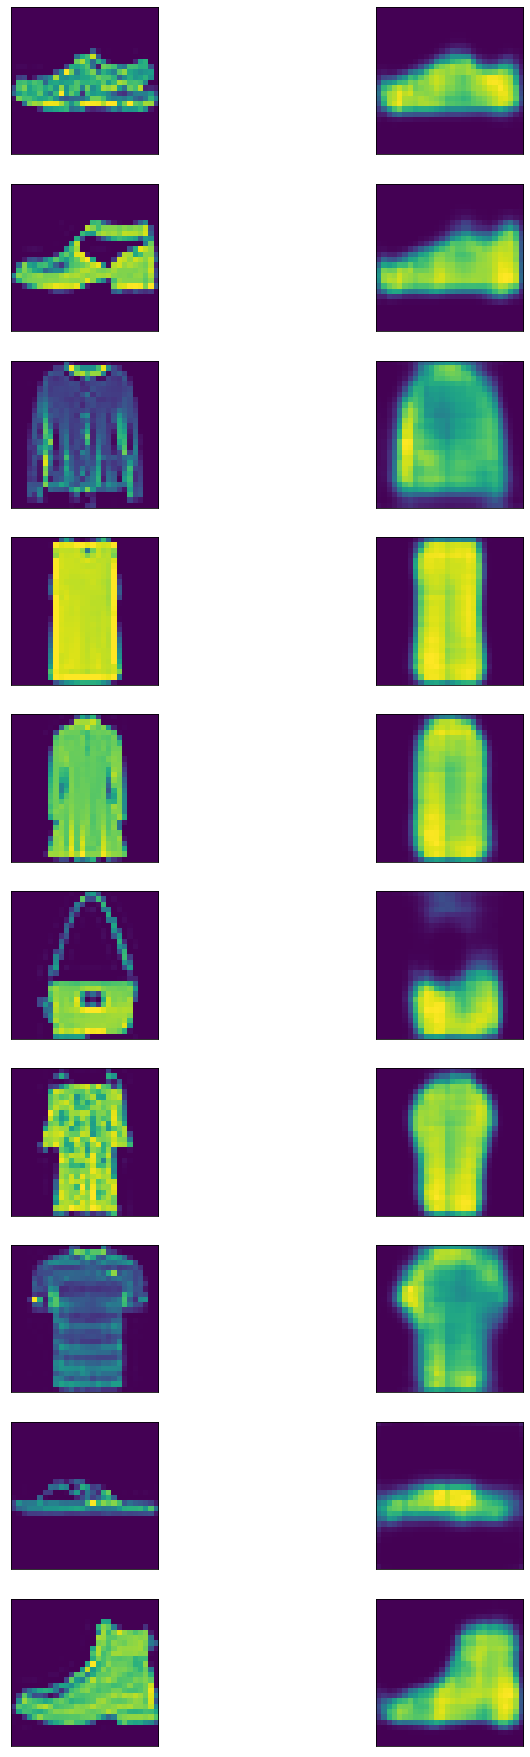

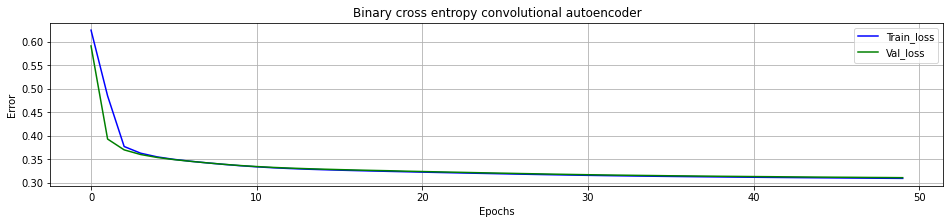

<Figure size 1152x216 with 0 Axes>

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.layers import Dense, Input
from keras.optimizers import SGD
from keras.models import Sequential, Model

x_tr_scaled = x_tr/255
x_val_scaled = x_val/255
print(x_tr.shape)

# The encoding process
input_img = Input(shape=(28, 28, 1))  

############
# Encoding #
############

# Conv1 #
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

# Conv2 #
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

# Conv 3 #
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)


############
# Decoding #
############

# DeConv1
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

# DeConv2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Deconv3
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Declare the model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=SGD(lr=0.002),loss='binary_crossentropy')
autoencoder.summary()
history = autoencoder.fit(x_tr_scaled,x_tr_scaled,epochs=50,validation_data=(x_val_scaled,x_val_scaled), verbose=True)

plt.rcParams["figure.figsize"]=[12,32]
ix = 1
for u in range(10):
  ax = plt.subplot(10,2,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(x_val_scaled[ix+20].reshape(28,28))
  ax = plt.subplot(10,2,ix+1)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(autoencoder.predict(x_val_scaled)[ix+20].reshape(28,28))
  ix += 2
plt.show()
plt.rcParams["figure.figsize"]=[16,3]
graph_results_alone_notest(history,"Binary cross entropy convolutional autoencoder")

Esta nueva red tiene errores de validación y entrenamiento cercanos a 0.32, lo que es menor a la red deep cuyos valores eran mayores a 0.37.

Respecto a las imagenes producidas la calidad de estas es mayor, teniendo formas más definidas y refinando ciertos detalles como el mostrar algo similar a una correa de bolso en dicha imagen en vez de una mancha que no se preocupa de dejar un espacio en medio.

## 3.g) Denoising Autoencoder 

Otra utilidad que se le ha dado a los autoencoders es la posibilidad de utilizarlos para separar ruido de información. Para entrenar tal tipo de modelo, la idea es simple: utilizar como datos de entrada imagenes a las cuales se les ha agregado artificialmente ruido y como objetivo la imagen original sin ruido. 

Entrene alguna arquitectura de autoencoder que le parezca apropiada para la tarea utilizando algún tipo de ruido aleatorio. Puede utilizar cambios en valores de pixeles aleatoriamente, o por ejemplo "promediar" ponderadamente la imagen original con alguna otra imagen del dataset ligeramente modificada. Puede utilizar las librerías `random` de `numpy`. Sea creativo, puede crear el ruido que desee. Idealmente, considerando la naturaleza del problema que se buscaría modelar (eliminar ruido real de mediciones), la naturaleza del ruido agregado debe ser estocástica y no puede "repetirse" el mismo patrón de ruido a lo largo de todo el entrenamiendo, es decir, si agregó un ruido estocástico a cada imágen del conjunto, este proceso debe iterarse igualmente luego de cada época de entrenamiento, para evitar que la red aprenda un patrón especifico de ruido, si no aprenda realmente a diferenciar ruido sin información de la información suyaciente a la imagen. 

Una vez esté satisfecho con la red, muestre ejemplos de la imagen con ruido, la imagen original y la imagen reconstruida. Pruebe igualmente entregarle a la red nuevas.

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 4, 4, 8)           0   

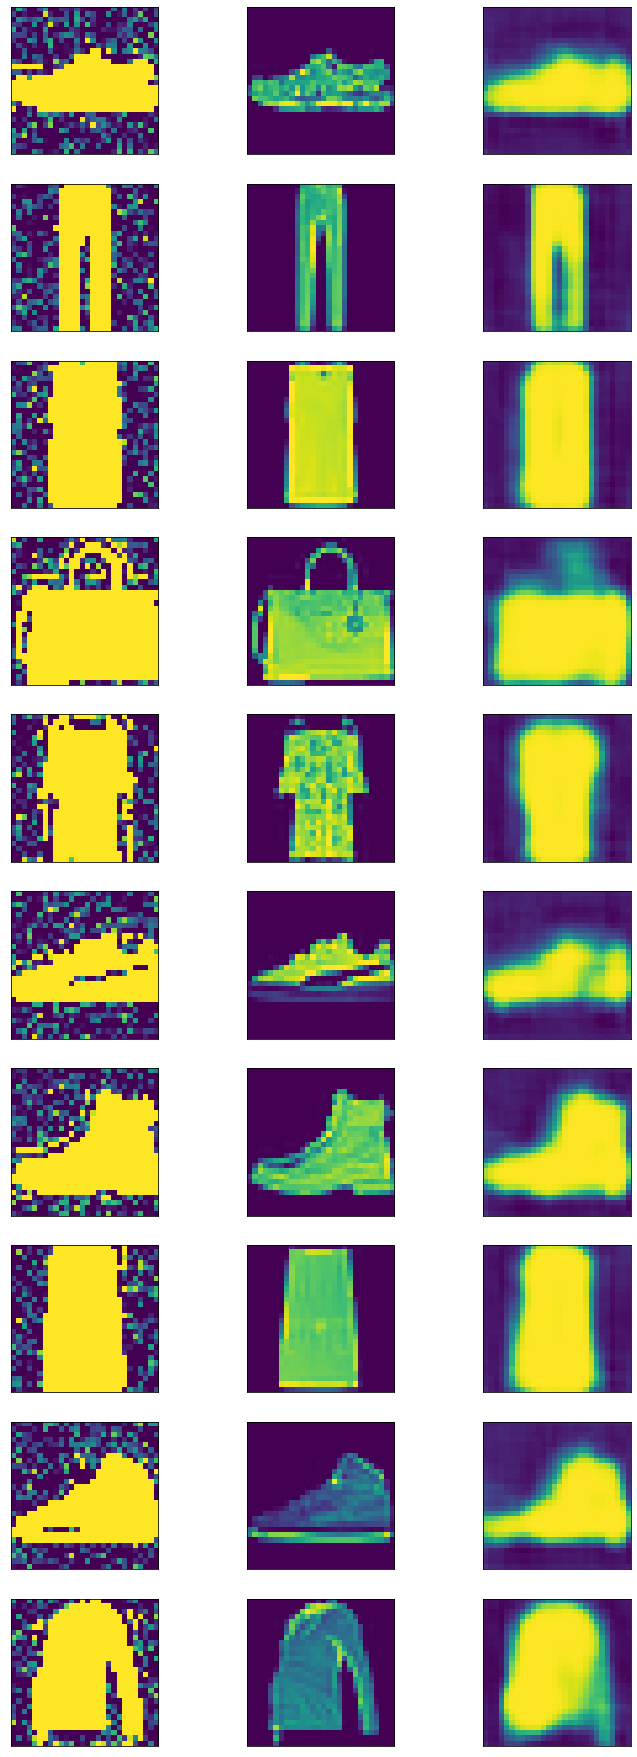

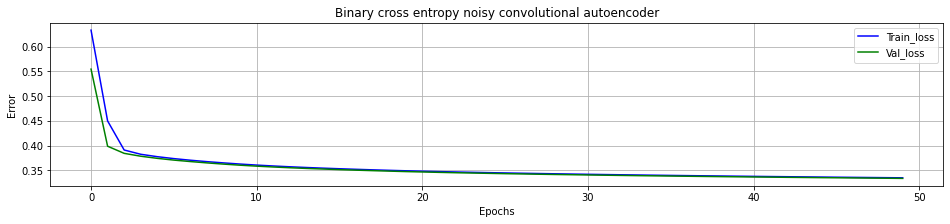

<Figure size 1152x216 with 0 Axes>

In [ ]:
noise_factor = 0.4
x_train_noisy = x_tr + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_tr.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

# The encoding process
input_img = Input(shape=(28, 28, 1))  

############
# Encoding #
############

# Conv1 #
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

# Conv2 #
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

# Conv 3 #
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)


############
# Decoding #
############

# DeConv1
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

# DeConv2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

# Deconv3
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Declare the model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=SGD(lr=0.002),loss='binary_crossentropy')
autoencoder.summary()
history = autoencoder.fit(x_train_noisy,x_train_noisy,epochs=50,validation_data=(x_val_noisy,x_val_noisy), verbose=True)

plt.rcParams["figure.figsize"]=[12,32]
ix = 1
for u in range(10):
  ax = plt.subplot(10,3,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(x_val_noisy[ix+20].reshape(28,28))
  ax = plt.subplot(10,3,ix+1)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(x_val[ix+20].reshape(28,28))
  ax = plt.subplot(10,3,ix+2)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(autoencoder.predict(x_val_noisy)[ix+20].reshape(28,28))
  ix += 3
plt.show()
plt.rcParams["figure.figsize"]=[16,3]
graph_results_alone_notest(history,"Binary cross entropy noisy convolutional autoencoder")


El desempeño en cuanto a errores de validación y entrenamiento es similar a la arquitectura convolucional.

En cuanto a la visualización de imágenes se puede ver que el aplicar ruido remueve detalles de las prendas pero hace que conserven su forma, lo que puede llegar a ser beneficioso para entrenar la red.

## 3.h) Generación de imágenes

Otra utilización posible que podría darse, quizás, a los autoencoders, es utilizar los decoders para generar nuevas imágenes. La idea de esto sería considerar que la habilidad que tiene la sección decoder de generar una imágen a partir de una representación de menor dimensionalidad puede aprovecharse. 

Para esto, extraiga la sección de encoding y la sección de decoding de alguno de los autoencoders entrenados que prefiera. Obtenga los valores de la representación interna de las imágenes usando el encoder para calcularlos. Luego agréguele a esta representación algún ruido de su preferencia, y calcule la imágen resultante utilizando el decoder. ¿Qué observa? Muestre las imágenes obtenidas junto con otras imágenes de la misma categoría que la imágen que utilizó originalmente. Pruebe con distintos valores de ruido.

Pruebe también, por ejemplo, calcular la imágen obtenida al promediar las representaciones comprimidas de varias (o todas) las imágenes de una clase. Utilice el encoder para generar imágenes a partir de otros valores que se les ocurran y especule sobre el por qué la imágen obtenida se asimila o no a las imágenes del dataset. 

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.layers import Dense, Input
from keras.optimizers import SGD
from keras.models import Sequential, Model
x_tr_scaled = x_tr/255
x_val_scaled = x_val/255
input_img = Input(shape=(28, 28, 1))  

############
# Encoding #
############

# Conv1 #
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

# Conv2 #
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

# Conv 3 #
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size = (2, 2), padding='same')(x)

############
# Decoding #
############

dec_input_shape = (4,4,8)
# DeConv1
y = Conv2D(8, (3, 3), activation='relu', padding='same', input_shape = dec_input_shape)(encoded)
y = UpSampling2D((2, 2))(y)

# DeConv2
y = Conv2D(8, (3, 3), activation='relu', padding='same')(y)
y = UpSampling2D((2, 2))(y)

# Deconv3
y = Conv2D(16, (3, 3), activation='relu')(y)
y = UpSampling2D((2, 2))(y)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(y)

# Declare the model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=SGD(lr=0.002),loss='binary_crossentropy')
autoencoder.summary()
history = autoencoder.fit(x_tr_scaled,x_tr_scaled,epochs=50,validation_data=(x_val_scaled,x_val_scaled), verbose=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import activations
from tensorflow.python.keras.engine import input_layer

encoder_model = autoencoder.layers[-8].output
encoder_model = tf.keras.models.Model(autoencoder.input, encoder_model)
encoder_model.summary()

decoder_model = Sequential(autoencoder.layers[7:])
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0   

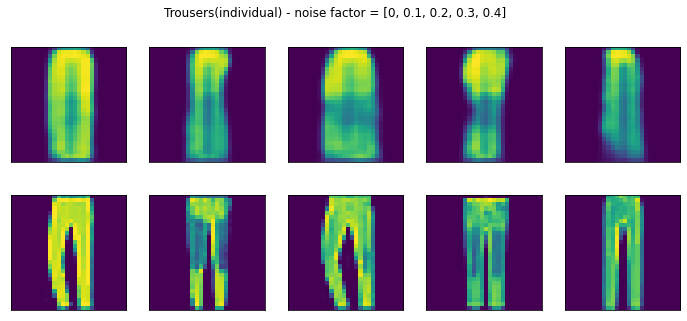

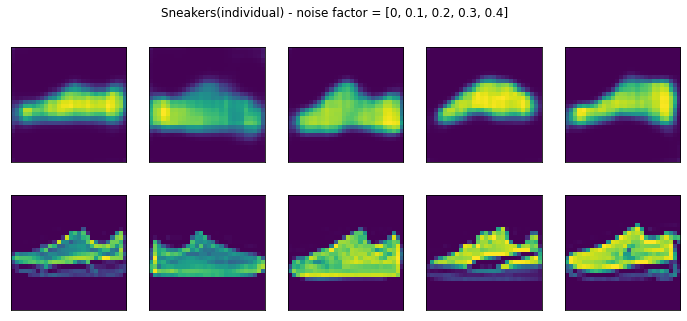

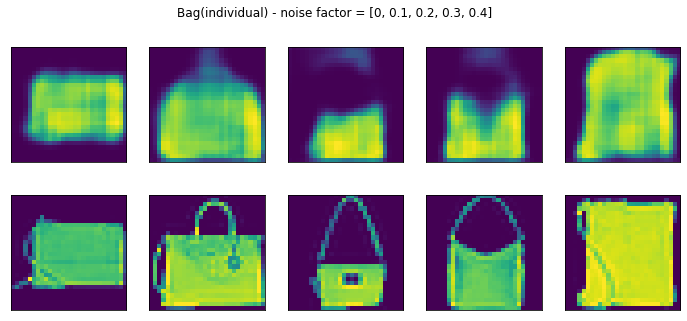

In [ ]:
#Distintas imagenes, distinto ruido
clothes_tests = [1, 7, 8]
noise_factors = [0, 0.1, 0.2, 0.3, 0.4]
title_texts = ["Trousers(individual) - noise factor = [0, 0.1, 0.2, 0.3, 0.4]",
               "Sneakers(individual) - noise factor = [0, 0.1, 0.2, 0.3, 0.4]", 
               "Bag(individual) - noise factor = [0, 0.1, 0.2, 0.3, 0.4]"]

title_index = 0
for clothes_index in clothes_tests:
  new_images = []
  image_set = x_val_scaled[np.where(y_val==clothes_index)[0][:5],:,:]
  for noise_factor in noise_factors:    
    encoded_img = encoder_model.predict(np.expand_dims(image_set[noise_factors.index(noise_factor)], axis = 0))
    encoder_noisy = encoded_img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=encoder_prom.shape) 
    encoder_noisy = np.clip(encoder_noisy, np.min(encoder_prom), np.max(encoder_prom))
    new_image = decoder_model.predict(encoder_noisy)
    new_images.append(new_image)
  plt.rcParams["figure.figsize"]=[12,5]
  ix = 1
  
  for u in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(new_images[u].reshape(28,28))
    ax = plt.subplot(2,5,ix+5)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(image_set[u].reshape(28,28))
    
    ix += 1
  plt.suptitle(title_texts[title_index])
  plt.show()
  title_index+=1


### Análisis

Como podemos ver, se generan imágenes bastante buenas en las cuales nuestro ojo humano puede identificar en la mayoría a qué corresponden, dándole para los casos de ejemplo mostrados buenos resultados en zapatillas y bolsos. También se obtienen buenos valores de loss cercanos al 0.3, lo que se refleja en las imágenes generadas.

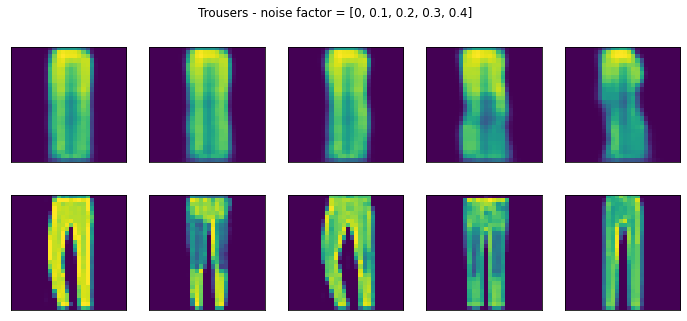

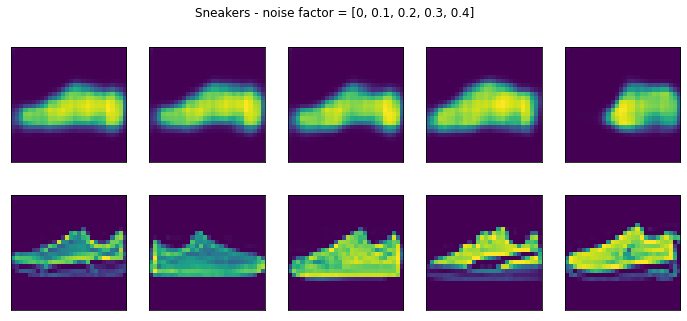

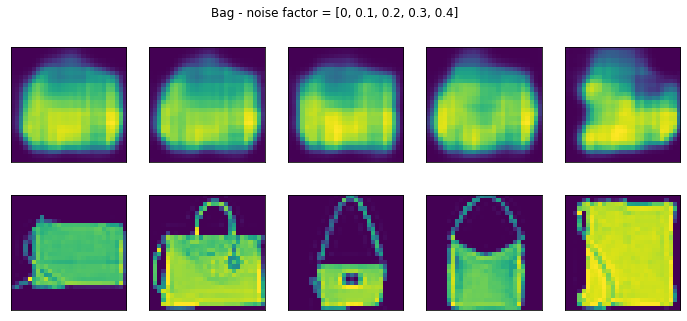

In [ ]:
#Promedio de imágenes, varia ruido
clothes_tests = [1, 7, 8]
noise_factors = [0, 0.1, 0.2, 0.3, 0.4]
title_texts = ["Trousers(mean) - noise factor = [0, 0.1, 0.2, 0.3, 0.4]",
               "Sneakers(mean) - noise factor = [0, 0.1, 0.2, 0.3, 0.4]", 
               "Bag(mean) - noise factor = [0, 0.1, 0.2, 0.3, 0.4]"]

title_index = 0
for clothes_index in clothes_tests:
  new_images = []
  for noise_factor in noise_factors:

    image_set = x_val_scaled[np.where(y_val==clothes_index)[0][:25],:,:]
    encoded_img = encoder_model.predict(image_set)
    encoder_prom = 0
    for image in encoded_img:
      encoder_prom += image
    encoder_prom/=25

    encoder_noisy = encoder_prom + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=encoder_prom.shape) 
    encoder_noisy = np.clip(encoder_noisy, np.min(encoder_prom), np.max(encoder_prom))
    new_image = decoder_model.predict(np.expand_dims(encoder_noisy, axis=0))
    new_images.append(new_image)
  plt.rcParams["figure.figsize"]=[12,5]
  ix = 1
  
  for u in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(new_images[u].reshape(28,28))
    ax = plt.subplot(2,5,ix+5)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(image_set[u].reshape(28,28))
    
    ix += 1
  plt.suptitle(title_texts[title_index])
  plt.show()
  title_index+=1


### Análisis

Como podemos ver, se obtienen imágenes que respetan al menos la silueta en la mayoría de los casos de imágenes generadas, pero se pierden los detalles al promediar varias imágenes de la misma categoría, por lo que podríamos decir que con una sola imagen de cada categoría logra generar imágenes mejor y más entendibles, haciendo énfasis en la categoría "Bag" donde los resultados generados para este ejemplo son solamente la parte del bolso sin la "correa".

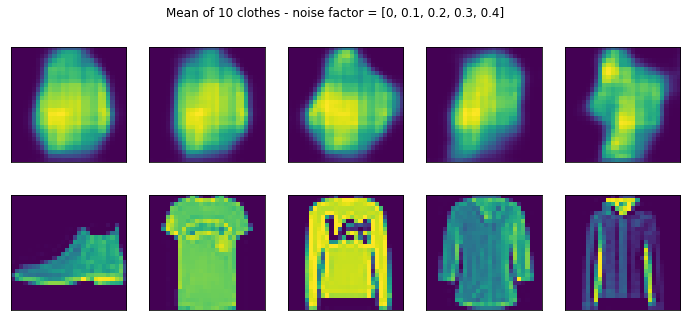

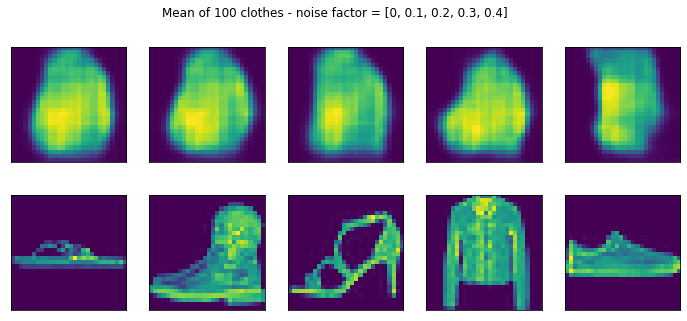

In [ ]:
#Promedio de imágenes de distintas categorías, varia ruido
clothes_quantity = [10, 100]
noise_factors = [0, 0.1, 0.2, 0.3, 0.4]
title_texts = ["Mean of 10 clothes - noise factor = [0, 0.1, 0.2, 0.3, 0.4]",
               "Mean of 100 clothes - noise factor = [0, 0.1, 0.2, 0.3, 0.4]"]

title_index = 0
for clothes_q in clothes_quantity:
  for i in range(10):
    if clothes_q == 10:
      image_set = x_val_scaled[np.where(y_val==i)[0][0],:,:]
      image_set = np.expand_dims(image_set, axis = 0)
      if i == 0:
        new_images = image_set
      else:
        new_images = np.concatenate((new_images, image_set))
    else: 
      image_set = x_val_scaled[np.where(y_val==i)[0][:10],:,:]
      if i == 0:
        new_images = image_set
      else:
        new_images = np.concatenate((new_images, image_set))
    np.random.shuffle(new_images)
  final_imgs = []
  for noise_factor in noise_factors:
    encoded_img = encoder_model.predict(new_images)
    encoder_prom = 0
    for image in encoded_img:
      encoder_prom += image
    encoder_prom/=clothes_q

    encoder_noisy = encoder_prom + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=encoder_prom.shape) 
    encoder_noisy = np.clip(encoder_noisy, np.min(encoder_prom), np.max(encoder_prom))
    new_image = decoder_model.predict(np.expand_dims(encoder_noisy, axis=0))
    final_imgs.append(new_image)
  plt.rcParams["figure.figsize"]=[12,5]
  ix = 1
  
  for u in range(5):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(final_imgs[u].reshape(28,28))
    ax = plt.subplot(2,5,ix+5)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(new_images[u].reshape(28,28))
    
    ix += 1
  plt.suptitle(title_texts[title_index])
  plt.show()
  title_index+=1

### Análisis
Las imágenes obtenidas para este caso son bastante parecidas a las generadas con la etiqueta "Bag" del ejemplo anterior, dando resultados bastante alejados de lo que uno esperaría de ropa. Esta estrategia de generación de imágenes es la peor comparada con las dos anteriores

Por lo visto anteriormente, lo más probable es que los resultados en los últimos casos no se parezcan a tipos de ropa ya que las imágenes generadas como input son demasiado aleatorias, por lo que la red no puede generar una nueva imagen la cual sea similar a algún tipo de ropa.

# 4. GAN para MNIST 

Probablemente uno de los desarrollos recientes del area de las redes neuronales más interesantes son las GAN, o _Generative Adversarial Networks_. Estas han deslumbrado al mundo los últimos años generando resultados inesperados, como los llamados _deep fakes_ (https://www.youtube.com/watch?v=25GjijODWoI&ab_channel=Borked), caras no no existentes generadas artificialmente, entre muchas otras aplicaciones de las cuales las más creativas y divertidas son ampliamente divulgadas. Estos resultados nos dan cuenta que estas redes cuando son implementadas correctamente tienen la habilidad de realizar tareas muy especificas logrando desempeños que en logran incluso en algunos casos engañar a observadores humanos.

<img src="https://jrmerwin.github.io/deeplearning4j-docs/img/GANs.png" background="white">

Dependiendo del problema que uno quiera resolver las GAN no requieren datos etiquetados. Esto lo logran gracias a su estructura adversarial, es decir, donde simultaneamente se entrenan dos redes, una especializada en generar datos y otra red especializada en discriminar datos verdaderos de datos falsos, en su configuración más simple al menos. En esta parte de la tarea deberan generar una red de este tipo que genere dígitos que aparenten ser hechos a mano. Para esto utilizaremos las imágenes de entrenamiento del dataset MNIST que ya conocen.


## 4.a) Primera GAN

El código siguiente contiene todos los ingredientes para entrenar una red GAN, se encuentra áltamente comentada para su entendimiento. Usted deberá incluir funcionalidades al código, no incluya aún ninguna mejora a la arquitectura de las redes, esto se verá en el item 4.c). Las funcionalidades que debe añadir son las siguientes: 

i) Imprimir alguna medida del desempeño tanto del generador como del disciminador (por ejemplo f1-score, precision and recall o accuracy) a lo largo del entrenamiento. ¿Variaciones en esta medidas representan mejoras en nuestra red?

ii) Añadir gráficos de las entradas de data real con un título que indique la clasificación que está dando el discriminador a cada una de estas imágenes (Falsa|Real). El código entregado grafica tan solo las imágenes que genera el generador y la etiqueta que le está dando el discriminador (Falsa|Real).

**Recuero usar entorno de ejecución en GPU**

i) Podrían representar mejoras, ya que si vemos que el accuracy de la red generadora "aumenta" (es decir, que el discriminador se equivoque más veces), podríamos decir que se están generando imágenes cada vez más parecidas a las reales. Sin embargo, es necesario ir visualizando cada ciertos epoch las imágenes generadas para ver si efectivamente está ocurriendo este fenómeno de mejora en la generación.

In [ ]:
from keras.datasets import mnist
import numpy as np
(x,_),(_,_) = mnist.load_data()
x = x.reshape((-1,28,28,1)).astype(np.float32)
x = x/255

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
discriminator_net = Sequential() # Discriminador
discriminator_net.add(Conv2D(3, 3, strides=2, input_shape=x.shape[1:], padding='same')) #Recibe como entrada tanto imágenes generadas por el generador como imágenes del dataset
                                                                                        # de entrenamiento. Recuerden que los hiperparámetros de la red son intencionalmentes
                                                                                        # no idóneos.
discriminator_net.add(Flatten())    #Flatten para pasar a una neurona de capa densa
discriminator_net.add(Dense(1,activation='sigmoid',use_bias=False))   # La salida estará entre 0 y 1.

generator_net = Sequential() 
noise_size=50
generator_net.add(Dense(7*7*10, input_shape=[noise_size]))   # el generador recibirá como entrada ruido, el tamaño es arbitrario.
generator_net.add(Reshape((7,7,10)))    # Transforma la salida de la red densa unidimensional a tridimensional, las primeras dos pueden ser interpretadas como tamaño imágen
                                          # y la tercera como n° canales
generator_net.add(UpSampling2D())   # upsampling2d nos permite pasar de imágenes 7,7,10 a 14,14,10
generator_net.add(Conv2D(32, 5, padding='same')) # podemos añadir convolucionales dada la entrada a esta capa, la primera dimensión transformará la data
                                                      # desde 14,14,10 a 14,14,32
generator_net.add(UpSampling2D()) # pasamos de 14,14,32 a 28,28,32
generator_net.add(Conv2D(1, 6, padding='same',activation='sigmoid')) # hagamos lo que hagamos hay que asegurarse de obtener una salida 28,28,1 como es el caso en esta arquitectura

discriminator = Sequential() # Compilamos el discriminador, sin embargo debemos crear la red auxiliar a discriminator_net, para poder entrenarla independiente del generator
discriminator.add(discriminator_net)
discriminator.compile(loss='binary_crossentropy', optimizer = RMSprop(lr=1e-2), metrics=['acc']) # compilamos con binary cross entropy

gan = Sequential() # GAN contendrá al generador y al discriminador en serie
gan.add(generator_net) # añadimos inicialmente el generador
for layer in discriminator_net.layers: # y luego el discriminador 
    layer.trainable = False # nos preocupamos de dejar esta capa no entrenable por el compilador, puesto este discrimiador se entrenará con la data real para identificar real|fake
gan.add(discriminator_net) # añadimos las capas ya modificadas para no ser entrenadas
gan.compile(loss='binary_crossentropy', optimizer = RMSprop(lr=1e-2), metrics=['acc']) #compilamos

EPOCH------>0


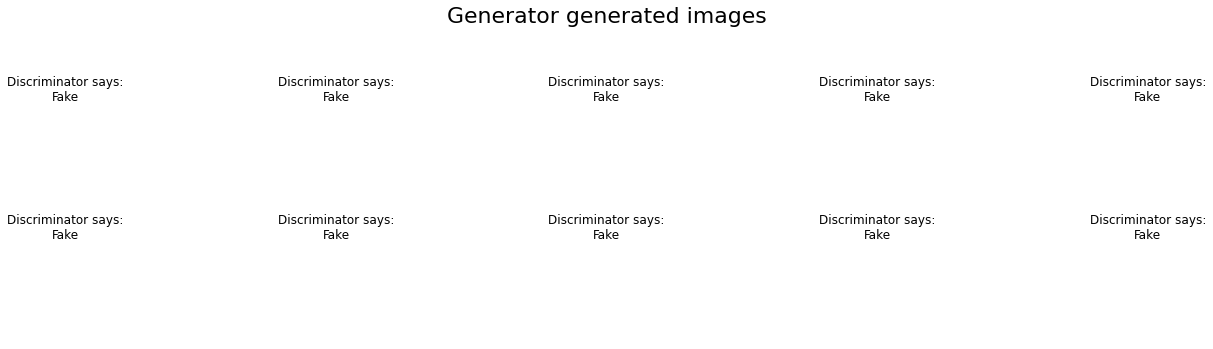

------------------------------------------------------------------------------------------------------------------------


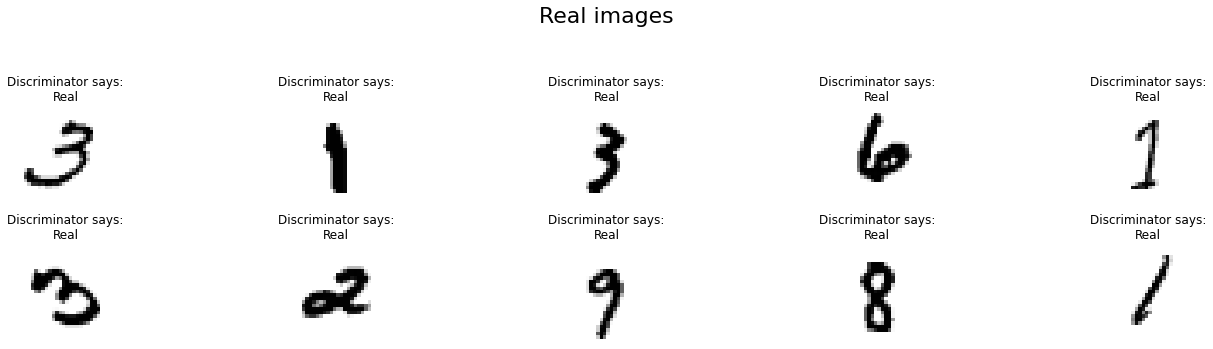

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>1


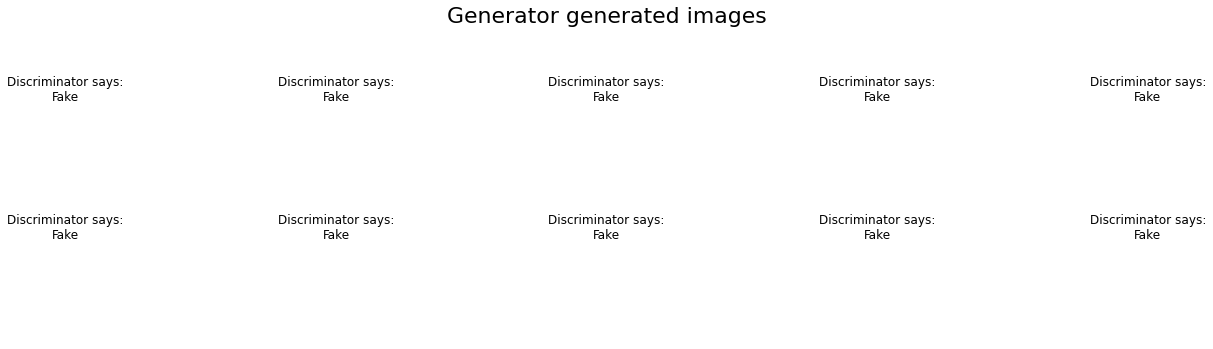

------------------------------------------------------------------------------------------------------------------------


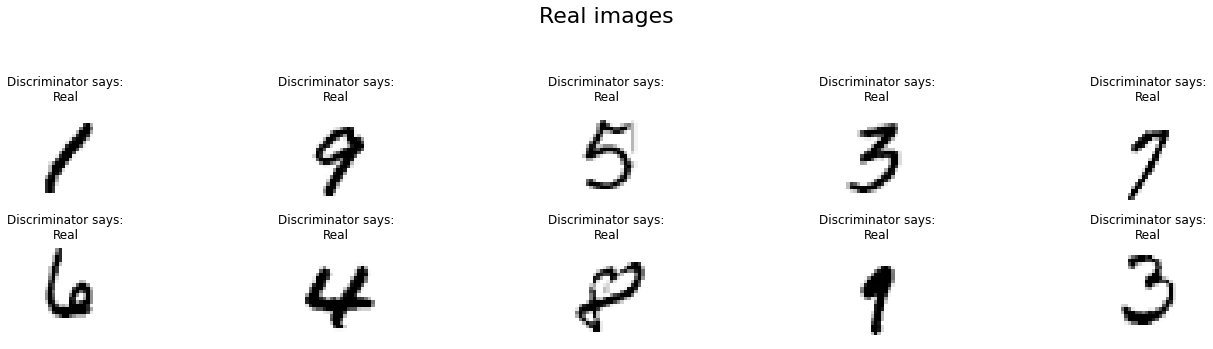

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>2


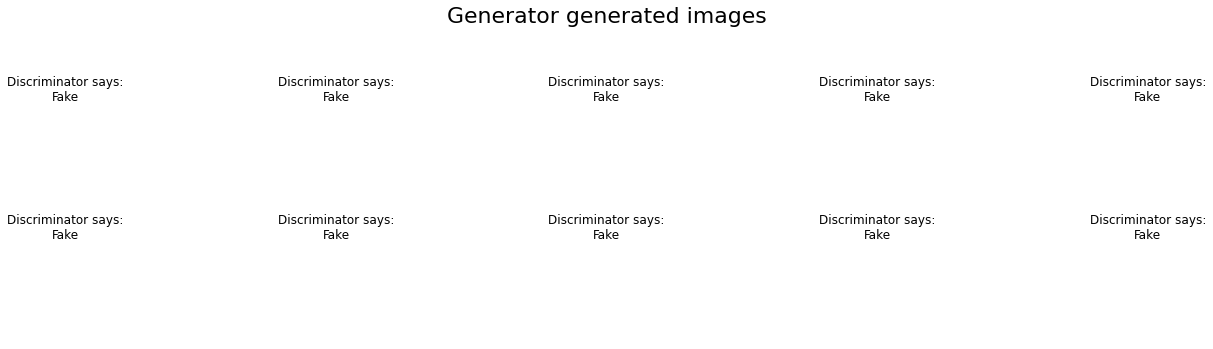

------------------------------------------------------------------------------------------------------------------------


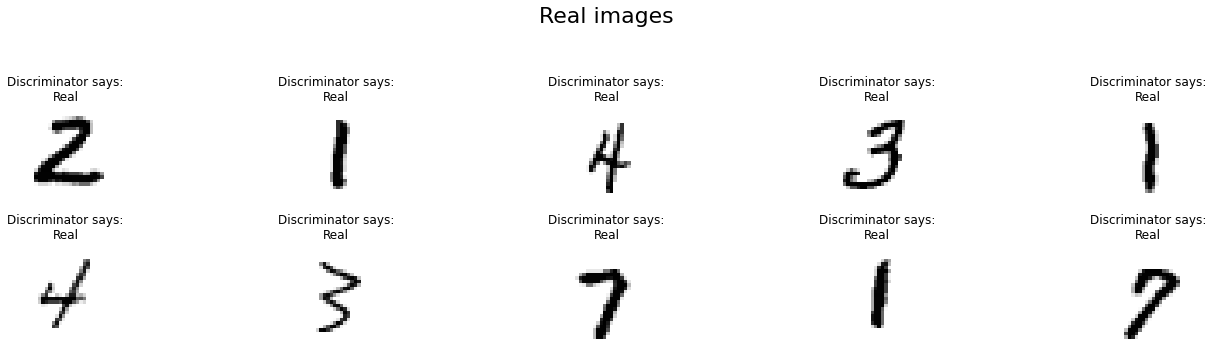

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>3


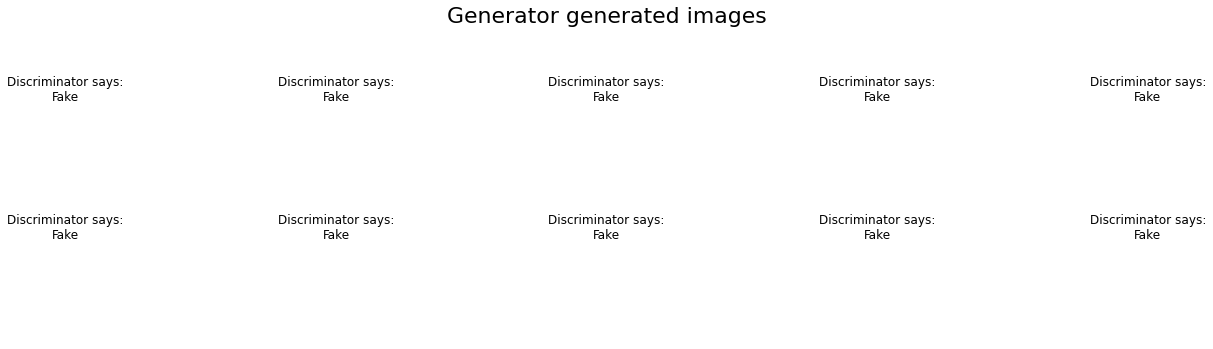

------------------------------------------------------------------------------------------------------------------------


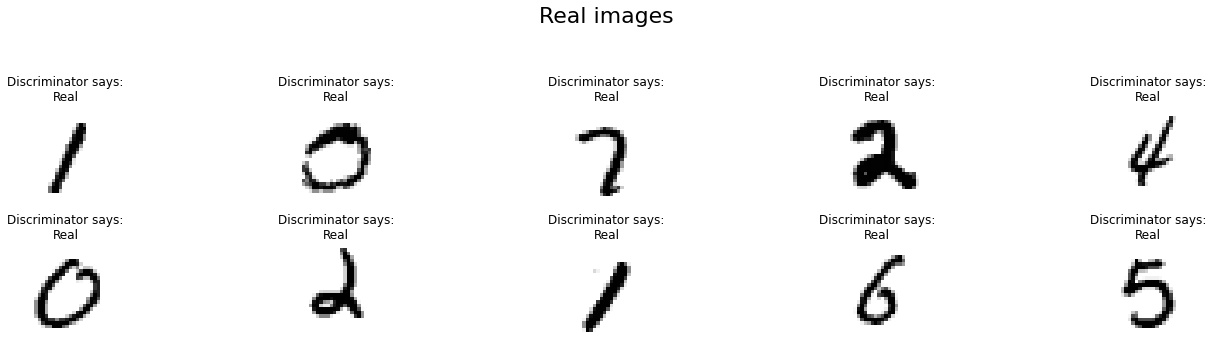

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>4


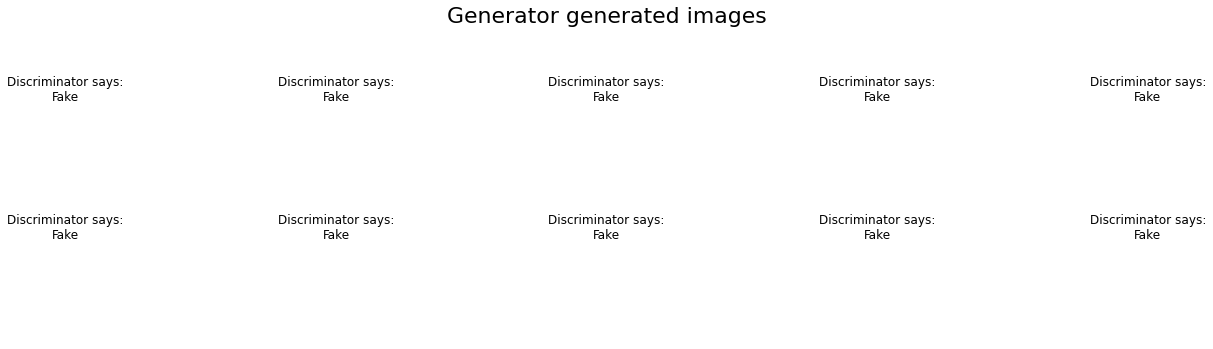

------------------------------------------------------------------------------------------------------------------------


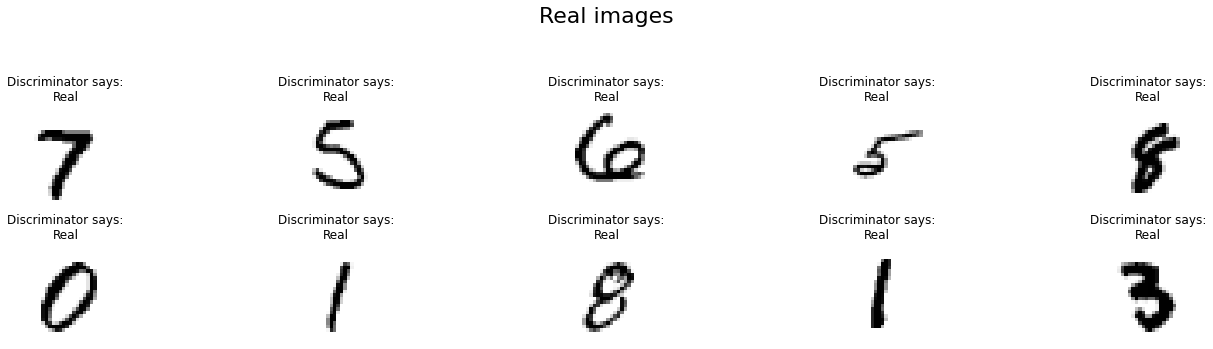

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>5


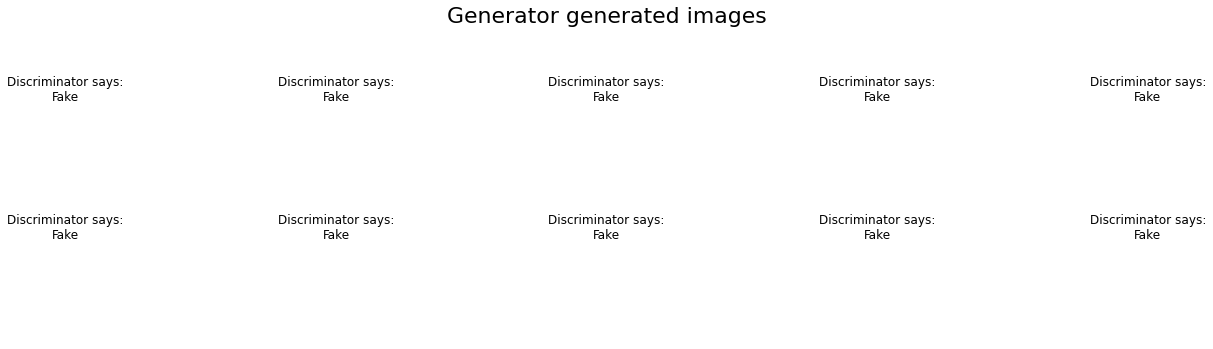

------------------------------------------------------------------------------------------------------------------------


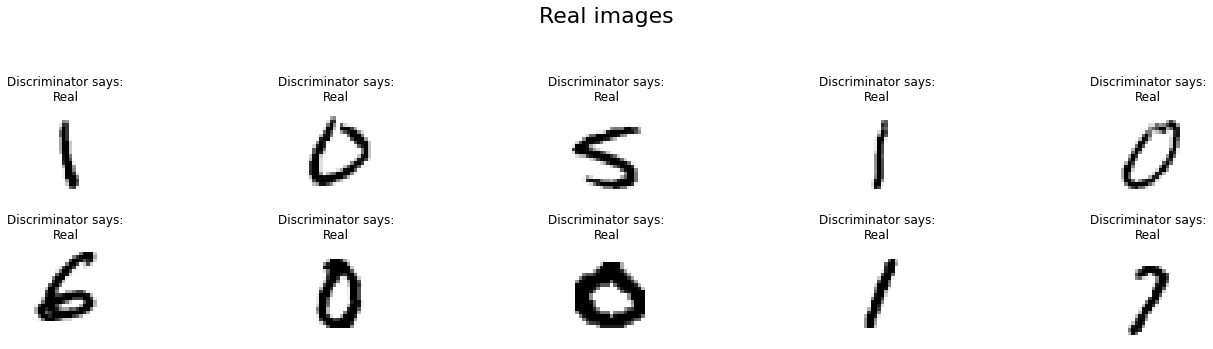

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>6


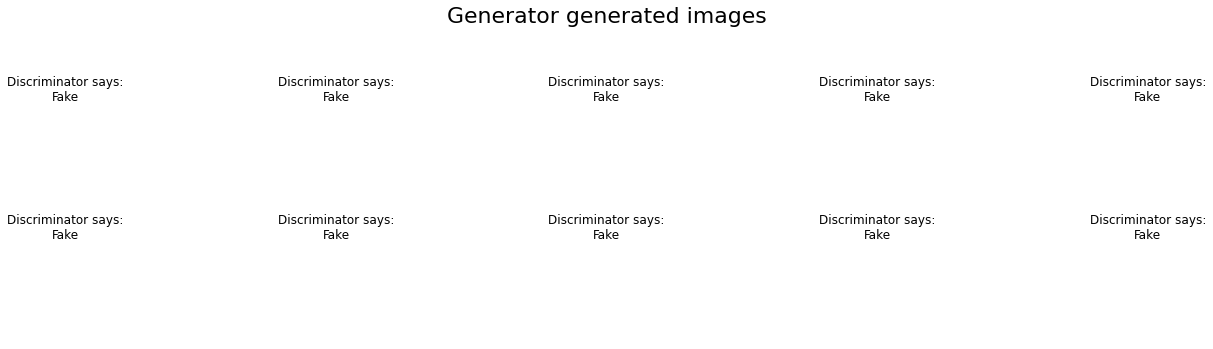

------------------------------------------------------------------------------------------------------------------------


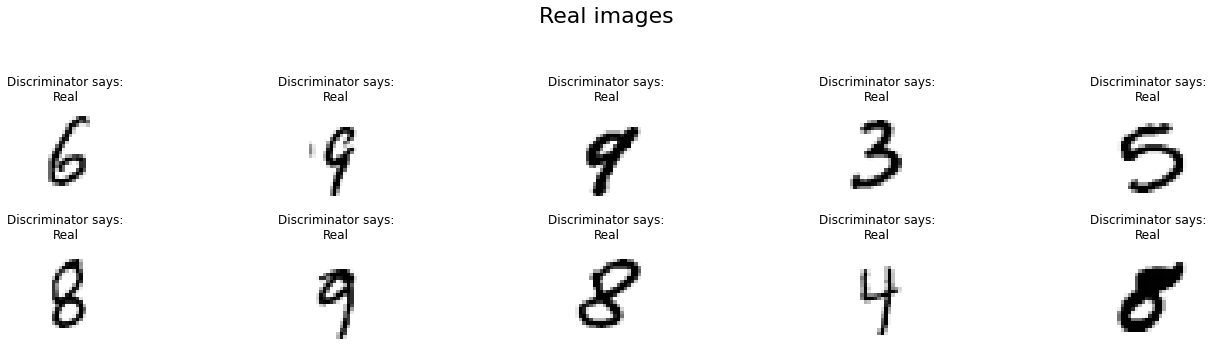

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>7


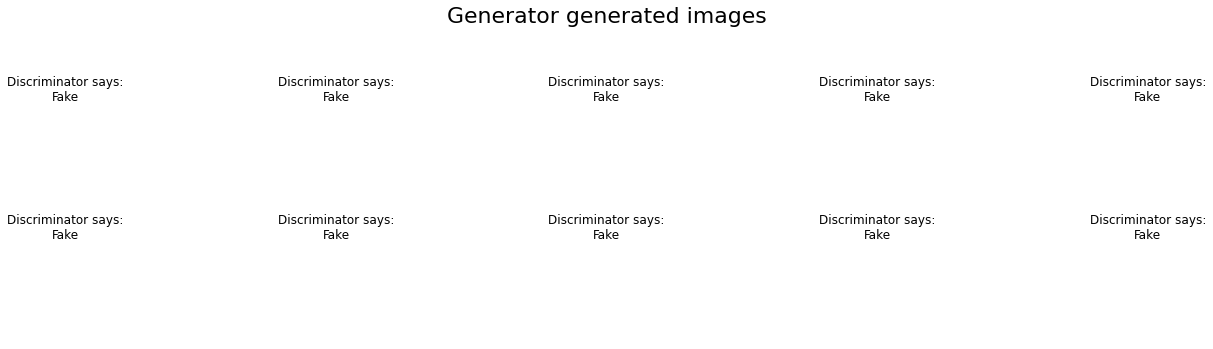

------------------------------------------------------------------------------------------------------------------------


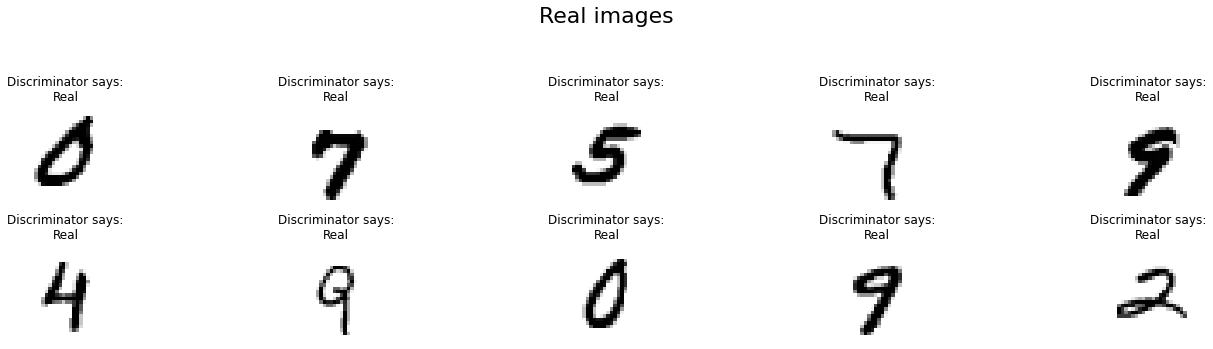

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>8


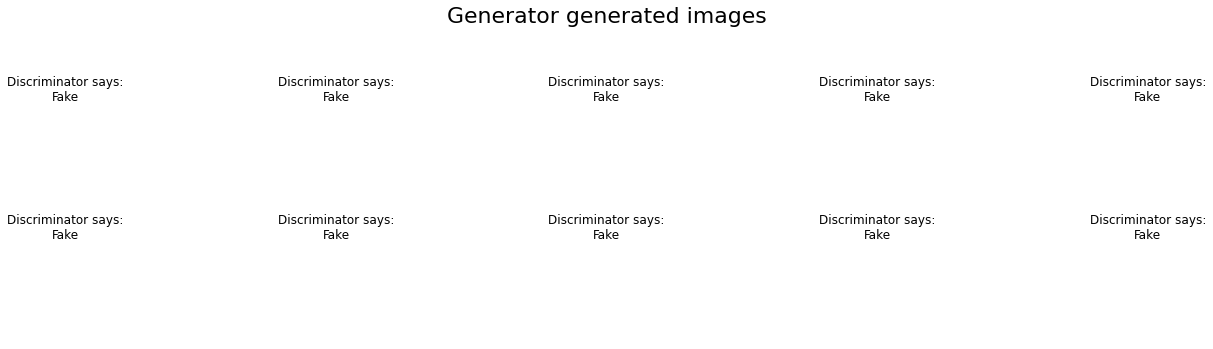

------------------------------------------------------------------------------------------------------------------------


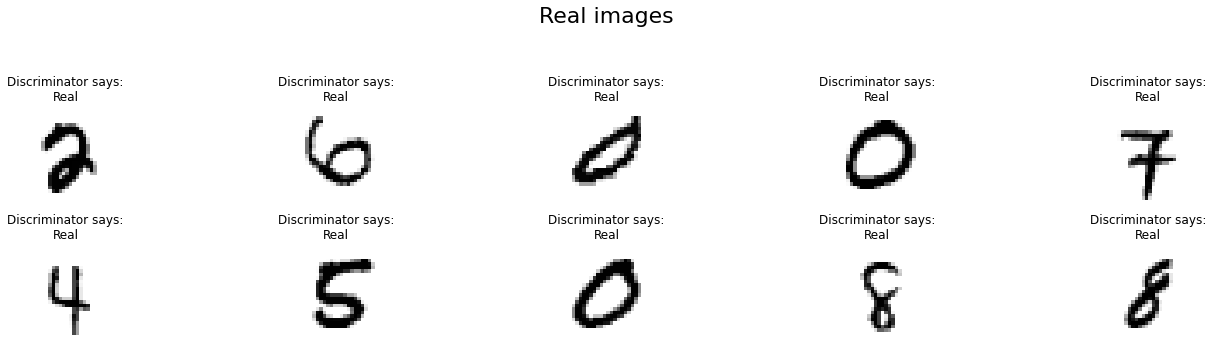

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>9


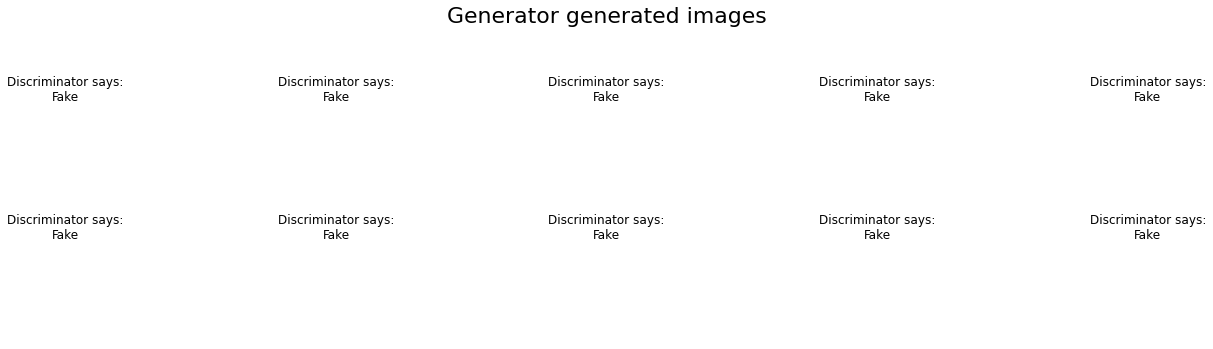

------------------------------------------------------------------------------------------------------------------------


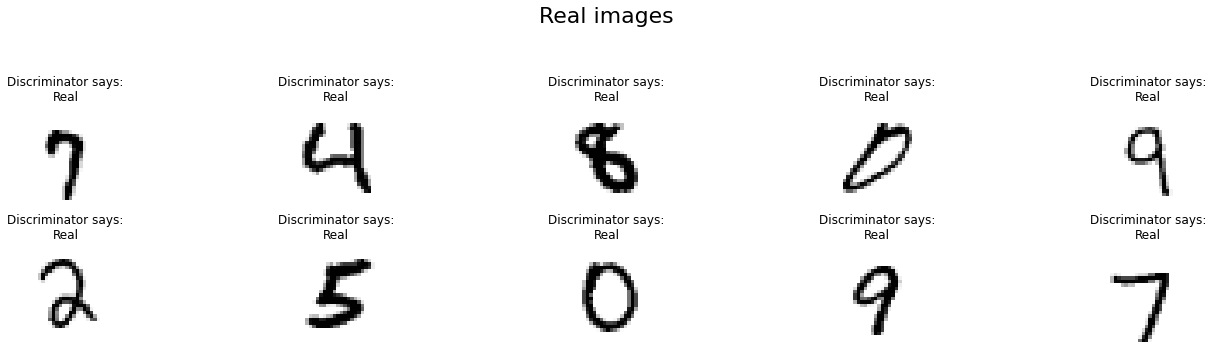

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>10


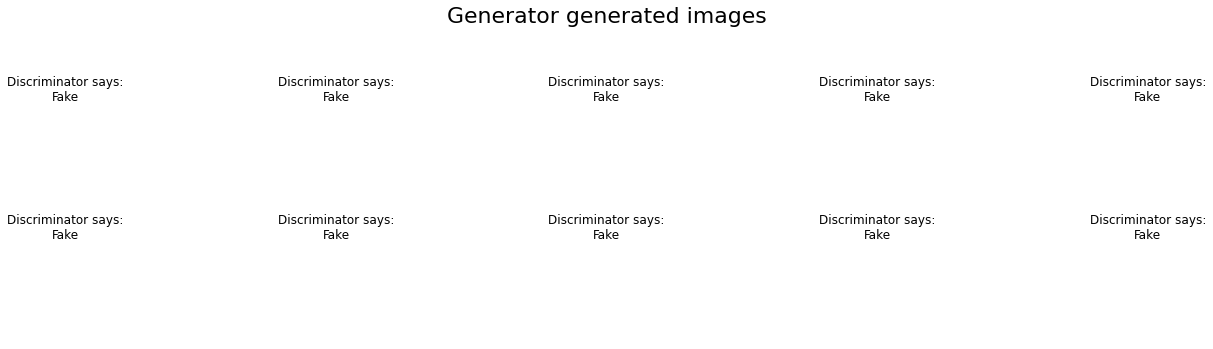

------------------------------------------------------------------------------------------------------------------------


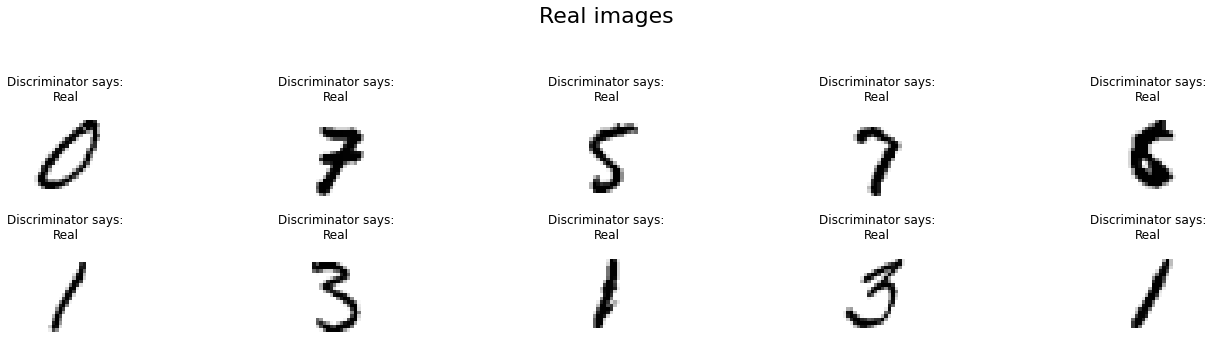

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>11


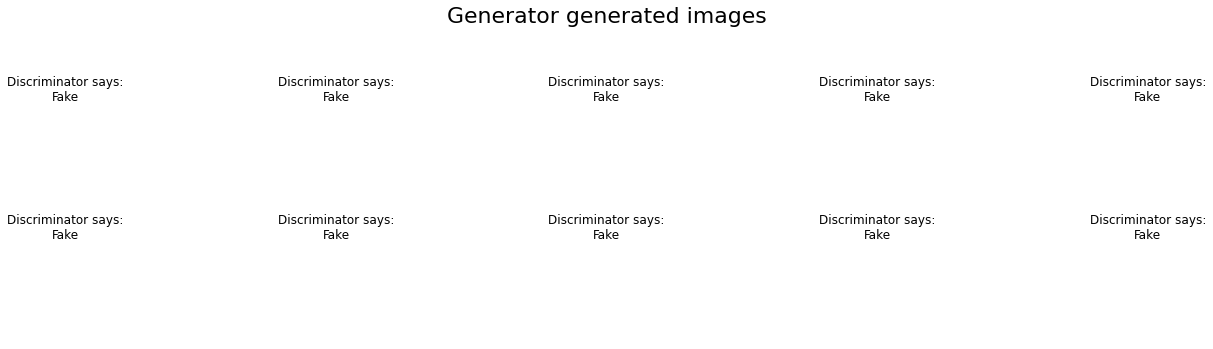

------------------------------------------------------------------------------------------------------------------------


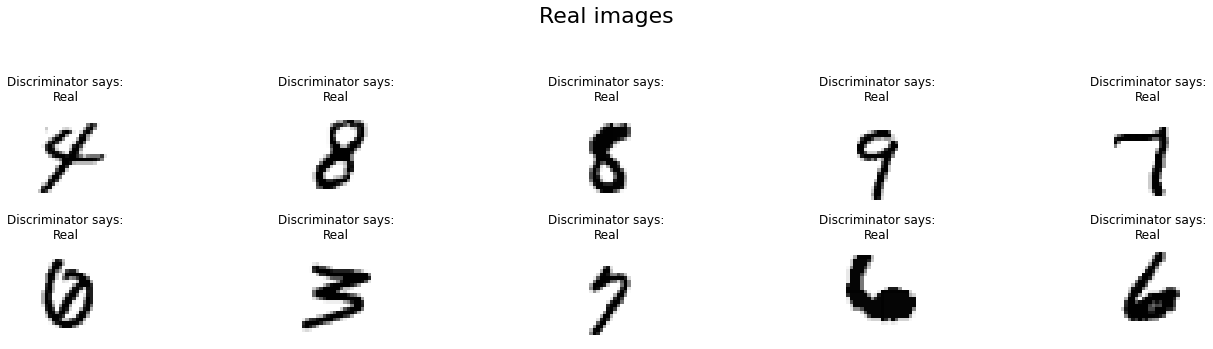

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>12


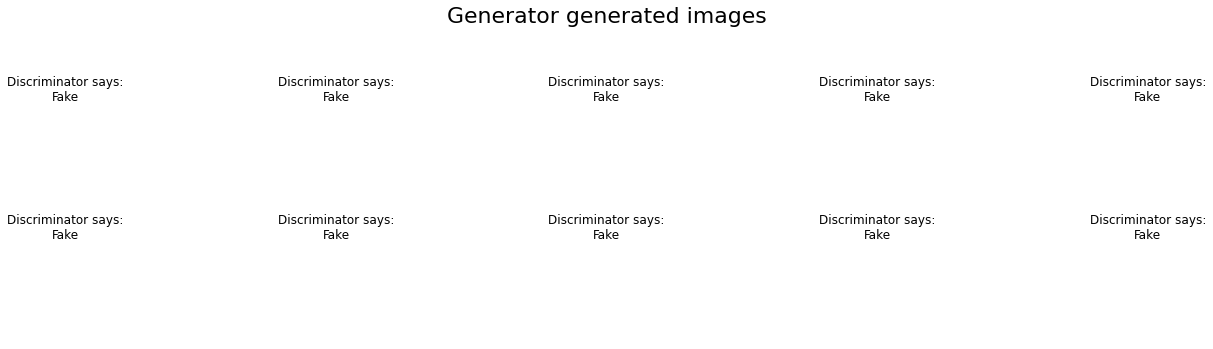

------------------------------------------------------------------------------------------------------------------------


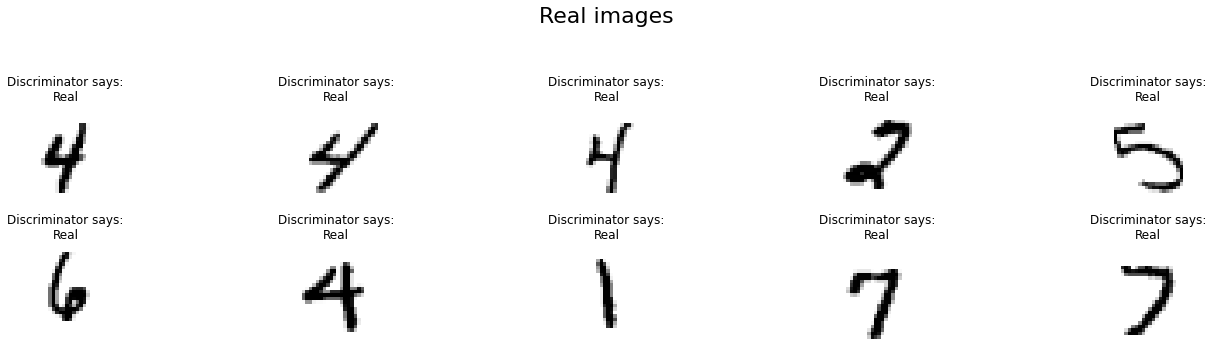

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>13


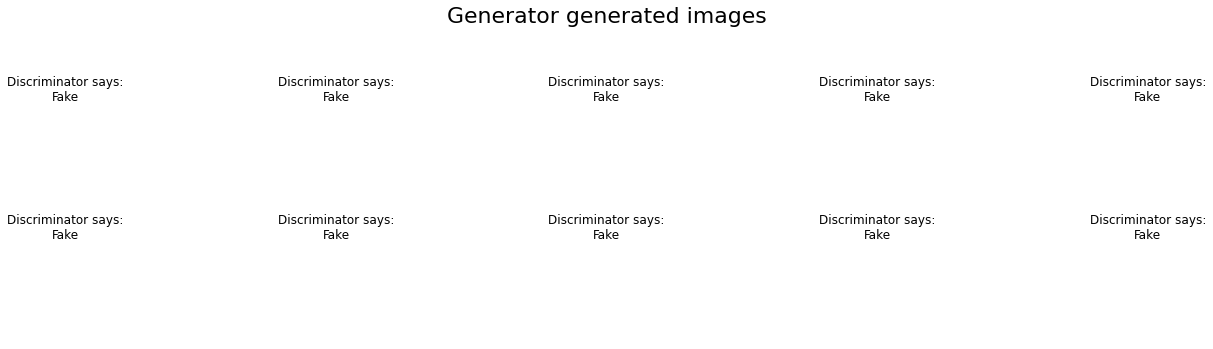

------------------------------------------------------------------------------------------------------------------------


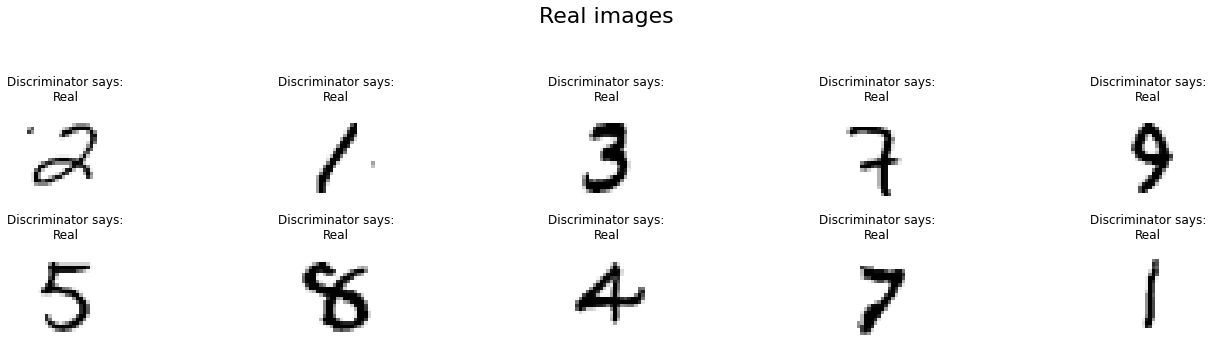

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>14


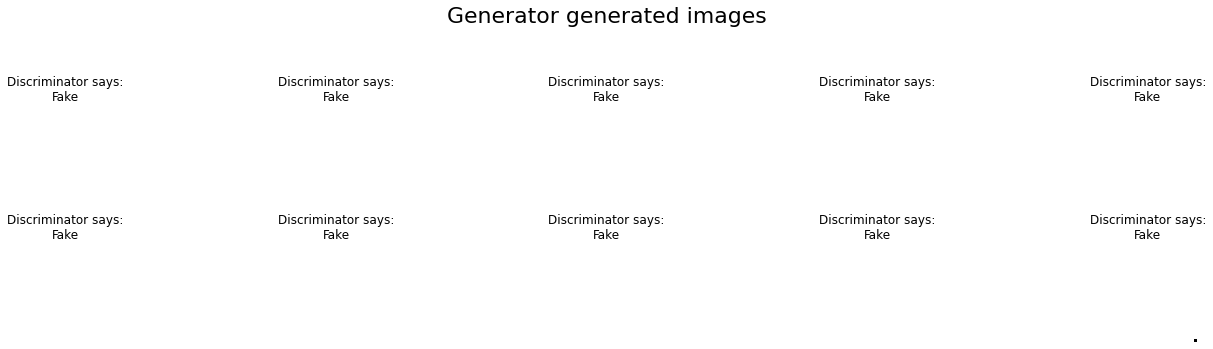

------------------------------------------------------------------------------------------------------------------------


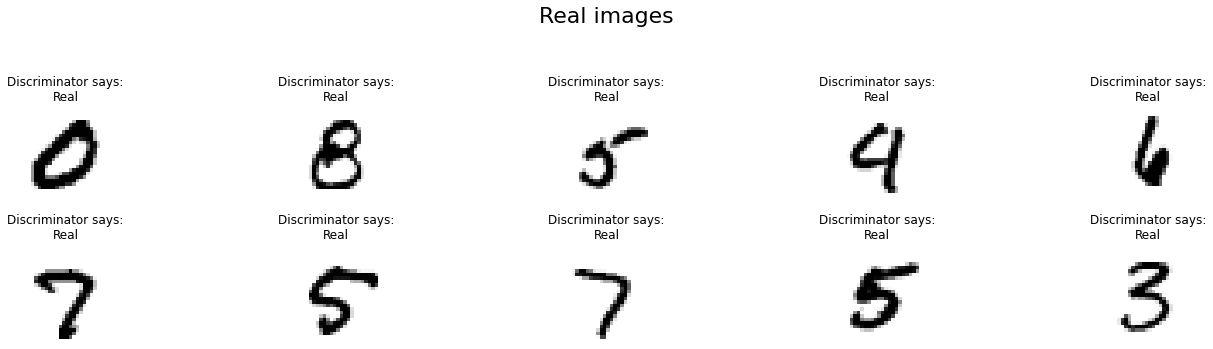

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>15


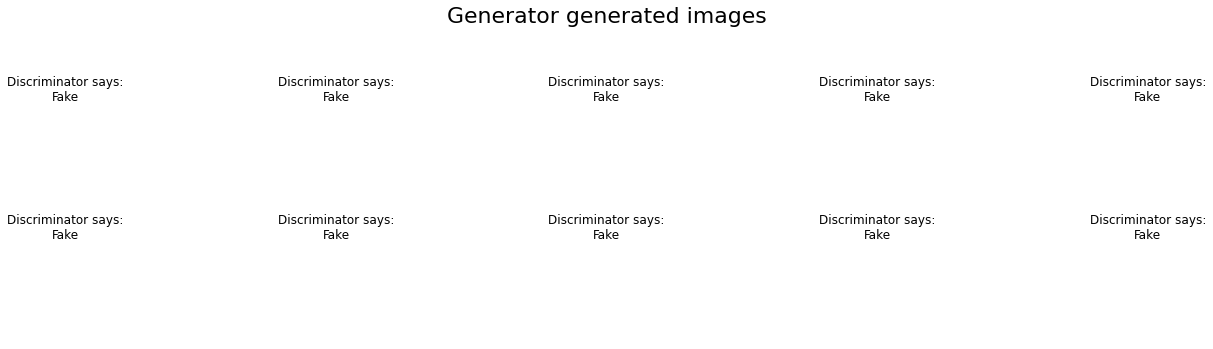

------------------------------------------------------------------------------------------------------------------------


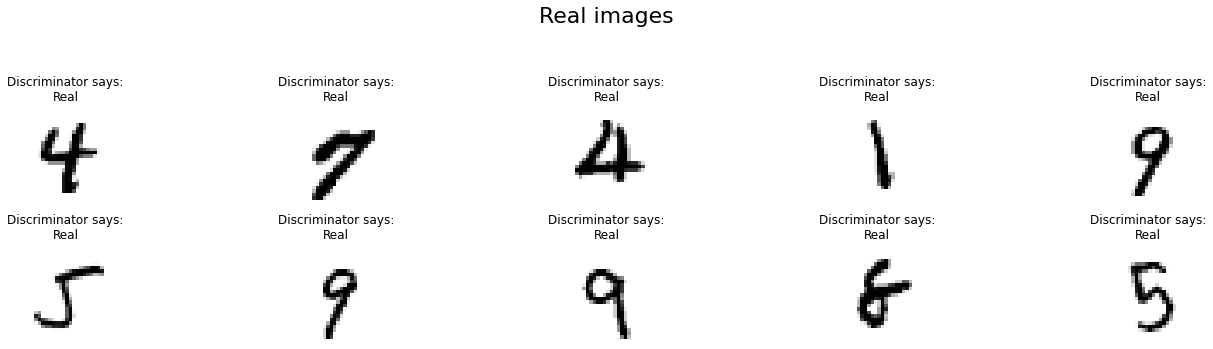

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>16


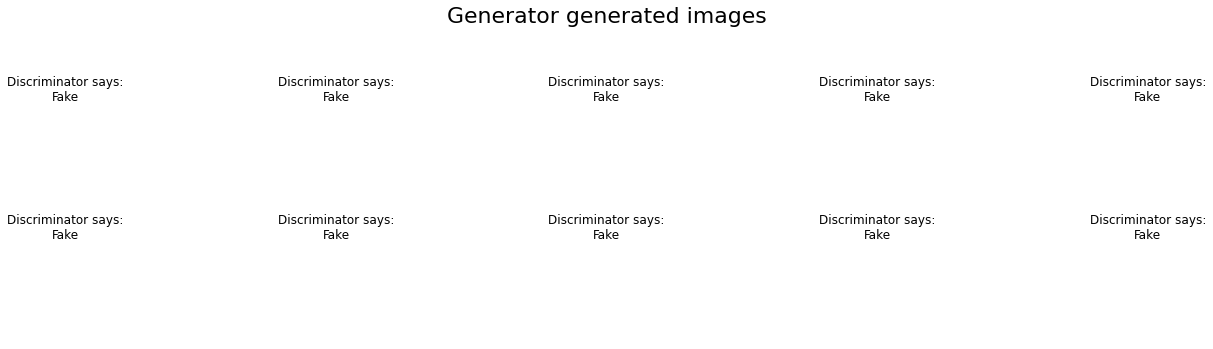

------------------------------------------------------------------------------------------------------------------------


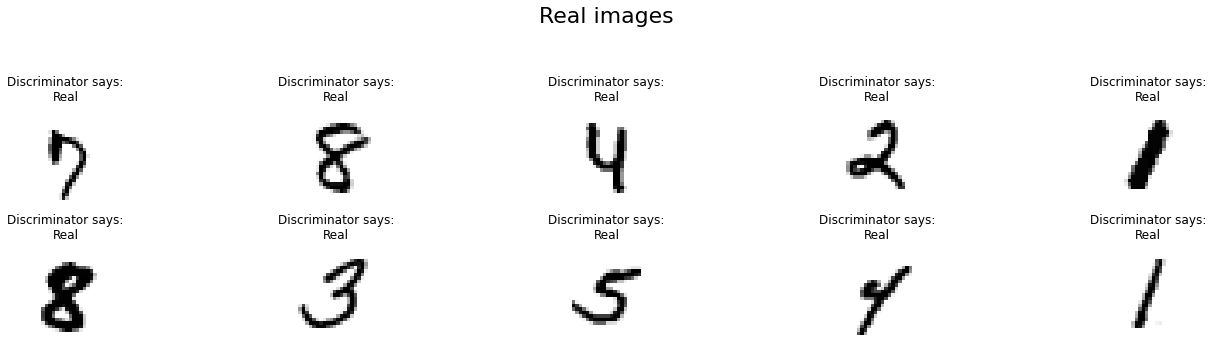

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>17


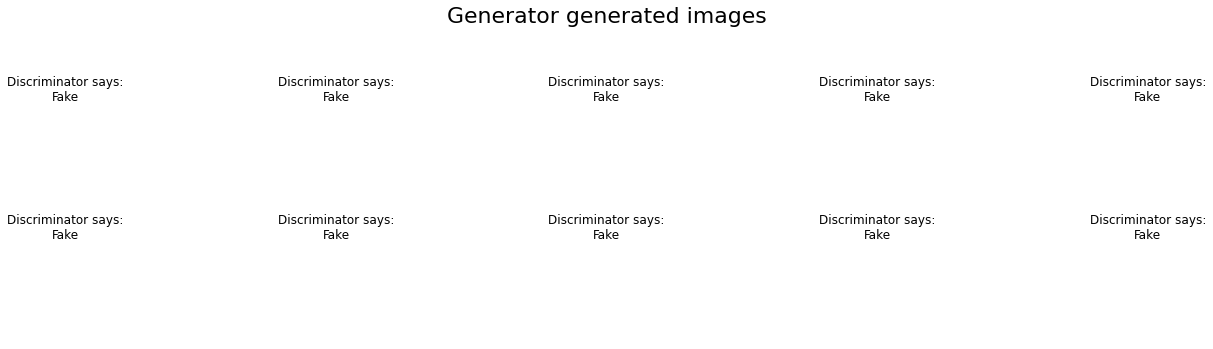

------------------------------------------------------------------------------------------------------------------------


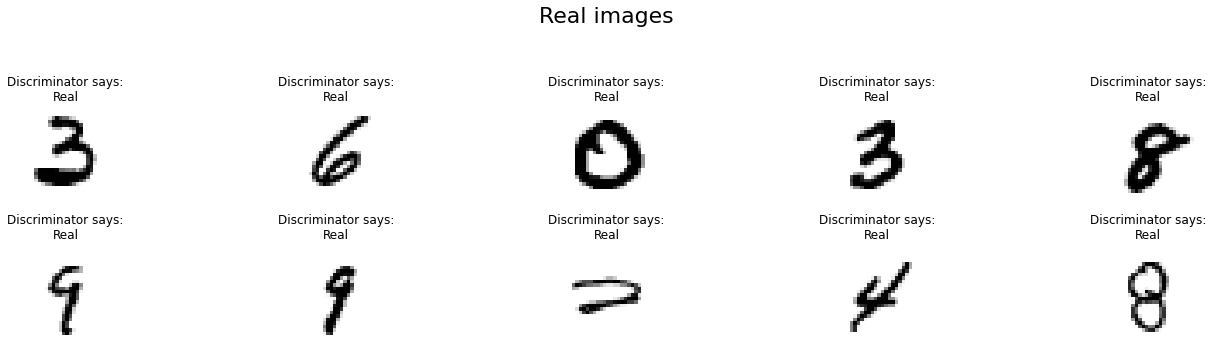

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>18


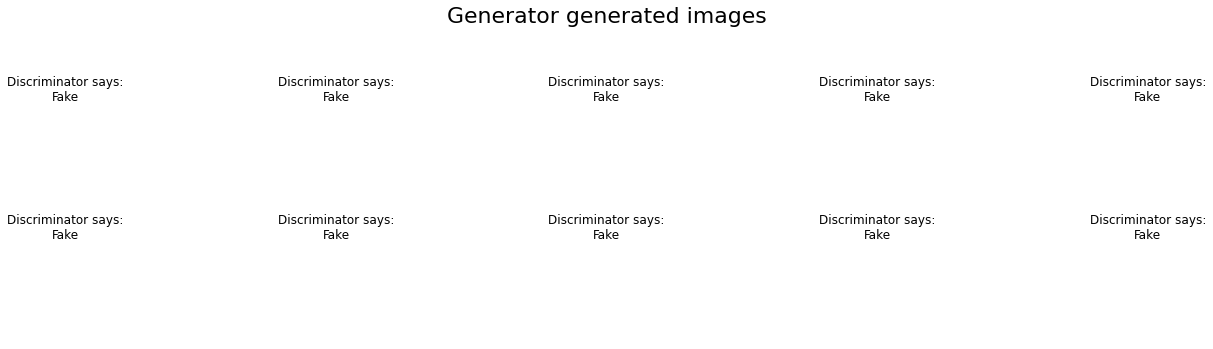

------------------------------------------------------------------------------------------------------------------------


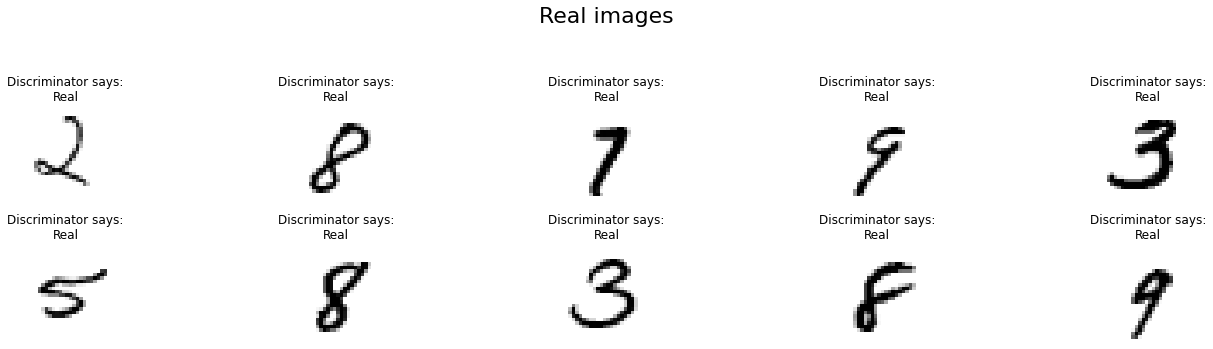

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128

EPOCH------>19


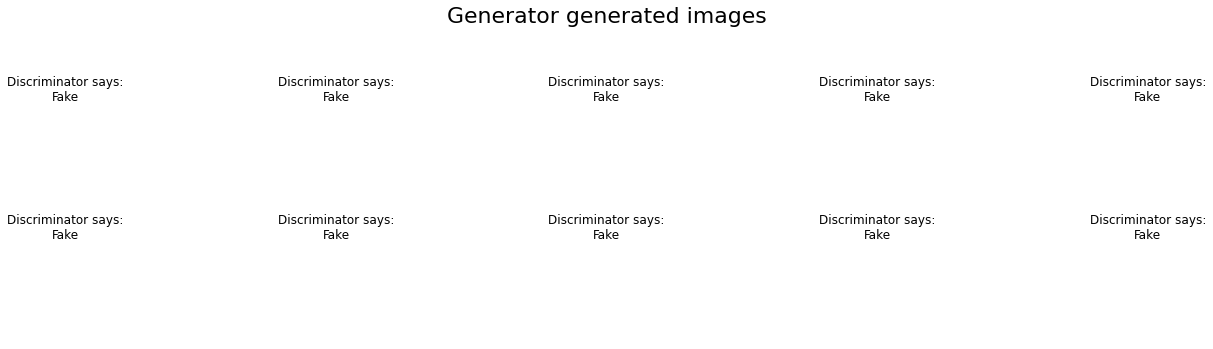

------------------------------------------------------------------------------------------------------------------------


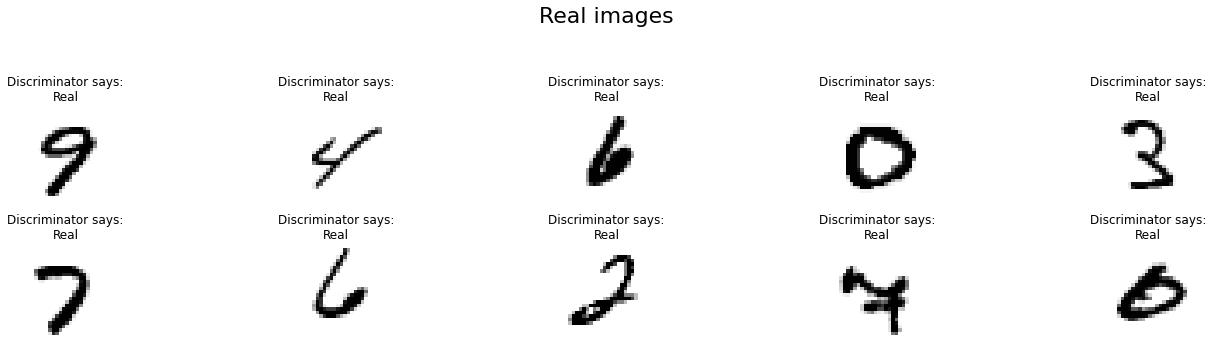

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128
         1.0       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128



In [ ]:
!pip install sklearn-crfsuite
from sklearn_crfsuite.metrics import flat_classification_report

batch_size=128 # tamaño del batch
plt.rcParams["figure.figsize"]=[20,4]
for epoch in range(20): #epochs a realizar
    print("EPOCH------>" + str(epoch))
    for batch in range(int(x.shape[0]/batch_size)): #n° de batchs a realizar según el tamaño batch_size
      # train discriminator
      ix = np.random.randint(0, x.shape[0], batch_size) # generamos índices para samplear imágenes del dataset, sampleamos batch_size=128 datos
      x_real = x[ix]  # seleccionamos las imágenes
      noise = np.random.rand(noise_size * batch_size) # generamos ruido, según el tamaño de la entrada de nuestro generador
      noise = noise.reshape((batch_size, noise_size)) # reshape (batch_size,noise_size) sized noise
      x_false = generator_net.predict(noise) # generamos imágenes fake según el ruido
      y_real= np.ones((batch_size, 1)) # etiquetas real
      y_false = np.zeros((batch_size, 1)) #etiquetas fake
      x_train = np.concatenate((x_real, x_false)) # x_train-> imágenes reales + imágenes fakes
      y_train = np.concatenate((y_real, y_false)) # y_train-> etiquetas reales + etiquetas fakes
      response_dis = discriminator.train_on_batch(x_train, y_train) #train discriminator
      # train generator
      noise2 = np.random.rand(noise_size * batch_size) # generamos ruido nuevamente según el tamaño de la entrada de nuestro generador
      noise2 = noise2.reshape((batch_size, noise_size)) # reshape (batch_size,noise_size) sized noise
      response_gen = gan.train_on_batch(noise2 , np.ones((batch_size, 1))) # output is 1, as generator needs to convine discriminator (trainable false) w/ fake images from noise

      if batch%(500)==0: # cada cuánto plotear es ajustable

          # plot random generated images, discriminator image inputs and outputs, and losses and accuracies
          plt.suptitle("Generator generated images", y=1.2,size=22)
          for i in range(10):
            plt.subplot(2, 5, 1 + i)
            plt.title("Discriminator says:\n"+ ["Fake","Real"][int(np.round(discriminator.predict(x_false[i:i+1, :, :, :])[0,0],0))])
            plt.axis('off')
            plt.imshow(x_false[i, :, :, 0], cmap='gray_r')
          plt.tight_layout()
          plt.show()
          print("-"*120)
          
          plt.suptitle("Real images", y=1.2,size=22)
          for i in range(10):
            plt.subplot(2, 5, 1 + i)
            plt.title("Discriminator says:\n"+ ["Fake","Real"][int(np.round(discriminator.predict(x_real[i:i+1, :, :, :])[0,0],0))])
            plt.axis('off')
            plt.imshow(x_real[i, :, :, 0],cmap='gray_r')
          plt.tight_layout()
          plt.show()
          print("-"*120)    
    print("DISCRIMINADOR-------------")
    y_pred_dis = np.round(discriminator.predict(x_train))
    print(flat_classification_report(y_train, y_pred_dis))

    print("GENERADOR-------------")
    y_pred_gen = np.round(discriminator.predict(x_false))
    print(flat_classification_report(y_false, y_pred_gen))

## 4.b) Mejora de GAN.

Utilizando el código modificado en el punto 4.b y lo aprendido durante el ramo. Modifique la arquitectura de la red neuronal a modo de obtener imágenes fake sean convincentes. Adicionalmente responda/comente según lo que observa durante el entrenamiento de la red neuronal.

* Explicar el comportamiento de la evolución de ambos desempeños y por qué no necesariamente esos valores representan que la red alcance su cometido
* Describir, teórica o práctiamente, que ocurriría si la red generadora no pudiera por algún motivo (divergencia en entrenamiento, excesivo _underfitting_, etc) generar imágenes razonables.
* Describir la contraparte de lo que ocurriría si la red discriminadora no pudiera aprender a diferenciar imagenes reales de ruido aleatorio.


Una vez teniendo una red entrenada a completitud, muestre varias imagenes generadas. ¿Se logra obtener imágenes convincentes?. Igualmente con la red entrenada, guarde el ruido aleatorio que origina dos números reconocibles distintos. ¿Qué ocurre si vemos las imagenes generadas por el generador al entregarle el vector del promedio entre los dos puntos?


* El comportamiento de la red generadora y de la discriminadora va oscilando, ya que como una red intenta generar imágenes parecidas a las reales, a partir del feedback de la red discriminadora, esta última intenta detectar las imágenes falsas generadas por la red generadora, por lo que por cada epoch es normal ver un incremento/disminución del accuracy en ambas redes. Estos valores no representan que la red alcance su cometido puesto que podría ocurrir que la red generadora encuentre un patrón en el cual pueda "engañar" a la red discriminadora, de tal manera que clasifique como "real" lo generado y solamente sería una ilusión ya que lo generado visualmente no tendría parentezco con lo real al ojo humano.
* Si la red generadora no pudiera generar imágenes razonables, el discriminador seguiría pudiendo entrenarse sin problema, ya que seguiría alimentándose de imágenes reales y falsas como siempre lo ha hecho. Lamentablemente al no generar imágenes razonables, se genera este efecto rebote en el cual tampoco podría seguir mejorandose esta red generadora al no obtener un buen feedback.
* Si la red discriminadora asume como real el ruido y los números reales, no aportaría al mejoramiento del generador, no obteniendo un feedback certero por lo que no aprendería efectivamente a generar números que tengan sentido y al ojo humano diríamos que es real.

* Se ven imágenes bastante convincentes en las últimas epoch, pudiendo visualizar algúnos números bastante semejantes a los reales del dataset.

El siguiente código fue extraído de:

 https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

Esto se hizo con el objetivo de poder visualizar el cambio de arquitectura de la propuesta en 4.a) por una que sea capaz de entregar resultados. Se evidencia que tanto el discriminador como el generador son arquitecturas más complejas y con mayor número de capas, incluyendo nuevos tipos de capas como Conv2dTranspose y LeakyReLU.

EPOCH------>0


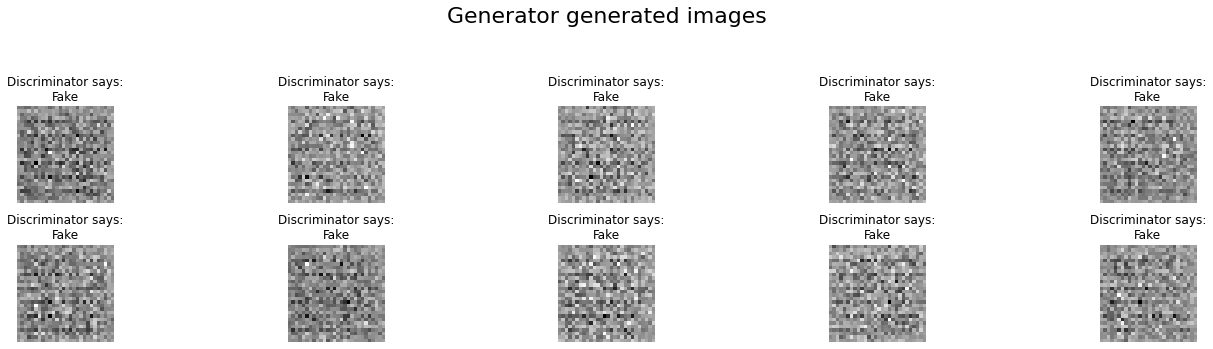

------------------------------------------------------------------------------------------------------------------------


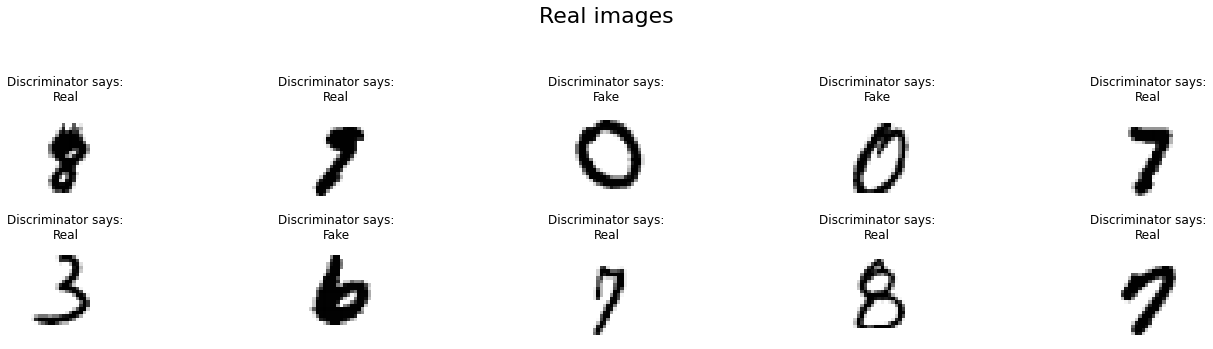

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       100
   macro avg       0.50      0.49      0.50       100
weighted avg       1.00      0.99      0.99       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

>Accuracy real: 99%, fake: 100%
EPOCH------>1


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


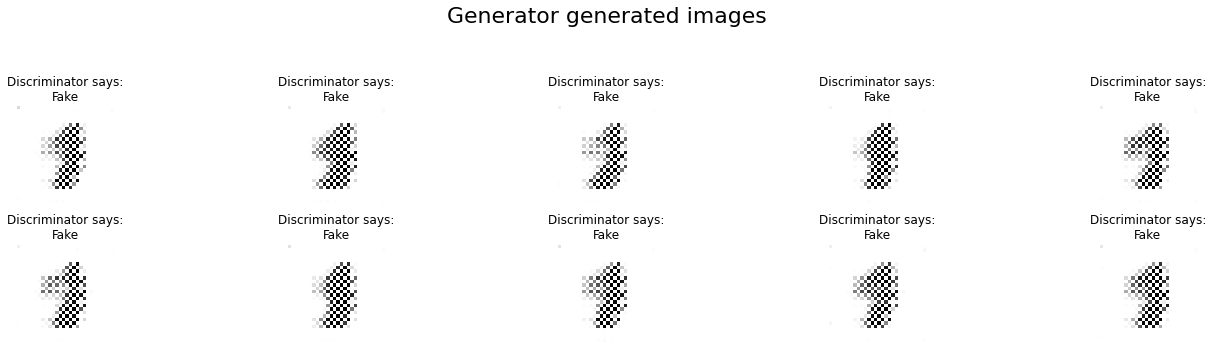

------------------------------------------------------------------------------------------------------------------------


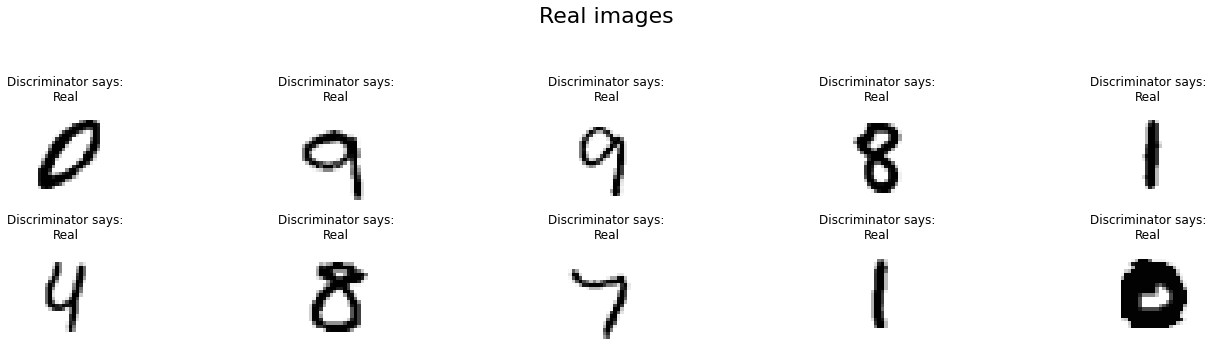

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.69      0.82       100

    accuracy                           0.69       100
   macro avg       0.50      0.34      0.41       100
weighted avg       1.00      0.69      0.82       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.73       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.58       100
   macro avg       0.50      0.29      0.37       100
weighted avg       1.00      0.58      0.73       100

>Accuracy real: 69%, fake: 58%
EPOCH------>2


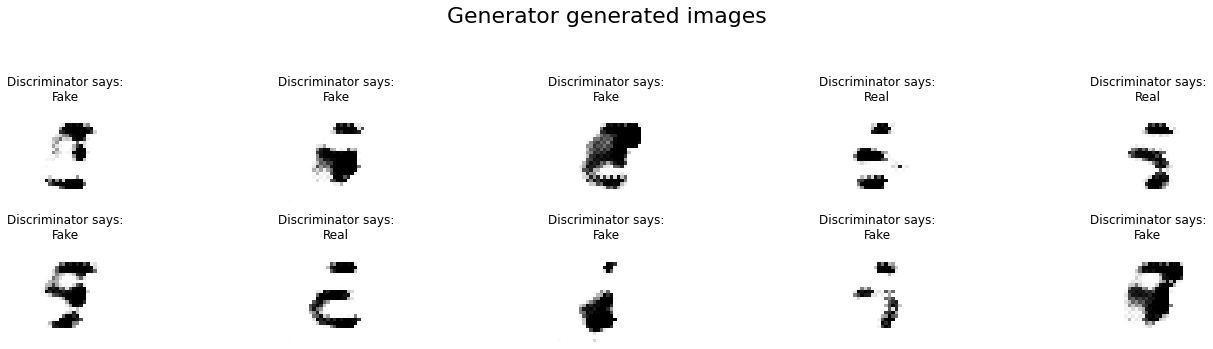

------------------------------------------------------------------------------------------------------------------------


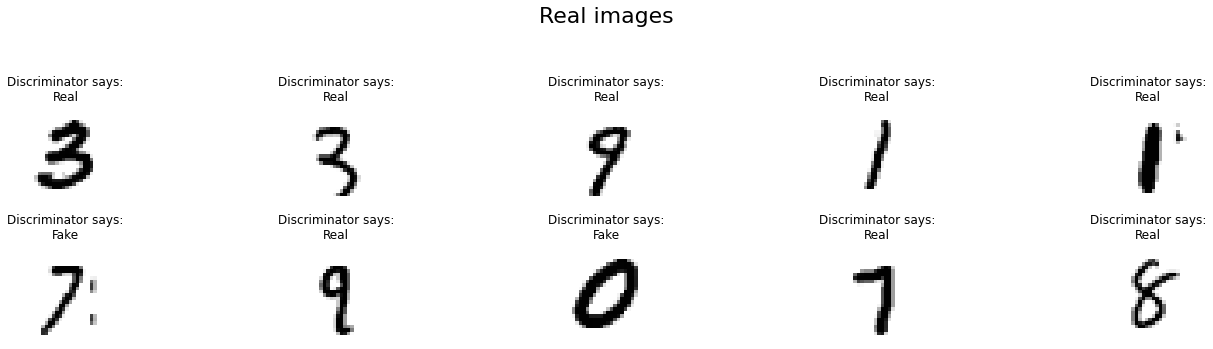

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.55      0.71       100

    accuracy                           0.55       100
   macro avg       0.50      0.28      0.35       100
weighted avg       1.00      0.55      0.71       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.40      0.57       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.40       100
   macro avg       0.50      0.20      0.29       100
weighted avg       1.00      0.40      0.57       100

>Accuracy real: 55%, fake: 40%
EPOCH------>3


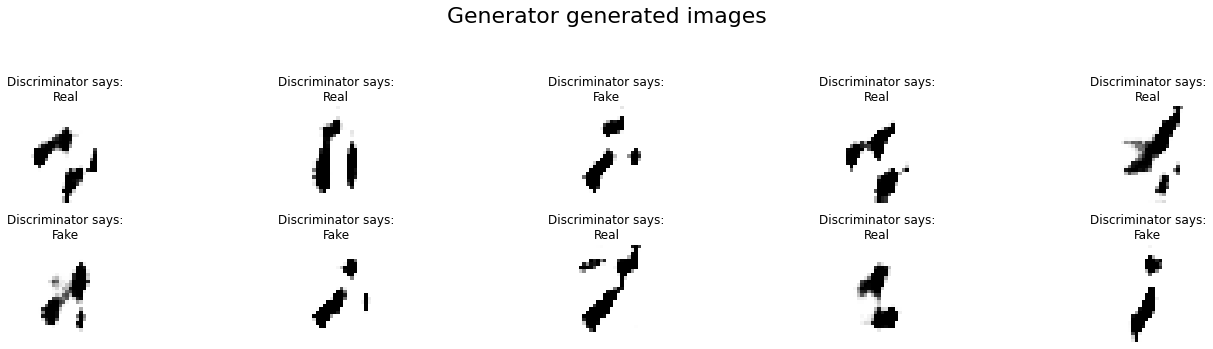

------------------------------------------------------------------------------------------------------------------------


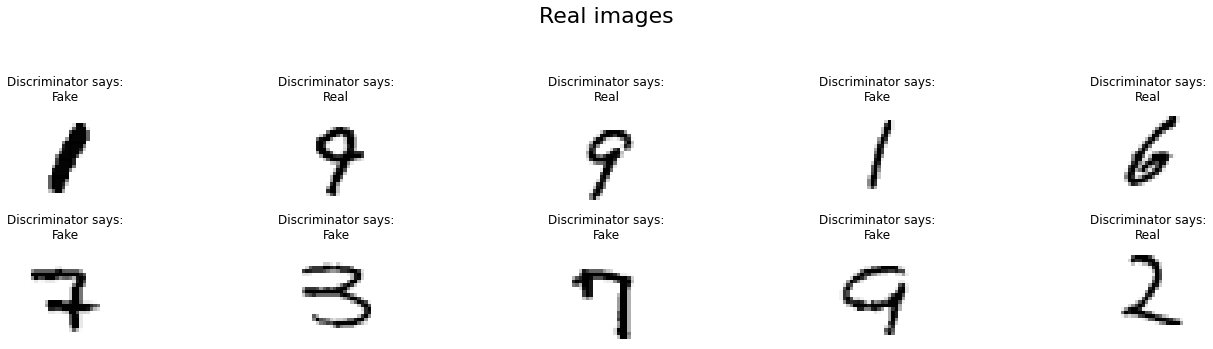

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.44      0.61       100

    accuracy                           0.44       100
   macro avg       0.50      0.22      0.31       100
weighted avg       1.00      0.44      0.61       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.53       100
   macro avg       0.50      0.27      0.35       100
weighted avg       1.00      0.53      0.69       100

>Accuracy real: 44%, fake: 53%
EPOCH------>4


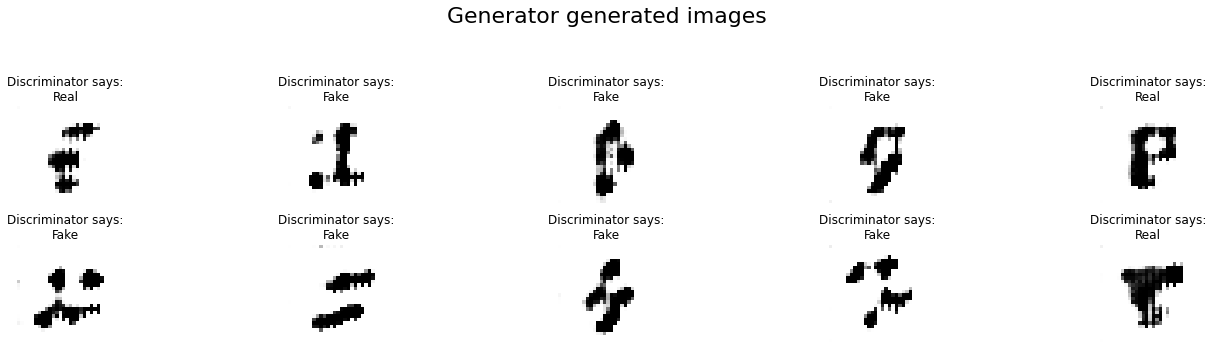

------------------------------------------------------------------------------------------------------------------------


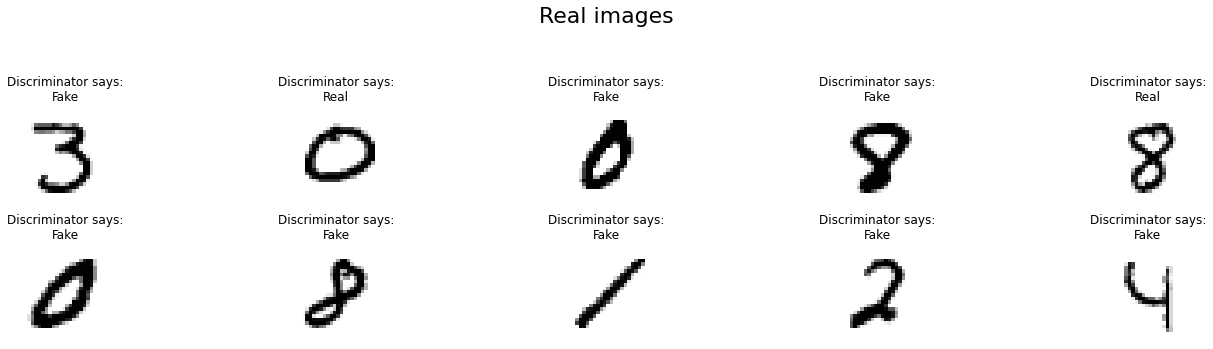

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.52      0.68       100

    accuracy                           0.52       100
   macro avg       0.50      0.26      0.34       100
weighted avg       1.00      0.52      0.68       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.62      0.77       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.62       100
   macro avg       0.50      0.31      0.38       100
weighted avg       1.00      0.62      0.77       100

>Accuracy real: 52%, fake: 62%
EPOCH------>5


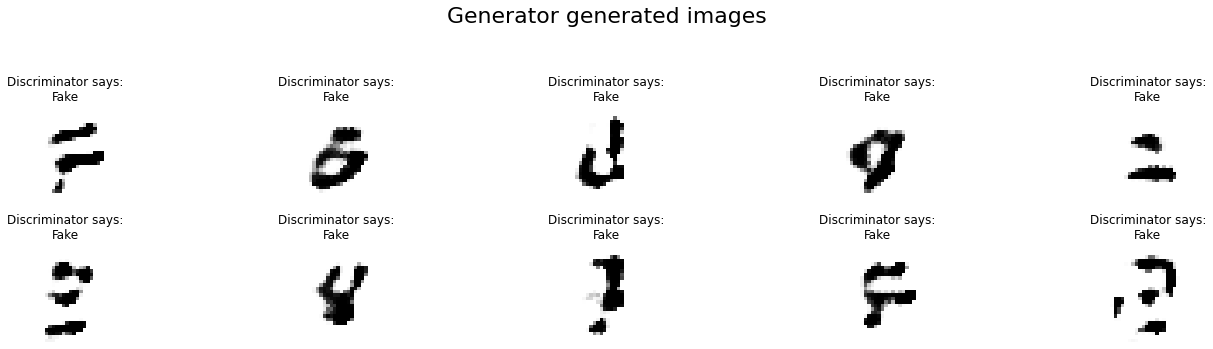

------------------------------------------------------------------------------------------------------------------------


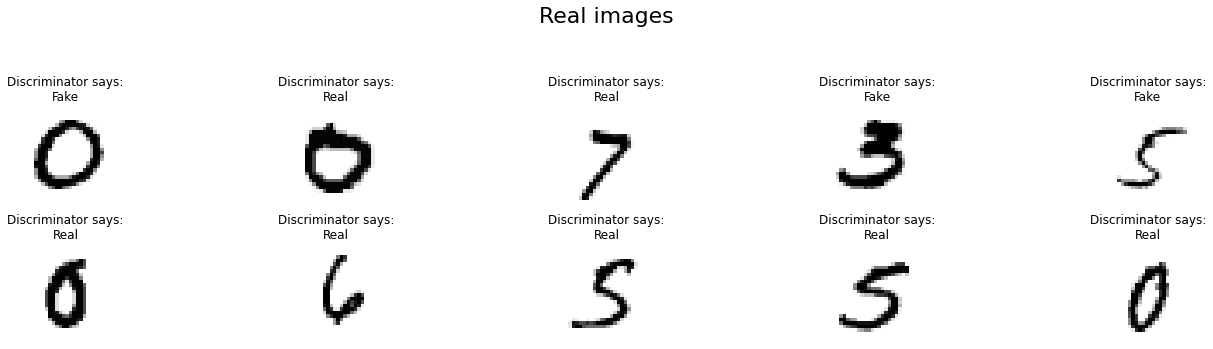

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91       100

    accuracy                           0.83       100
   macro avg       0.50      0.41      0.45       100
weighted avg       1.00      0.83      0.91       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.76       100
   macro avg       0.50      0.38      0.43       100
weighted avg       1.00      0.76      0.86       100

>Accuracy real: 83%, fake: 76%
EPOCH------>6


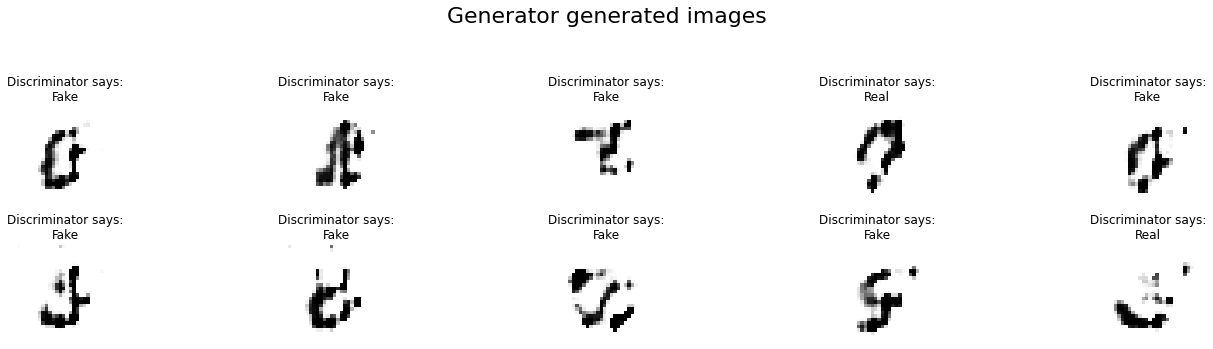

------------------------------------------------------------------------------------------------------------------------


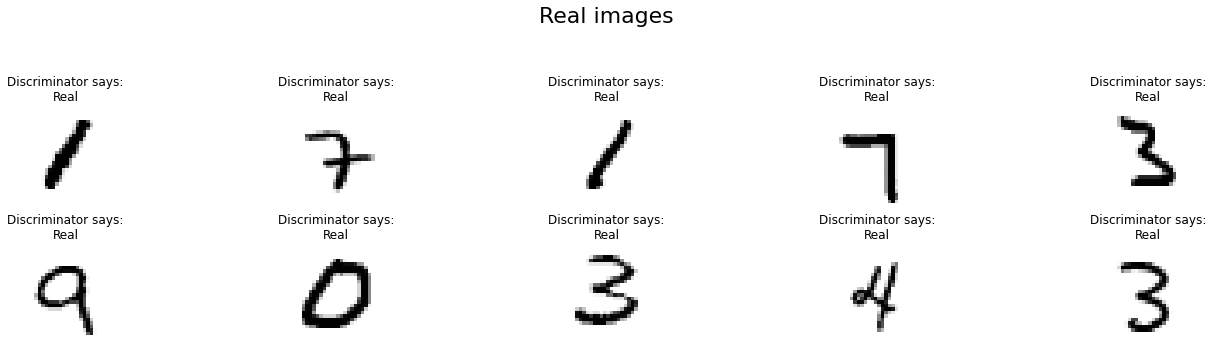

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.84      0.91       100

    accuracy                           0.84       100
   macro avg       0.50      0.42      0.46       100
weighted avg       1.00      0.84      0.91       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.52      0.68       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.52       100
   macro avg       0.50      0.26      0.34       100
weighted avg       1.00      0.52      0.68       100

>Accuracy real: 84%, fake: 52%
EPOCH------>7


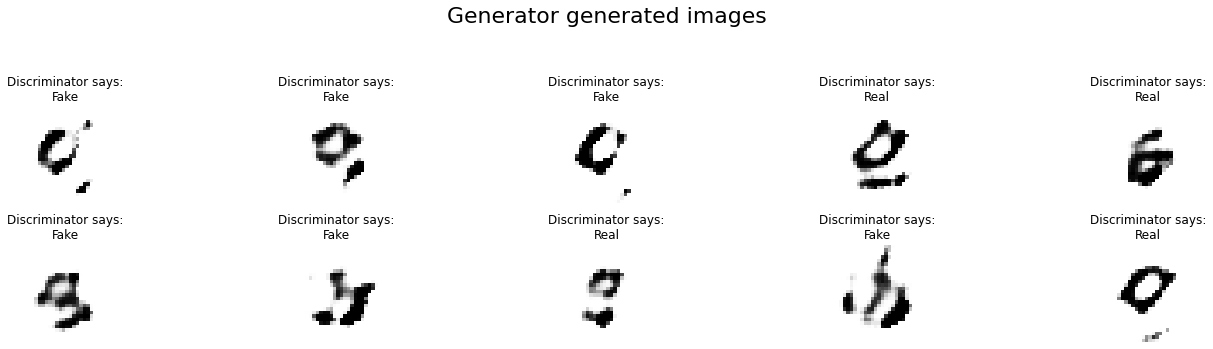

------------------------------------------------------------------------------------------------------------------------


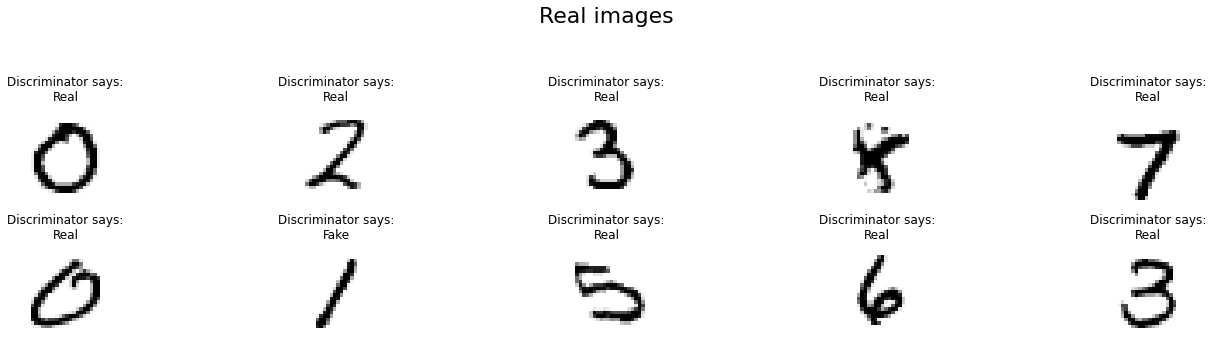

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.68      0.81       100

    accuracy                           0.68       100
   macro avg       0.50      0.34      0.40       100
weighted avg       1.00      0.68      0.81       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.71       100
   macro avg       0.50      0.35      0.42       100
weighted avg       1.00      0.71      0.83       100

>Accuracy real: 68%, fake: 71%
EPOCH------>8


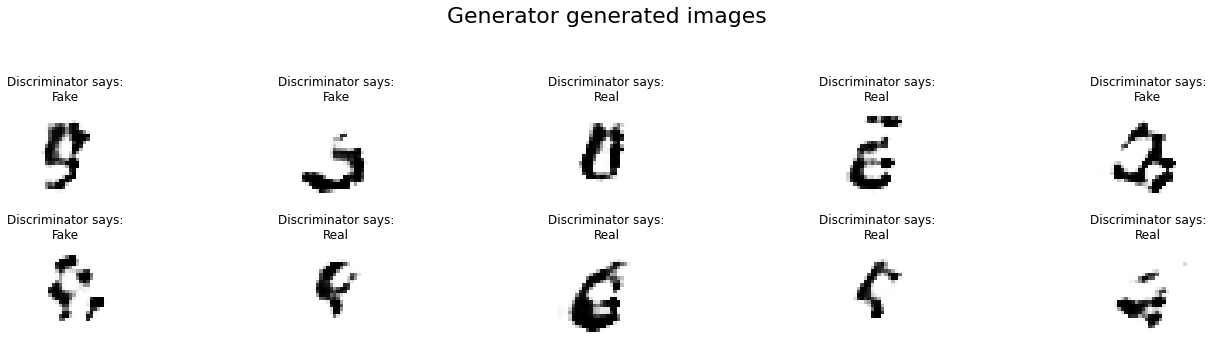

------------------------------------------------------------------------------------------------------------------------


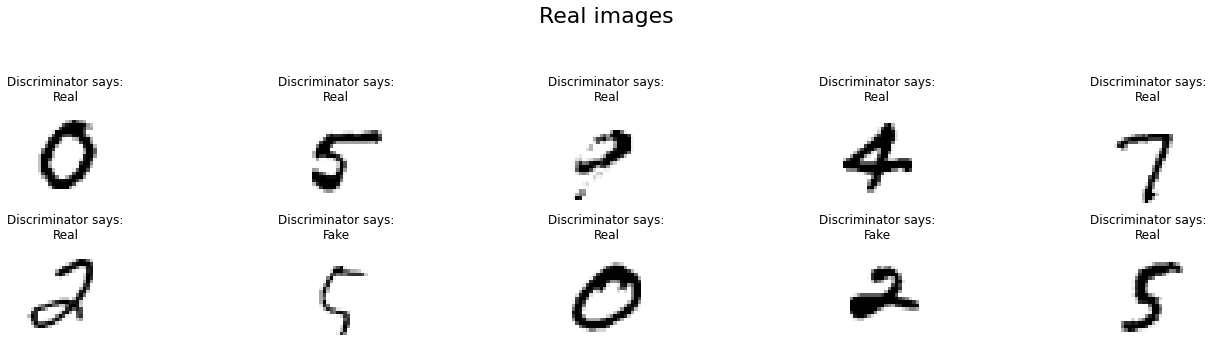

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.74      0.85       100

    accuracy                           0.74       100
   macro avg       0.50      0.37      0.43       100
weighted avg       1.00      0.74      0.85       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.53       100
   macro avg       0.50      0.27      0.35       100
weighted avg       1.00      0.53      0.69       100

>Accuracy real: 74%, fake: 53%
EPOCH------>9


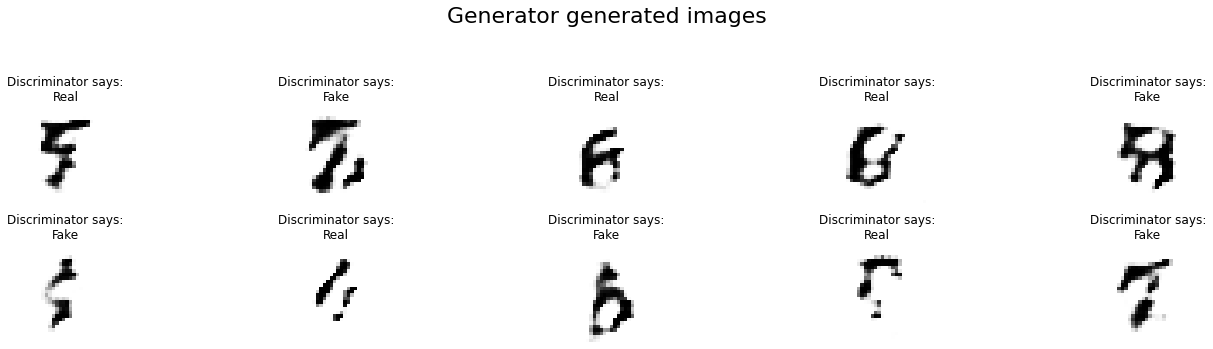

------------------------------------------------------------------------------------------------------------------------


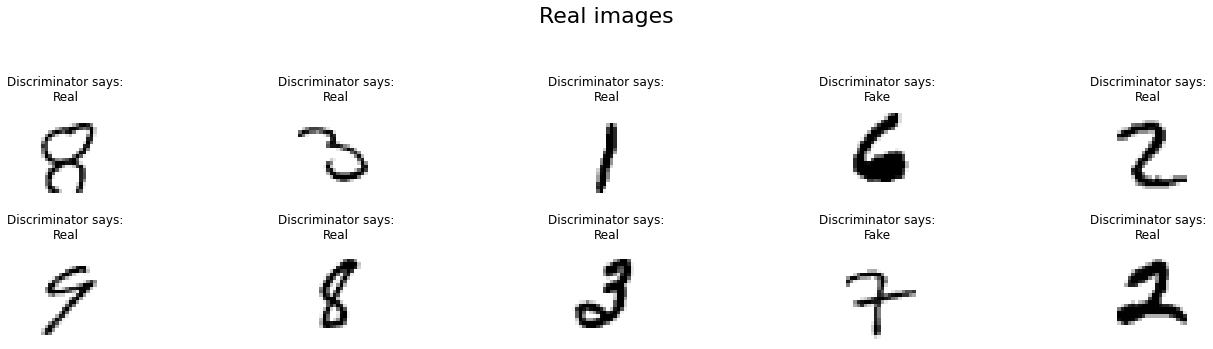

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.45      0.62       100

    accuracy                           0.45       100
   macro avg       0.50      0.23      0.31       100
weighted avg       1.00      0.45      0.62       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.79       100
   macro avg       0.50      0.40      0.44       100
weighted avg       1.00      0.79      0.88       100

>Accuracy real: 45%, fake: 79%
EPOCH------>10


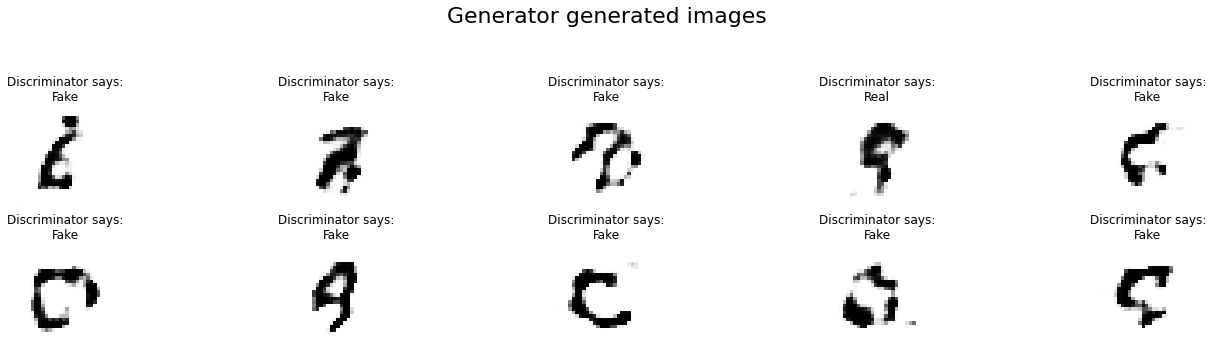

------------------------------------------------------------------------------------------------------------------------


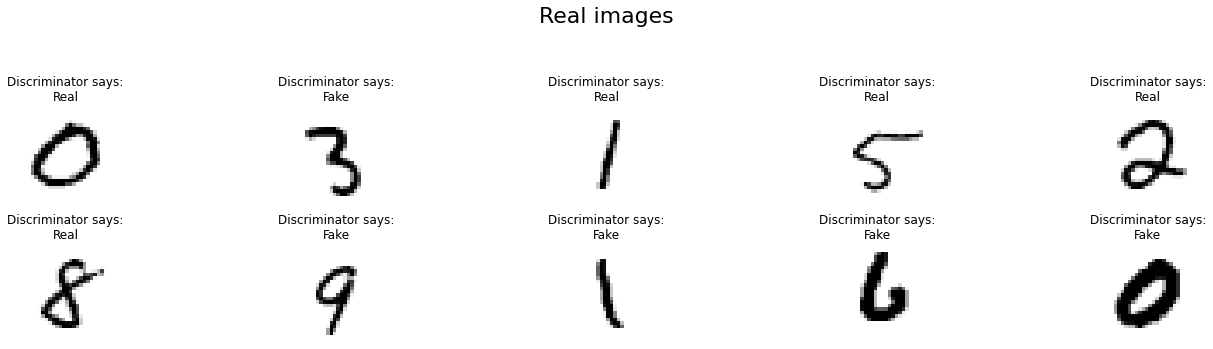

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.60      0.75       100

    accuracy                           0.60       100
   macro avg       0.50      0.30      0.37       100
weighted avg       1.00      0.60      0.75       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.80       100
   macro avg       0.50      0.40      0.44       100
weighted avg       1.00      0.80      0.89       100

>Accuracy real: 60%, fake: 80%
EPOCH------>11


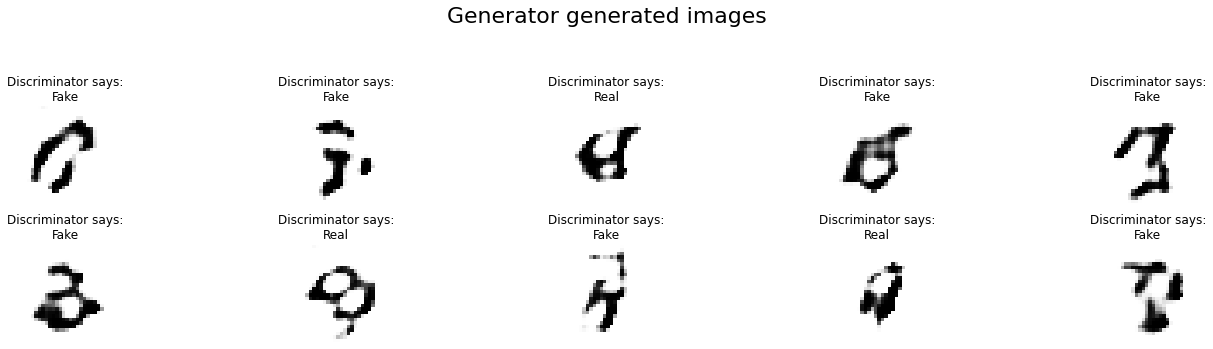

------------------------------------------------------------------------------------------------------------------------


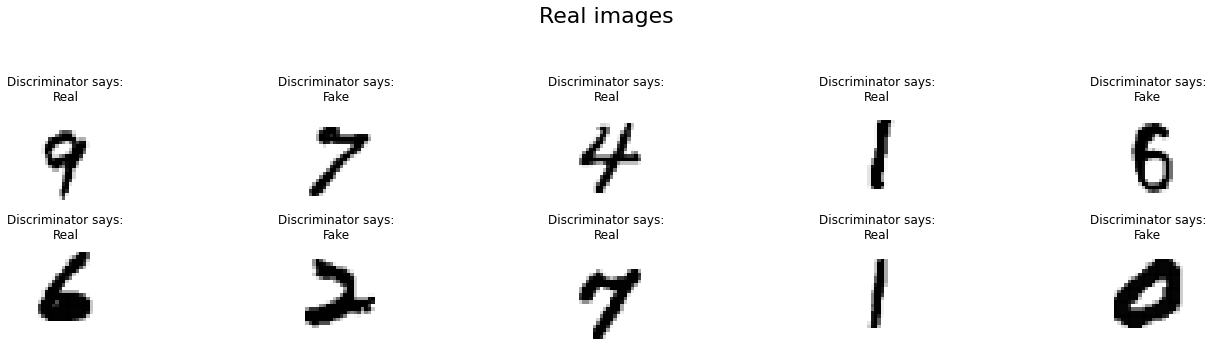

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.54      0.70       100

    accuracy                           0.54       100
   macro avg       0.50      0.27      0.35       100
weighted avg       1.00      0.54      0.70       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.93       100
   macro avg       0.50      0.47      0.48       100
weighted avg       1.00      0.93      0.96       100

>Accuracy real: 54%, fake: 93%
EPOCH------>12


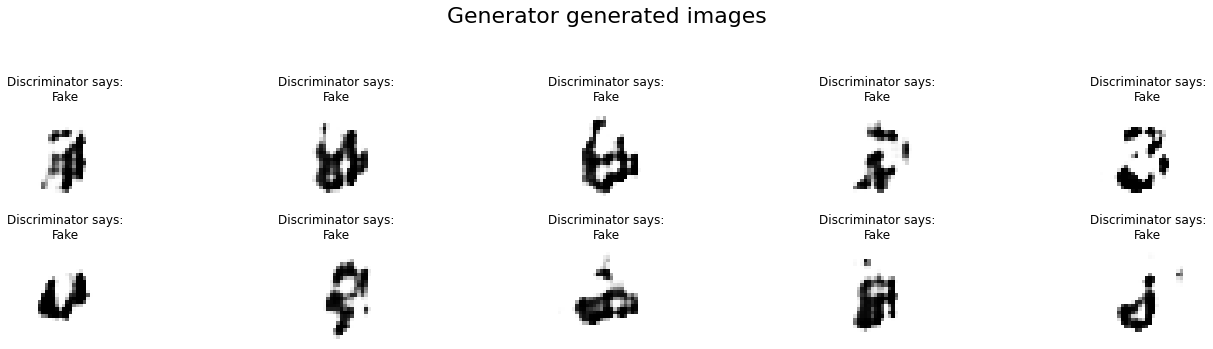

------------------------------------------------------------------------------------------------------------------------


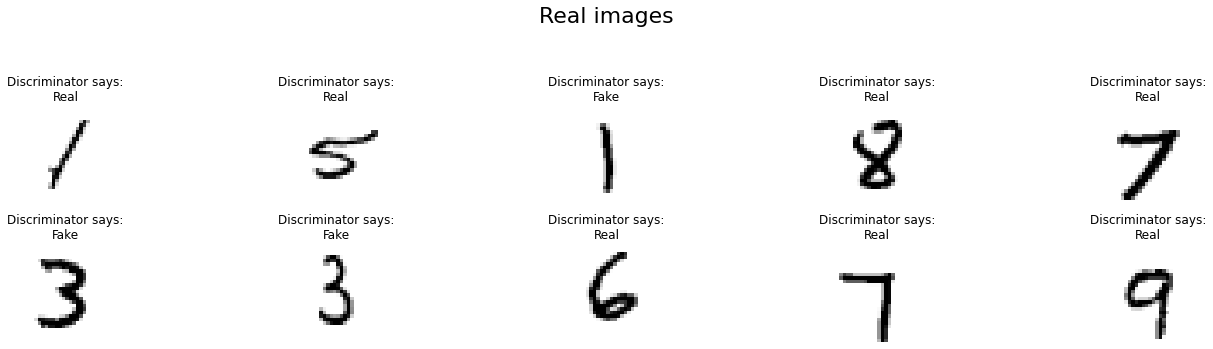

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.90      0.95       100

    accuracy                           0.90       100
   macro avg       0.50      0.45      0.47       100
weighted avg       1.00      0.90      0.95       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.07      0.13       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.07       100
   macro avg       0.50      0.04      0.07       100
weighted avg       1.00      0.07      0.13       100

>Accuracy real: 90%, fake: 7%
EPOCH------>13


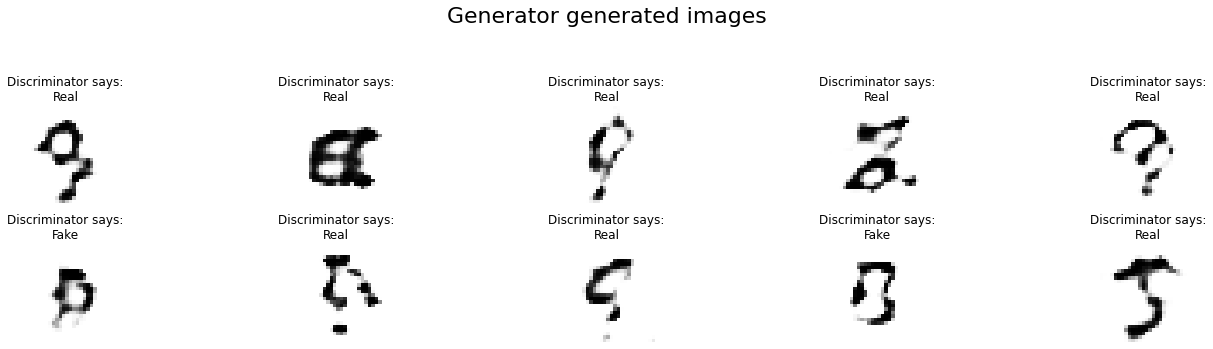

------------------------------------------------------------------------------------------------------------------------


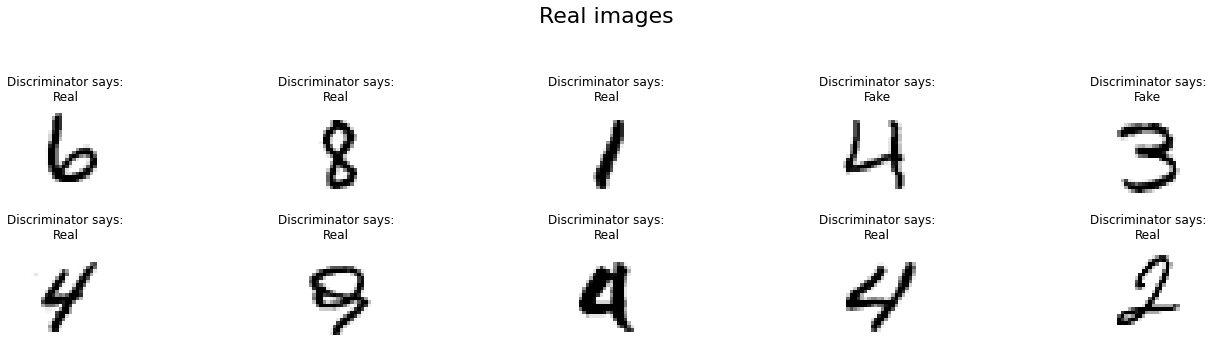

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.46      0.63       100

    accuracy                           0.46       100
   macro avg       0.50      0.23      0.32       100
weighted avg       1.00      0.46      0.63       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.75       100
   macro avg       0.50      0.38      0.43       100
weighted avg       1.00      0.75      0.86       100

>Accuracy real: 46%, fake: 75%
EPOCH------>14


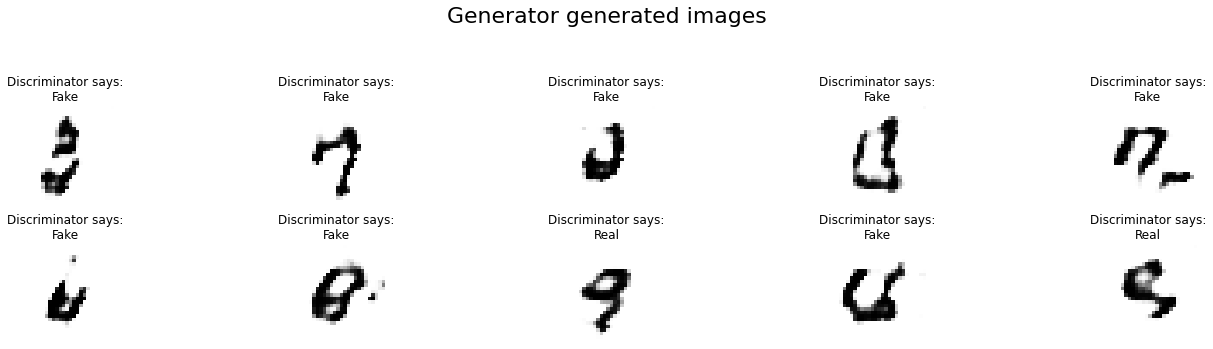

------------------------------------------------------------------------------------------------------------------------


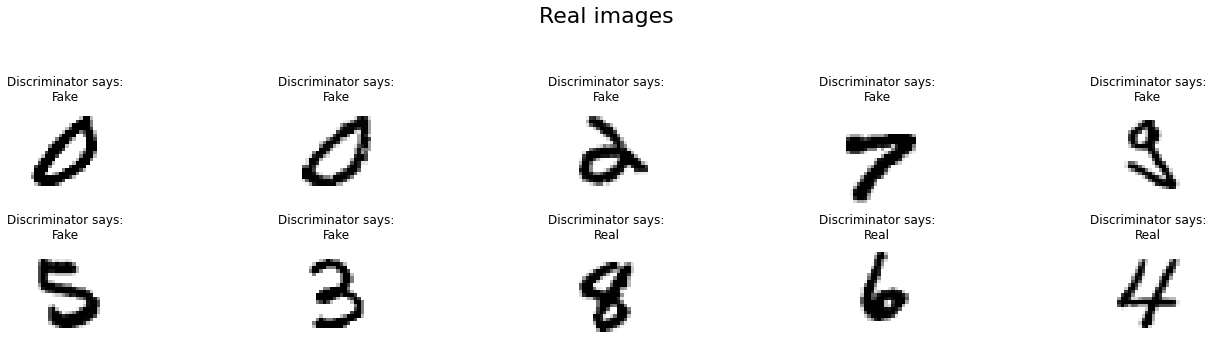

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.57      0.73       100

    accuracy                           0.57       100
   macro avg       0.50      0.28      0.36       100
weighted avg       1.00      0.57      0.73       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.79       100
   macro avg       0.50      0.40      0.44       100
weighted avg       1.00      0.79      0.88       100

>Accuracy real: 57%, fake: 79%
EPOCH------>15


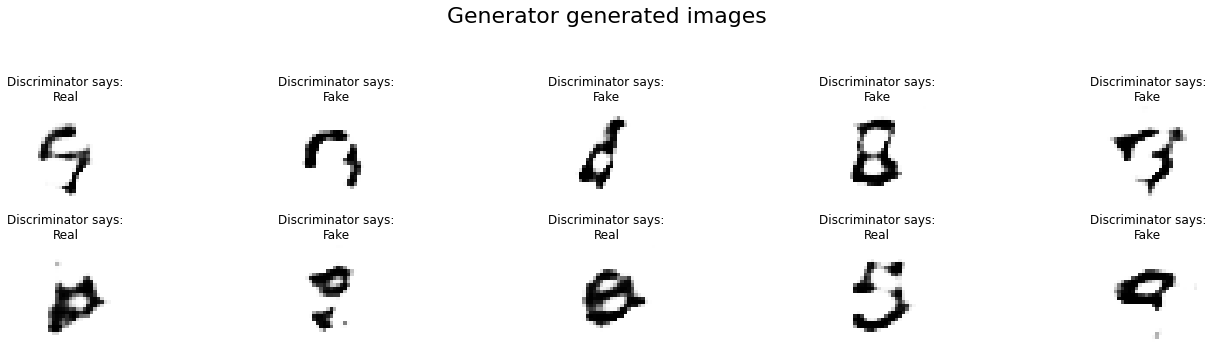

------------------------------------------------------------------------------------------------------------------------


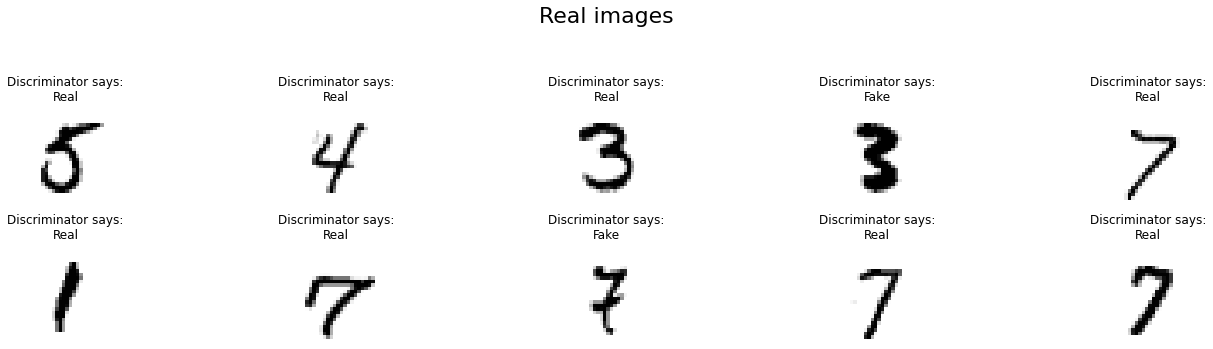

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.85      0.92       100

    accuracy                           0.85       100
   macro avg       0.50      0.42      0.46       100
weighted avg       1.00      0.85      0.92       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.46      0.63       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.46       100
   macro avg       0.50      0.23      0.32       100
weighted avg       1.00      0.46      0.63       100

>Accuracy real: 85%, fake: 46%
EPOCH------>16


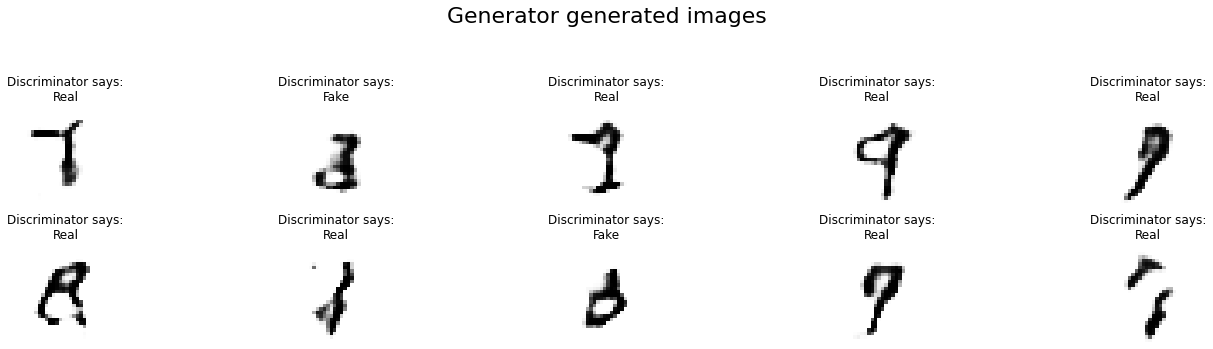

------------------------------------------------------------------------------------------------------------------------


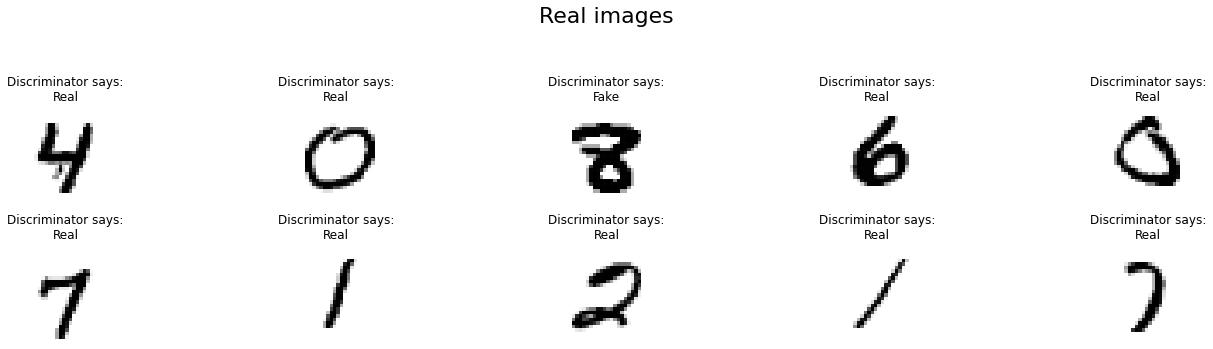

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.99      0.99       100

    accuracy                           0.99       100
   macro avg       0.50      0.49      0.50       100
weighted avg       1.00      0.99      0.99       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.29       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.17       100
   macro avg       0.50      0.09      0.15       100
weighted avg       1.00      0.17      0.29       100

>Accuracy real: 99%, fake: 17%
EPOCH------>17


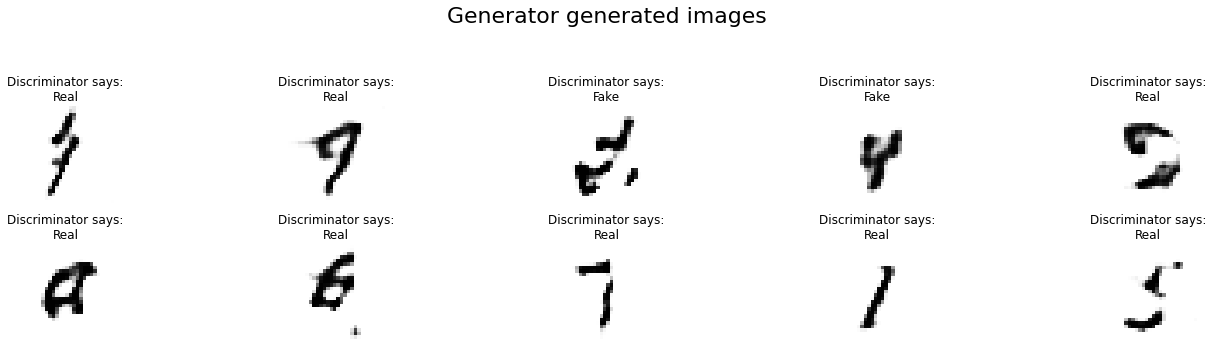

------------------------------------------------------------------------------------------------------------------------


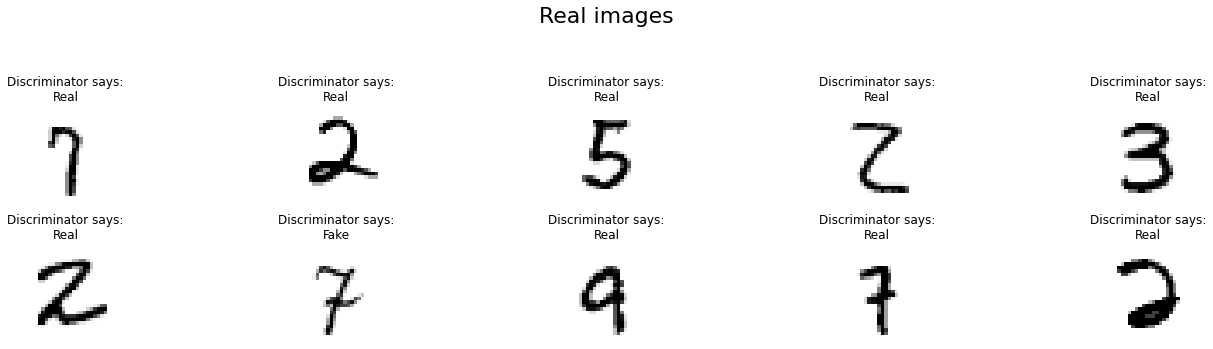

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.70      0.82       100

    accuracy                           0.70       100
   macro avg       0.50      0.35      0.41       100
weighted avg       1.00      0.70      0.82       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.62      0.77       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.62       100
   macro avg       0.50      0.31      0.38       100
weighted avg       1.00      0.62      0.77       100

>Accuracy real: 70%, fake: 62%
EPOCH------>18


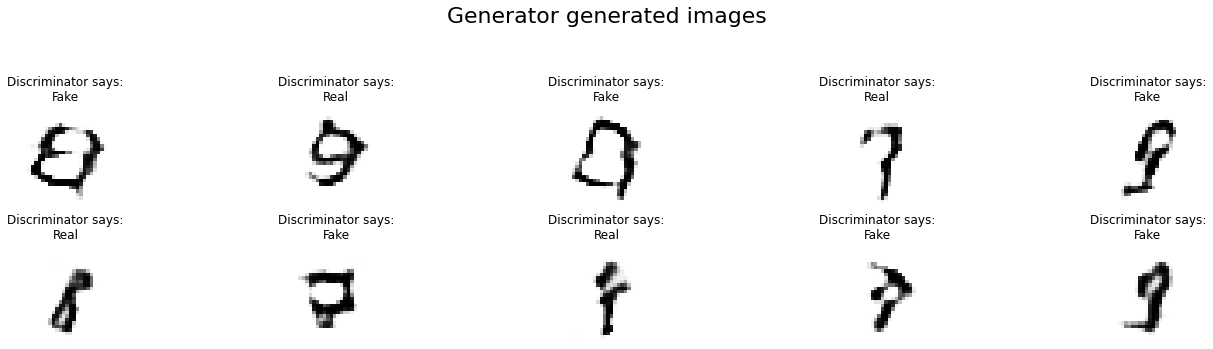

------------------------------------------------------------------------------------------------------------------------


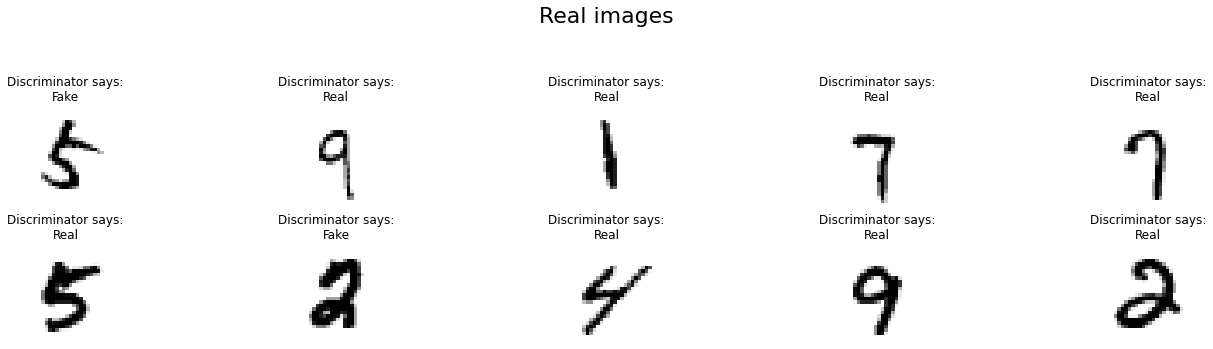

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.25      0.40       100

    accuracy                           0.25       100
   macro avg       0.50      0.12      0.20       100
weighted avg       1.00      0.25      0.40       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.93       100
   macro avg       0.50      0.47      0.48       100
weighted avg       1.00      0.93      0.96       100

>Accuracy real: 25%, fake: 93%
EPOCH------>19


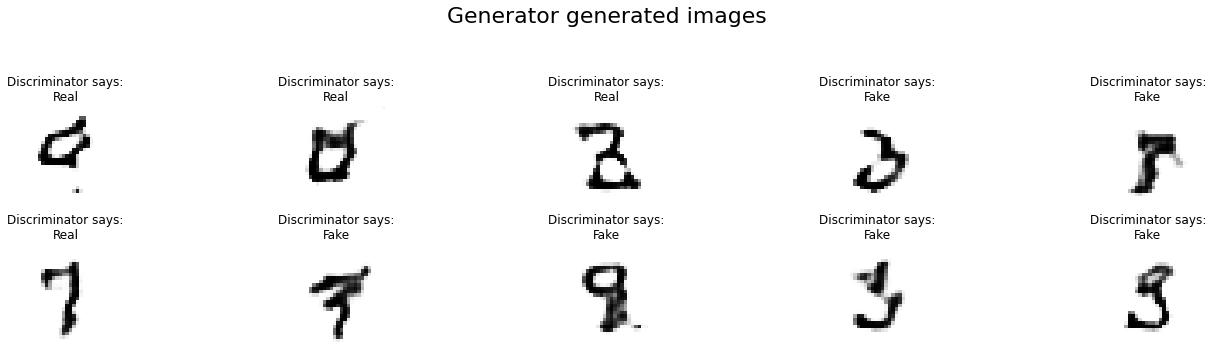

------------------------------------------------------------------------------------------------------------------------


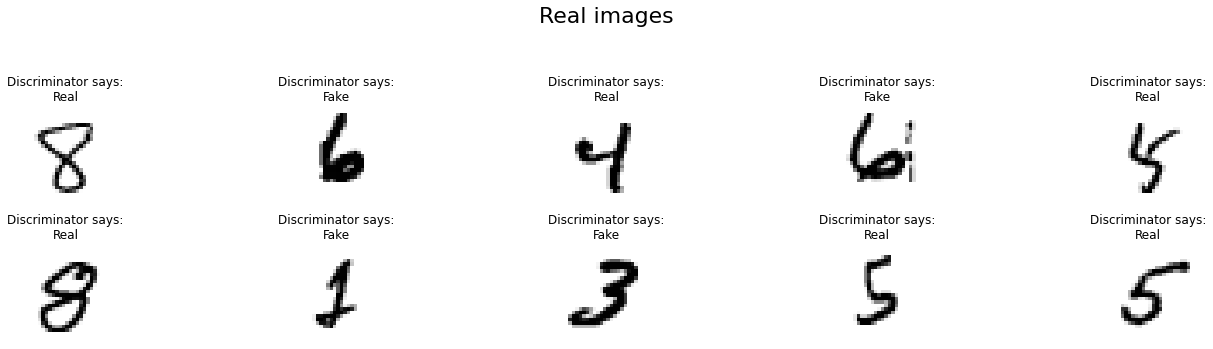

------------------------------------------------------------------------------------------------------------------------
DISCRIMINADOR-------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.91      0.95       100

    accuracy                           0.91       100
   macro avg       0.50      0.46      0.48       100
weighted avg       1.00      0.91      0.95       100

GENERADOR-------------
              precision    recall  f1-score   support

         0.0       1.00      0.21      0.35       100
         1.0       0.00      0.00      0.00         0

    accuracy                           0.21       100
   macro avg       0.50      0.10      0.17       100
weighted avg       1.00      0.21      0.35       100

>Accuracy real: 91%, fake: 21%


In [ ]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

plt.rcParams["figure.figsize"]=[20,4]
def definir_discriminador(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def definir_generador(latent_dim):
    model = Sequential()
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

def definir_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def cargar_x_real():
    (trainX, _), (_, _) = load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

def generar_samples_reales(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

def generar_puntos_latentes(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generar_data_falsa(g_model, latent_dim, n_samples):
    x_input = generar_puntos_latentes(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

def guardar_plot(examples, epoch, n=10):
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

def evaluar_discriminador(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generar_samples_reales(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generar_data_falsa(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    print("DISCRIMINADOR-------------")
    y_pred_dis = np.round(d_model.predict(X_real))
    print(flat_classification_report(y_real, y_pred_dis))

    print("GENERADOR-------------")
    y_pred_gen = np.round(d_model.predict(x_fake))
    print(flat_classification_report(y_fake, y_pred_gen))

    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        print("EPOCH------>" + str(i))
        for j in range(bat_per_epo):
            X_real, y_real = generar_samples_reales(dataset, half_batch)
            X_fake, y_fake = generar_data_falsa(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generar_puntos_latentes(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            if j%(500)==0: # cada cuánto plotear es ajustable
              # plot random generated images, discriminator image inputs and outputs, and losses and accuracies
              plt.suptitle("Generator generated images", y=1.2,size=22)
              for i in range(10):
                plt.subplot(2, 5, 1 + i)
                plt.title("Discriminator says:\n"+ ["Fake","Real"][int(np.round(d_model.predict(X_fake[i:i+1, :, :, :])[0,0],0))])
                plt.axis('off')
                plt.imshow(X_fake[i, :, :, 0], cmap='gray_r')
              plt.tight_layout()
              plt.show()
              print("-"*120)
              
              plt.suptitle("Real images", y=1.2,size=22)
              for i in range(10):
                plt.subplot(2, 5, 1 + i)
                plt.title("Discriminator says:\n"+ ["Fake","Real"][int(np.round(d_model.predict(X_real[i:i+1, :, :, :])[0,0],0))])
                plt.axis('off')
                plt.imshow(X_real[i, :, :, 0],cmap='gray_r')
              plt.tight_layout()
              plt.show()
              print("-"*120)
        evaluar_discriminador(i, g_model, d_model, dataset, latent_dim)
        #if (i+1) % 10 == 0:
            #evaluar_discriminador(i, g_model, d_model, dataset, latent_dim)

# Tamaño del espacio latente
latent_dim = 100
# Discriminaddor
d_model = definir_discriminador()
# Generador
g_model = definir_generador(latent_dim)
# GAN
gan_model = definir_gan(g_model, d_model)
# Cargar data
dataset = cargar_x_real()
train(g_model, d_model, gan_model, dataset, latent_dim)
